# Final Project: MRI Image Brain Tumor Classification Using CNN

In [3]:
import numpy as np
from scipy.signal import convolve2d
from datasets import load_dataset
import torchvision.transforms as transforms
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from torchsummary import summary
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import copy
import time
from typing import Union, List
from tqdm import tqdm
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

C:\Users\jimta\anaconda3\envs\deep_learning_course\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Loading dataset and data preprocessing

In [2]:
dataset = load_dataset("sartajbhuvaji/Brain-Tumor-Classification")

In [3]:
# vertical edge detection kernel
VK = np.array([ [1,0,-1],
                [1,0,-1],
                [1,0,-1]])

# horizontal edge detection kernel
HK = np.array([ [ 1, 1, 1],
                [ 0, 0, 0],
                [-1,-1,-1] ])

In [4]:
def apply_HV_detection(img_tensor: torch.Tensor):
    # original (blurred) img_tensor size (256x256)
    # turn to numpy ndarray
    img_ndarray = img_tensor.numpy()
    
    # run convolution to apply vertical and horizontal edge detection kernels on the ndarray
    V_convres = convolve2d(img_ndarray,VK,mode='same')
    #print(V_convres.shape)
    
    H_convres = convolve2d(img_ndarray,HK,mode='same')
    #print(H_convres.shape)
    
    # merge the original ndarray and the two edge detected ndarrays to get 3 channels
    edge_detected_tensor = torch.stack([img_tensor,torch.Tensor(V_convres),torch.Tensor(H_convres)])
    #print(edge_detected_tensor.size())
    
    return edge_detected_tensor

In [5]:
def pad_img(img_tensor, tensor_size):
    pad_left = int(np.floor((512-tensor_size[-1])/2))
    pad_top = int(np.floor((512-tensor_size[-2])/2))
    pad_right = 512-tensor_size[-1]-pad_left
    pad_bot = 512-tensor_size[-2]-pad_top
    #print(pad_left)
    #print(pad_right)
    #print(pad_top)
    #print(pad_bot)
   
    padded_img_tensor = F.pad(img_tensor, (pad_left, pad_right, pad_top, pad_bot), 'constant', 0)
    return padded_img_tensor

In [6]:
def imgLstToTensors(img_lst, label_lst):
    img_lab_data = []
    
    for image,label in zip(img_lst,label_lst):
        # Convert MRI image to gray scale then turn image into float tensor
        img_tensor = transforms.ToTensor()(image.convert('L'))
        # Most of the images in the samples are with shape 512*512
        # to ensure all the samples we use have the same shape, we will pad the samples with both width and height less than 512
        # and skip other samples that are not
        if img_tensor.size() != torch.Size([1, 512, 512]):
            if (img_tensor.size()[-1] < 512) and (img_tensor.size()[-2] < 512):
                padded_img_tensor = pad_img(img_tensor, img_tensor.size())
                # image tensor shape of 512*512 will make the training very costly, 
                # apply mean pooling on the tensor to reduce the shape to 256*256
                blurred_img_tensor = F.avg_pool2d(padded_img_tensor.detach().unsqueeze(dim=0),
                                                  kernel_size=2,stride=2).squeeze()
                # Apply horizontal and vertical edge detection kernels to create 2 additional channels for the MRI image
                edge_detected_img_tensor = apply_HV_detection(blurred_img_tensor)
                # Add image tensor into the output list with its label value
                img_lab_data.append((edge_detected_img_tensor,label))
            else:
                del img_tensor
                gc.collect()
                continue
        else:
            # image tensor shape of 512*512 will make the training very costly, 
            # apply mean pooling on the tensor to reduce the shape to 256*256
            blurred_img_tensor = F.avg_pool2d(img_tensor.detach().unsqueeze(dim=0),
                                              kernel_size=2,stride=2).squeeze()
            # Apply horizontal and vertical edge detection kernels to create 2 additional channels for the MRI image
            edge_detected_img_tensor = apply_HV_detection(blurred_img_tensor)
            # Add image tensor into the output list with its label value
            img_lab_data.append((edge_detected_img_tensor,label))

    print("%d images have been transformed into tensors and recorded with their labels"%len(img_lab_data))

    return img_lab_data

In [7]:
MRI_data_lst = imgLstToTensors(dataset['Training']['image'], dataset['Training']['label'])

2775 images have been transformed into tensors and recorded with their labels


In [8]:
MRI_data_lst += imgLstToTensors(dataset['Testing']['image'], dataset['Testing']['label'])

326 images have been transformed into tensors and recorded with their labels


In [9]:
# Merge all image data and all labels into two tensors
MRI_imgs_tensor = torch.stack([item[0] for item in MRI_data_lst])
labels_tensor = torch.LongTensor([item[1] for item in MRI_data_lst])

In [10]:
print(MRI_imgs_tensor.size())
print(labels_tensor.size())

torch.Size([3101, 3, 256, 256])
torch.Size([3101])


## Split data into train, validation, and test sets; Saving the datasets locally for future use

In [11]:
train_img_data,test_val_img_data, train_labels,test_val_labels = train_test_split(MRI_imgs_tensor, labels_tensor, test_size=0.3, 
                                                                                  random_state=90)
valid_img_data,test_img_data, valid_labels, test_labels = train_test_split(test_val_img_data, test_val_labels, test_size=0.5, 
                                                                           random_state=90)

In [12]:
# Load train, validation and test data into PyTorch Datasets 
train_Dataset = TensorDataset(train_img_data,train_labels)
valid_Dataset = TensorDataset(valid_img_data,valid_labels)
test_Dataset  = TensorDataset(test_img_data,test_labels)

In [13]:
# Save the datasets locally 
torch.save(train_Dataset,'train_Dataset.pt')
torch.save(valid_Dataset,'valid_Dataset.pt')
torch.save(test_Dataset,'test_Dataset.pt')

**If already have preprocessed datasets saved locally, run the following code to load data directly**

In [6]:
#train_Dataset = torch.load('train_Dataset.pt')
#valid_Dataset = torch.load('valid_Dataset.pt')
#test_Dataset = torch.load('test_Dataset.pt')


In [7]:
# Check how many samples are there for each of the 4 classes
train_data_class_counts = [0,0,0,0]
for sample in train_Dataset:
    train_data_class_counts[sample[1].item()] += 1

train_data_class_counts 

[623, 621, 306, 620]

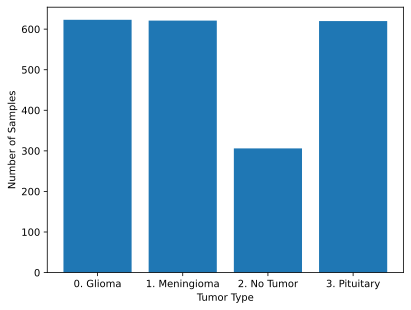

In [8]:
fig, ax = plt.subplots()

tumor_types = ['0. Glioma', '1. Meningioma', '2. No Tumor', '3. Pituitary']

ax.bar(tumor_types, train_data_class_counts)

ax.set_ylabel('Number of Samples')
ax.set_xlabel('Tumor Type')

plt.show()

In [9]:
# Calculate the 0.25 inverse ratios of samples for each of the classes in the training set,
# which could be used as weights for cross entropy loss
train_data_class_inv_ratio = [0.25/(count/len(train_Dataset)) for count in train_data_class_counts]
train_data_class_inv_ratio

[0.8707865168539326, 0.8735909822866345, 1.772875816993464, 0.875]

In [17]:
([round(0.25/(count/len(train_Dataset)), ndigits=3) for count in train_data_class_counts])

[0.871, 0.874, 1.773, 0.875]

Show example of original MRI image, and MRI image after vertical and horizontal edge detections

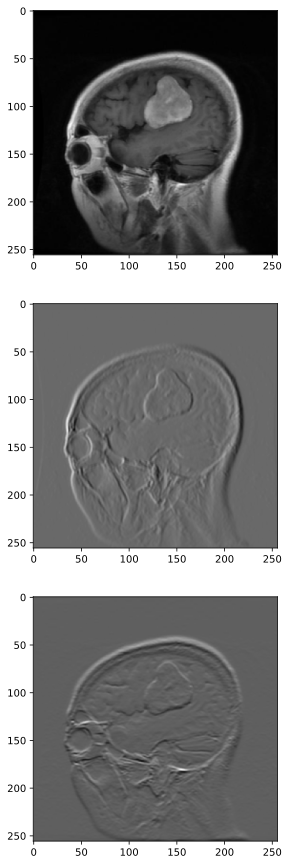

In [10]:
fig,ax = plt.subplots(3,1,figsize=(5,15))
ax[0].imshow(train_Dataset[10][0][0].detach(),cmap='gray')
ax[1].imshow(train_Dataset[10][0][1].detach(),cmap='gray')
ax[2].imshow(train_Dataset[10][0][2].detach(),cmap='gray')


## Create CNN Model for Brain MRI Image Classification

In [7]:
# global variable for input dimension of CNN model, same as the shape of the image tensors
CONV_NET_INPUT_UNIT = 256

In [8]:
class brainMRIConvNet(nn.Module):
    def __init__(self, conv_out_channels: Union[int, List[int]], k_sizes: Union[int, List[int]], 
                 strides: Union[int, List[int]], paddings: Union[int, List[int]], 
                 maxpool_k_sizes: Union[int, List[int]], fc1_out_unit: int):
        super().__init__()
        
        if type(conv_out_channels)==int:
            conv_out_channels = [conv_out_channels]*2
        
        if type(k_sizes)==int:
            k_sizes = [k_sizes]*2
        
        if type(strides)==int:
            strides = [strides]*2
            
        if type(paddings)==int:
            paddings = [paddings]*2
            
        if type(maxpool_k_sizes)==int:
            maxpool_k_sizes = [maxpool_k_sizes]*2
        self.maxpool_k_sizes = maxpool_k_sizes
            
        # convolution layers
        self.conv1 = nn.Conv2d(3,conv_out_channels[0],kernel_size=k_sizes[0],stride=strides[0],padding=paddings[0])
        conv1_out_unit = np.floor((np.floor( (CONV_NET_INPUT_UNIT+2*paddings[0]-k_sizes[0])/strides[0] )+1)/maxpool_k_sizes[0])
        print("First convolution layer output size: %d"%conv1_out_unit)
        # 2D batch normalization for convolutional layer 1
        self.conv_b_norm1 = nn.BatchNorm2d(conv_out_channels[0])
        
        self.conv2 = nn.Conv2d(conv_out_channels[0],conv_out_channels[1],kernel_size=k_sizes[1],
                               stride=strides[1],padding=paddings[1])
        conv2_out_unit = np.floor((np.floor( (conv1_out_unit+2*paddings[1]-k_sizes[1])/strides[1] )+1)/maxpool_k_sizes[1])
        print("Second convolution layer output size: %d"%conv2_out_unit)
        # 2D batch normalization for convolutional layer 2
        self.conv_b_norm2 = nn.BatchNorm2d(conv_out_channels[1])

        # compute the number of input dimensions for FClayer (number of outputs of conv2)
        #expectSize = np.floor( (5+2*0-1)/1 ) + 1 # fc1 layer has no padding or kernel, so set to 0/1
        fc1_in_unit = conv_out_channels[1]*int(conv2_out_unit**2)
        print("First FC linear layer input size: %d"%fc1_in_unit)
      
        ### fully-connected layer
        self.fc1 = nn.Linear(fc1_in_unit,fc1_out_unit)

        ### output layer
        self.out = nn.Linear(fc1_out_unit,4)
        

    # forward pass
    def forward(self,x):

        # convolution -> maxpool -> relu
        x = F.leaky_relu(F.max_pool2d(self.conv1(x),self.maxpool_k_sizes[0]))
        x = self.conv_b_norm1(x)

        # and again: convolution -> maxpool -> relu
        x = F.leaky_relu(F.max_pool2d(self.conv2(x),self.maxpool_k_sizes[1]))
        x = self.conv_b_norm2(x)

        # reshape/flatten the tensor for linear layer
        fc1_in_unit = x.shape.numel()/x.shape[0]
        x = x.view(-1,int(fc1_in_unit))
      
        # linear layers
        x = F.leaky_relu(self.fc1(x))
        x = self.out(x)

        return x

## Create a custom loss function (Focal Loss) 

In [9]:
class customFocalLoss(nn.Module):
    def __init__(self):
        super().__init__()
      
    def forward(self,convnet_out,labels):
        ce_loss = F.cross_entropy(convnet_out, labels, reduction='none') # important to add reduction='none' to keep per-batch-item loss
        p_t = torch.exp(-ce_loss)
        #print(p_t)
        focal_loss = ((1-p_t)**2 * ce_loss).mean() 
        return focal_loss

In [10]:
def trainBrainMRIConvNet(conv_net, train_loader, valid_loader, num_epochs, log_every_n_epoch, 
                         learning_rate=0.001, optimizer=None, loss_func=None):
    # If CUDA is available, use CUDA as device
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

    # Using Stochastic Gradient Descent (SGD) as optimizer and 
    # cross entropy loss (including Softmax) as loss function when there is no input
    if optimizer == None:
        optimizer = torch.optim.SGD(conv_net.parameters(), lr=learning_rate)
    if loss_func == None:
        loss_func = nn.CrossEntropyLoss()
    
    
    # Put model into the device
    conv_net.to(device)
    
    # initialize arrays and lists to record losses and accuracies
    train_losses = torch.zeros(num_epochs)
    valid_losses = torch.zeros(num_epochs)
    train_acc = []
    valid_acc = []

    # Loss function object for validation losses
    valid_loss_func = copy.deepcopy(loss_func)
    # loop over epochs
    for ith_epoch in range(num_epochs):

        # loop over training data batches
        conv_net.train()
        batch_acc  = []
        batch_loss = []
        for step, batch in enumerate(tqdm(train_loader, desc=f'train-{ith_epoch}', disable=False)):
            X, y = (batch[0], batch[1])
            # put data into device
            X = X.to(device)
            y = y.to(device)
            
            #y = torch.squeeze(y)
            # forward pass and loss
            net_out = conv_net(X)
            loss = loss_func(net_out,y)
            #print(loss)
            # backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # loss from this batch
            batch_loss.append(loss.item())

            # compute accuracy
            #print(torch.argmax(net_out,axis=1))
            matches = torch.argmax(net_out,axis=1) == y     # booleans (false/true)
            matches_num = matches.float()             # convert to numbers (0/1)
            acc_percent = 100*torch.mean(matches_num) # average and x100
            batch_acc.append( acc_percent.cpu() )               # add to list of accuracies
            
            # remove the data from device to save RAM space
            del X
            del y
            gc.collect()
            torch.cuda.empty_cache()
        # end of batch loop

        # now that we've trained through the batches, get their average training accuracy
        train_acc.append( np.mean(batch_acc) )

        # and get average losses across the batches
        train_losses[ith_epoch] = np.mean(batch_loss)

        # perform validation, turn model to evaluation mode
        conv_net.eval()
        # get the next batch of validation features and labels for evaluation.
        X,y = next(iter(valid_loader)) # extract X,y from validation dataloader
        # put data into device
        X = X.to(device)
        y = y.to(device)
        with torch.no_grad(): # deactivates autograd
            net_out = conv_net(X)
            #y = torch.squeeze(y)
            
        # compute and record the validation loss for this epoch
        valid_loss = valid_loss_func(net_out, y)
        valid_losses[ith_epoch] = valid_loss.item()
        
        # compute and record the validation accuracy for this epoch.
        y_hat = torch.argmax(net_out,axis=1)
        valid_acc.append( 100*torch.mean((y_hat==y).float()).cpu() )
        # compute confusioon matrix on the valudation set for the last epoch
        if ith_epoch == num_epochs-1:
            valid_conf_mat = confusion_matrix(y.cpu(),y_hat.cpu())
        # remove the data from device to save RAM space
        del X
        del y
        gc.collect()
        torch.cuda.empty_cache()
        
        # print the accuracies/losses for every log_every_n_epochs
        if ith_epoch % log_every_n_epoch == 1:
            print('Epoch %d, Avg. Loss %.3f, Valid. Loss %.3f, Valid. Acc %.3f, Train Acc %.3f' % (ith_epoch, train_losses[ith_epoch], 
                                                                                                   valid_losses[ith_epoch], valid_acc[-1], 
                                                                                                   train_acc[-1]))

    # end ith_epoch
    
    # Put model back to CPU if it was put on CUDA at the begining of training
    if next(conv_net.parameters()).is_cuda:
        conv_net.to(torch.device("cpu"))
        gc.collect()
        torch.cuda.empty_cache()

    # function output
    return train_acc,valid_acc,train_losses,valid_losses, valid_conf_mat

## Hyper-parameters Experiments

### Experiments with different optimizers

In [12]:
# finding the proper optimizer (SGD with different momentum values, RMSprop with different alpha values, and Adam)
# Set all other hyper-parameters to a fixed values 
learning_rate = 0.005
conv_out_channels = [8,16]
kernel_sizes = [4,2]
strides = [2,1]
paddings = [2,1]
maxpool_k_sizes = 2
fc_nUnit = 512
batch_size = 8
loss_func = customFocalLoss() 
# set number of epochs to 12 which is superfluous
num_of_epochs = 12
log_every_n_epoch = 2

# Define training and validation data loaders with the batch_size
train_loader = DataLoader(train_Dataset,batch_size=batch_size, shuffle=True, drop_last=True)
valid_loader = DataLoader(valid_Dataset,batch_size=valid_Dataset.tensors[0].shape[0])

# Candidate optimizers:
cand_opts = ["SGD 0","SGD 0.9","SGD 0.93","SGD 0.96","RMSprop 0.9", "RMSprop 0.93", "RMSprop 0.96", 'Adam']

# record training accuracies
train_opt_acc = np.zeros((num_of_epochs, len(cand_opts)))
# record validation accuracies
valid_opt_acc = np.zeros((num_of_epochs, len(cand_opts)))

In [13]:
# Loop over different optimizers
for ith_opt in range(len(cand_opts)):
    if ith_opt < 4:
        print('Training with SGD with momentum %s'% cand_opts[ith_opt].replace("SGD ",""))
    elif ith_opt in range(4,7):
        print('Training with RMSprop with alpha %s'% cand_opts[ith_opt].replace("RMSprop ",""))
    else: 
        print('Training with Adam optimizer')

    # Create a candidate brainMRIConvNet model object
    cand_brain_MRI_net = brainMRIConvNet(conv_out_channels, k_sizes=kernel_sizes, strides=strides, paddings=paddings,
                                         maxpool_k_sizes=maxpool_k_sizes, fc1_out_unit=fc_nUnit)
    # Define optimizer
    if 'Adam' in cand_opts[ith_opt]:
        optimizer = torch.optim.Adam(cand_brain_MRI_net.parameters(), lr=0.0005)
    
    elif 'SGD' in cand_opts[ith_opt]:
        optimizer = torch.optim.SGD(cand_brain_MRI_net.parameters(), lr=learning_rate, 
                                    momentum=float(cand_opts[ith_opt].replace("SGD ","")))
    elif 'RMSprop' in cand_opts[ith_opt]:
        optimizer = torch.optim.RMSprop(cand_brain_MRI_net.parameters(), lr=learning_rate, 
                                        alpha=float(cand_opts[ith_opt].replace("RMSprop ","")))
    # Train the model and store the validation results.
    train_acc, valid_acc, _, _, _= trainBrainMRIConvNet(cand_brain_MRI_net, train_loader, valid_loader,
                                                        num_of_epochs, log_every_n_epoch,None,optimizer,loss_func)

    # Store training and testing accuracy results
    train_opt_acc[:, ith_opt] = train_acc
    valid_opt_acc[:, ith_opt] = valid_acc

Training with SGD with momentum 0
First convolution layer output size: 64
Second convolution layer output size: 32
First FC linear layer input size: 16384


train-1: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:45<00:00,  5.92it/s]


Epoch 1, Avg. Loss 0.084, Valid. Loss 0.178, Valid. Acc 87.742, Train Acc 92.343


train-3: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:45<00:00,  5.93it/s]


Epoch 3, Avg. Loss 0.014, Valid. Loss 0.171, Valid. Acc 87.097, Train Acc 99.400


train-5: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:44<00:00,  6.09it/s]


Epoch 5, Avg. Loss 0.005, Valid. Loss 0.179, Valid. Acc 87.097, Train Acc 100.000


train-7: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:46<00:00,  5.86it/s]


Epoch 7, Avg. Loss 0.003, Valid. Loss 0.182, Valid. Acc 87.097, Train Acc 100.000


train-9: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:45<00:00,  6.00it/s]


Epoch 9, Avg. Loss 0.002, Valid. Loss 0.185, Valid. Acc 86.667, Train Acc 100.000


train-11: 100%|██████████████████████████████████████████████████████████████████████| 271/271 [00:44<00:00,  6.05it/s]


Epoch 11, Avg. Loss 0.001, Valid. Loss 0.193, Valid. Acc 86.022, Train Acc 100.000
Training with SGD with momentum 0.9
First convolution layer output size: 64
Second convolution layer output size: 32
First FC linear layer input size: 16384


train-1: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:48<00:00,  5.61it/s]


Epoch 1, Avg. Loss 0.208, Valid. Loss 0.211, Valid. Acc 82.796, Train Acc 80.950


train-3: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:48<00:00,  5.58it/s]


Epoch 3, Avg. Loss 0.023, Valid. Loss 0.220, Valid. Acc 84.946, Train Acc 97.371


train-5: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:49<00:00,  5.47it/s]


Epoch 5, Avg. Loss 0.000, Valid. Loss 0.215, Valid. Acc 88.387, Train Acc 100.000


train-7: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:48<00:00,  5.58it/s]


Epoch 7, Avg. Loss 0.000, Valid. Loss 0.209, Valid. Acc 88.602, Train Acc 100.000


train-9: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:49<00:00,  5.43it/s]


Epoch 9, Avg. Loss 0.000, Valid. Loss 0.215, Valid. Acc 88.817, Train Acc 100.000


train-11: 100%|██████████████████████████████████████████████████████████████████████| 271/271 [00:48<00:00,  5.58it/s]


Epoch 11, Avg. Loss 0.000, Valid. Loss 0.213, Valid. Acc 88.387, Train Acc 100.000
Training with SGD with momentum 0.93
First convolution layer output size: 64
Second convolution layer output size: 32
First FC linear layer input size: 16384


train-1: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:49<00:00,  5.53it/s]


Epoch 1, Avg. Loss 0.275, Valid. Loss 0.254, Valid. Acc 75.914, Train Acc 74.723


train-3: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:48<00:00,  5.54it/s]


Epoch 3, Avg. Loss 0.083, Valid. Loss 0.218, Valid. Acc 82.581, Train Acc 91.006


train-5: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:48<00:00,  5.58it/s]


Epoch 5, Avg. Loss 0.009, Valid. Loss 0.218, Valid. Acc 86.022, Train Acc 99.031


train-7: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:49<00:00,  5.44it/s]


Epoch 7, Avg. Loss 0.001, Valid. Loss 0.266, Valid. Acc 85.806, Train Acc 100.000


train-9: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:49<00:00,  5.50it/s]


Epoch 9, Avg. Loss 0.000, Valid. Loss 0.270, Valid. Acc 84.086, Train Acc 100.000


train-11: 100%|██████████████████████████████████████████████████████████████████████| 271/271 [00:48<00:00,  5.55it/s]


Epoch 11, Avg. Loss 0.000, Valid. Loss 0.277, Valid. Acc 86.882, Train Acc 100.000
Training with SGD with momentum 0.96
First convolution layer output size: 64
Second convolution layer output size: 32
First FC linear layer input size: 16384


train-1: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:49<00:00,  5.53it/s]


Epoch 1, Avg. Loss 0.227, Valid. Loss 0.241, Valid. Acc 77.634, Train Acc 76.568


train-3: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:48<00:00,  5.62it/s]


Epoch 3, Avg. Loss 0.078, Valid. Loss 0.318, Valid. Acc 79.570, Train Acc 91.513


train-5: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:49<00:00,  5.43it/s]


Epoch 5, Avg. Loss 0.039, Valid. Loss 0.308, Valid. Acc 81.720, Train Acc 95.526


train-7: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:48<00:00,  5.57it/s]


Epoch 7, Avg. Loss 0.023, Valid. Loss 0.239, Valid. Acc 85.806, Train Acc 97.924


train-9: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:48<00:00,  5.56it/s]


Epoch 9, Avg. Loss 0.016, Valid. Loss 0.397, Valid. Acc 86.022, Train Acc 98.662


train-11: 100%|██████████████████████████████████████████████████████████████████████| 271/271 [00:48<00:00,  5.56it/s]


Epoch 11, Avg. Loss 0.009, Valid. Loss 0.334, Valid. Acc 86.452, Train Acc 99.170
Training with RMSprop with alpha 0.9
First convolution layer output size: 64
Second convolution layer output size: 32
First FC linear layer input size: 16384


train-1: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:50<00:00,  5.37it/s]


Epoch 1, Avg. Loss 0.444, Valid. Loss 0.558, Valid. Acc 66.237, Train Acc 65.729


train-3: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:52<00:00,  5.13it/s]


Epoch 3, Avg. Loss 0.240, Valid. Loss 0.720, Valid. Acc 75.269, Train Acc 82.518


train-5: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:52<00:00,  5.20it/s]


Epoch 5, Avg. Loss 0.118, Valid. Loss 0.515, Valid. Acc 79.570, Train Acc 93.450


train-7: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:53<00:00,  5.05it/s]


Epoch 7, Avg. Loss 0.083, Valid. Loss 1.131, Valid. Acc 81.290, Train Acc 96.541


train-9: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:52<00:00,  5.12it/s]


Epoch 9, Avg. Loss 0.090, Valid. Loss 1.124, Valid. Acc 85.591, Train Acc 97.371


train-11: 100%|██████████████████████████████████████████████████████████████████████| 271/271 [00:53<00:00,  5.05it/s]


Epoch 11, Avg. Loss 0.074, Valid. Loss 1.478, Valid. Acc 86.452, Train Acc 98.432
Training with RMSprop with alpha 0.93
First convolution layer output size: 64
Second convolution layer output size: 32
First FC linear layer input size: 16384


train-1: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:52<00:00,  5.20it/s]


Epoch 1, Avg. Loss 0.578, Valid. Loss 0.638, Valid. Acc 68.172, Train Acc 65.268


train-3: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:51<00:00,  5.27it/s]


Epoch 3, Avg. Loss 0.207, Valid. Loss 0.300, Valid. Acc 79.355, Train Acc 83.441


train-5: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:52<00:00,  5.14it/s]


Epoch 5, Avg. Loss 0.136, Valid. Loss 0.500, Valid. Acc 81.075, Train Acc 92.851


train-7: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:52<00:00,  5.19it/s]


Epoch 7, Avg. Loss 0.121, Valid. Loss 1.224, Valid. Acc 83.656, Train Acc 96.264


train-9: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:52<00:00,  5.13it/s]


Epoch 9, Avg. Loss 0.107, Valid. Loss 1.328, Valid. Acc 81.935, Train Acc 97.648


train-11: 100%|██████████████████████████████████████████████████████████████████████| 271/271 [00:51<00:00,  5.23it/s]


Epoch 11, Avg. Loss 0.070, Valid. Loss 1.229, Valid. Acc 86.882, Train Acc 98.478
Training with RMSprop with alpha 0.96
First convolution layer output size: 64
Second convolution layer output size: 32
First FC linear layer input size: 16384


train-1: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:53<00:00,  5.10it/s]


Epoch 1, Avg. Loss 0.832, Valid. Loss 0.411, Valid. Acc 62.796, Train Acc 64.253


train-3: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:52<00:00,  5.19it/s]


Epoch 3, Avg. Loss 0.261, Valid. Loss 0.360, Valid. Acc 69.462, Train Acc 81.365


train-5: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:52<00:00,  5.12it/s]


Epoch 5, Avg. Loss 0.143, Valid. Loss 0.418, Valid. Acc 81.720, Train Acc 89.991


train-7: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:51<00:00,  5.23it/s]


Epoch 7, Avg. Loss 0.108, Valid. Loss 0.366, Valid. Acc 83.656, Train Acc 95.203


train-9: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:52<00:00,  5.16it/s]


Epoch 9, Avg. Loss 0.093, Valid. Loss 0.771, Valid. Acc 84.301, Train Acc 96.356


train-11: 100%|██████████████████████████████████████████████████████████████████████| 271/271 [00:52<00:00,  5.15it/s]


Epoch 11, Avg. Loss 0.083, Valid. Loss 0.776, Valid. Acc 81.505, Train Acc 97.325
Training with Adam optimizer
First convolution layer output size: 64
Second convolution layer output size: 32
First FC linear layer input size: 16384


train-1: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:55<00:00,  4.88it/s]


Epoch 1, Avg. Loss 0.065, Valid. Loss 0.229, Valid. Acc 80.430, Train Acc 92.989


train-3: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:55<00:00,  4.85it/s]


Epoch 3, Avg. Loss 0.003, Valid. Loss 0.169, Valid. Acc 88.172, Train Acc 99.815


train-5: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:55<00:00,  4.86it/s]


Epoch 5, Avg. Loss 0.000, Valid. Loss 0.185, Valid. Acc 87.527, Train Acc 100.000


train-7: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:56<00:00,  4.82it/s]


Epoch 7, Avg. Loss 0.000, Valid. Loss 0.195, Valid. Acc 87.312, Train Acc 100.000


train-9: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:56<00:00,  4.79it/s]


Epoch 9, Avg. Loss 0.000, Valid. Loss 0.200, Valid. Acc 87.312, Train Acc 100.000


train-11: 100%|██████████████████████████████████████████████████████████████████████| 271/271 [00:57<00:00,  4.74it/s]


Epoch 11, Avg. Loss 0.000, Valid. Loss 0.208, Valid. Acc 86.882, Train Acc 100.000


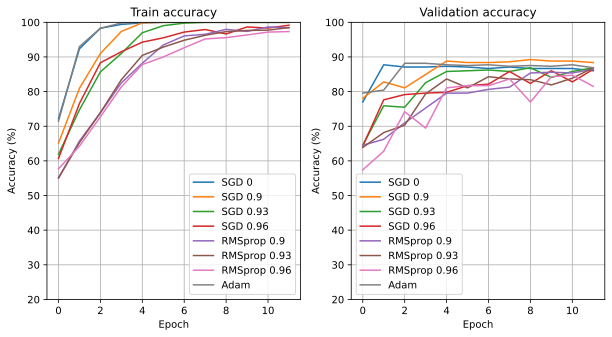

In [14]:
# plot the accuracies against the number of epochs for different optimizers
# Setup the legends to be shown
legends = cand_opts
fig,ax = plt.subplots(1,2,figsize=(10,5))

ax[0].plot(train_opt_acc)
ax[0].set_title('Train accuracy')
ax[1].plot(valid_opt_acc)
ax[1].set_title('Validation accuracy')

# common features
for i in range(2):
    ax[i].legend(legends)
    ax[i].set_xlabel('Epoch')
    ax[i].set_ylabel('Accuracy (%)')
    ax[i].set_ylim([20,100])
    ax[i].grid()

plt.show()

### Experiment with different learning rates

In [11]:
# Use a number of experimens to find the optimal value for learning rate
# For each experiment and each unique value of learning rate, 
# a new model will be created and trained 
num_experiments = 8

# Candidate learning rate values
cand_learning_rates = [0.001, 0.003, 0.005, 0.007, 0.01, 0.03]
# Create an ndarray to store the validation accuracies and losses.
exp_accuracies = np.zeros((num_experiments, len(cand_learning_rates)))
exp_losses = np.zeros((num_experiments, len(cand_learning_rates)))

# Set all other hyper-parameters to a specific value
conv_out_channels = [8,16]
kernel_sizes = [4,2]
strides = [2,1]
paddings = [2,1]
maxpool_k_sizes = 2
fc_nUnit = 512
batch_size = 8
loss_func = customFocalLoss() 
# set number of epochs to 12 which should be superfluous
num_of_epochs = 12
log_every_n_epoch = 2

# Define train and validation data loaders
train_loader = DataLoader(train_Dataset,batch_size=batch_size, shuffle=True, drop_last=True)
valid_loader = DataLoader(valid_Dataset, batch_size=valid_Dataset.tensors[0].shape[0])



In [12]:
# Perform the experiments.
for exp_i in range(num_experiments):
    print('Experiment %d'% exp_i)
    for j, lr in enumerate(cand_learning_rates):
        print('Training with learning rate %.4f'% lr)
        # Create a candidate brainMRIConvNet model object
        cand_brain_MRI_net = brainMRIConvNet(conv_out_channels, k_sizes=kernel_sizes, strides=strides, paddings=paddings,
                                             maxpool_k_sizes=maxpool_k_sizes, fc1_out_unit=fc_nUnit)
        
        # Define optimizer according to the result of previous experiment, with the current candidate learning rate 
        optimizer = torch.optim.SGD(cand_brain_MRI_net.parameters(), lr=lr,momentum=0.9)
        
        # Train the candidate brainMRIConvNet model using the training function.
        _, valid_acc, _, valid_losses, _= trainBrainMRIConvNet(cand_brain_MRI_net, train_loader, valid_loader,
                                                               num_of_epochs, log_every_n_epoch,None,optimizer,loss_func)

        # Record the average validation accuracy for the last 3 epochs
        exp_accuracies[exp_i, j] = np.mean(valid_acc[len(valid_acc)-3:])
        # Record the average validation loss for the last 3 epochs
        exp_losses[exp_i, j] = np.mean(list(valid_losses[len(valid_losses)-3:].detach()))

Experiment 0
Training with learning rate 0.0010
First convolution layer output size: 64
Second convolution layer output size: 32
First FC linear layer input size: 16384


train-1: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:47<00:00,  5.74it/s]


Epoch 1, Avg. Loss 0.064, Valid. Loss 0.197, Valid. Acc 84.516, Train Acc 93.819


train-3: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:48<00:00,  5.62it/s]


Epoch 3, Avg. Loss 0.004, Valid. Loss 0.203, Valid. Acc 86.022, Train Acc 99.954


train-5: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:47<00:00,  5.65it/s]


Epoch 5, Avg. Loss 0.002, Valid. Loss 0.206, Valid. Acc 85.591, Train Acc 100.000


train-7: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:48<00:00,  5.57it/s]


Epoch 7, Avg. Loss 0.001, Valid. Loss 0.208, Valid. Acc 85.591, Train Acc 100.000


train-9: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:46<00:00,  5.80it/s]


Epoch 9, Avg. Loss 0.001, Valid. Loss 0.217, Valid. Acc 85.591, Train Acc 100.000


train-11: 100%|██████████████████████████████████████████████████████████████████████| 271/271 [00:48<00:00,  5.63it/s]


Epoch 11, Avg. Loss 0.000, Valid. Loss 0.222, Valid. Acc 85.376, Train Acc 100.000
Training with learning rate 0.0030
First convolution layer output size: 64
Second convolution layer output size: 32
First FC linear layer input size: 16384


train-1: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:48<00:00,  5.58it/s]


Epoch 1, Avg. Loss 0.085, Valid. Loss 0.158, Valid. Acc 86.882, Train Acc 90.406


train-3: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:48<00:00,  5.57it/s]


Epoch 3, Avg. Loss 0.002, Valid. Loss 0.172, Valid. Acc 88.172, Train Acc 99.862


train-5: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:47<00:00,  5.67it/s]


Epoch 5, Avg. Loss 0.000, Valid. Loss 0.181, Valid. Acc 88.817, Train Acc 100.000


train-7: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:47<00:00,  5.65it/s]


Epoch 7, Avg. Loss 0.000, Valid. Loss 0.183, Valid. Acc 88.817, Train Acc 100.000


train-9: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:48<00:00,  5.59it/s]


Epoch 9, Avg. Loss 0.000, Valid. Loss 0.189, Valid. Acc 88.817, Train Acc 100.000


train-11: 100%|██████████████████████████████████████████████████████████████████████| 271/271 [00:50<00:00,  5.42it/s]


Epoch 11, Avg. Loss 0.000, Valid. Loss 0.187, Valid. Acc 89.677, Train Acc 100.000
Training with learning rate 0.0050
First convolution layer output size: 64
Second convolution layer output size: 32
First FC linear layer input size: 16384


train-1: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:45<00:00,  5.91it/s]


Epoch 1, Avg. Loss 0.148, Valid. Loss 0.221, Valid. Acc 82.796, Train Acc 85.148


train-3: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:49<00:00,  5.46it/s]


Epoch 3, Avg. Loss 0.011, Valid. Loss 0.172, Valid. Acc 86.022, Train Acc 99.031


train-5: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:49<00:00,  5.52it/s]


Epoch 5, Avg. Loss 0.000, Valid. Loss 0.183, Valid. Acc 87.312, Train Acc 100.000


train-7: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:49<00:00,  5.52it/s]


Epoch 7, Avg. Loss 0.000, Valid. Loss 0.192, Valid. Acc 87.097, Train Acc 100.000


train-9: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:49<00:00,  5.47it/s]


Epoch 9, Avg. Loss 0.000, Valid. Loss 0.189, Valid. Acc 87.312, Train Acc 100.000


train-11: 100%|██████████████████████████████████████████████████████████████████████| 271/271 [00:49<00:00,  5.49it/s]


Epoch 11, Avg. Loss 0.000, Valid. Loss 0.190, Valid. Acc 87.097, Train Acc 100.000
Training with learning rate 0.0070
First convolution layer output size: 64
Second convolution layer output size: 32
First FC linear layer input size: 16384


train-1: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:49<00:00,  5.50it/s]


Epoch 1, Avg. Loss 0.200, Valid. Loss 0.303, Valid. Acc 70.108, Train Acc 82.149


train-3: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:48<00:00,  5.55it/s]


Epoch 3, Avg. Loss 0.026, Valid. Loss 0.162, Valid. Acc 88.817, Train Acc 97.232


train-5: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:49<00:00,  5.48it/s]


Epoch 5, Avg. Loss 0.000, Valid. Loss 0.139, Valid. Acc 90.538, Train Acc 100.000


train-7: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:49<00:00,  5.42it/s]


Epoch 7, Avg. Loss 0.000, Valid. Loss 0.144, Valid. Acc 90.538, Train Acc 100.000


train-9: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:48<00:00,  5.57it/s]


Epoch 9, Avg. Loss 0.000, Valid. Loss 0.140, Valid. Acc 90.753, Train Acc 100.000


train-11: 100%|██████████████████████████████████████████████████████████████████████| 271/271 [00:49<00:00,  5.50it/s]


Epoch 11, Avg. Loss 0.000, Valid. Loss 0.141, Valid. Acc 90.538, Train Acc 100.000
Training with learning rate 0.0100
First convolution layer output size: 64
Second convolution layer output size: 32
First FC linear layer input size: 16384


train-1: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:48<00:00,  5.59it/s]


Epoch 1, Avg. Loss 0.197, Valid. Loss 0.182, Valid. Acc 84.731, Train Acc 80.812


train-3: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:49<00:00,  5.53it/s]


Epoch 3, Avg. Loss 0.014, Valid. Loss 0.202, Valid. Acc 87.097, Train Acc 98.386


train-5: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:49<00:00,  5.49it/s]


Epoch 5, Avg. Loss 0.000, Valid. Loss 0.183, Valid. Acc 89.032, Train Acc 100.000


train-7: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:48<00:00,  5.62it/s]


Epoch 7, Avg. Loss 0.000, Valid. Loss 0.189, Valid. Acc 89.247, Train Acc 100.000


train-9: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:48<00:00,  5.63it/s]


Epoch 9, Avg. Loss 0.000, Valid. Loss 0.198, Valid. Acc 89.032, Train Acc 100.000


train-11: 100%|██████████████████████████████████████████████████████████████████████| 271/271 [00:48<00:00,  5.60it/s]


Epoch 11, Avg. Loss 0.000, Valid. Loss 0.197, Valid. Acc 89.247, Train Acc 100.000
Training with learning rate 0.0300
First convolution layer output size: 64
Second convolution layer output size: 32
First FC linear layer input size: 16384


train-1: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:49<00:00,  5.48it/s]


Epoch 1, Avg. Loss nan, Valid. Loss nan, Valid. Acc 31.183, Train Acc 28.736


train-3: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:49<00:00,  5.51it/s]


Epoch 3, Avg. Loss nan, Valid. Loss nan, Valid. Acc 31.183, Train Acc 28.690


train-5: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:48<00:00,  5.60it/s]


Epoch 5, Avg. Loss nan, Valid. Loss nan, Valid. Acc 31.183, Train Acc 28.736


train-7: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:49<00:00,  5.47it/s]


Epoch 7, Avg. Loss nan, Valid. Loss nan, Valid. Acc 31.183, Train Acc 28.736


train-9: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:47<00:00,  5.68it/s]


Epoch 9, Avg. Loss nan, Valid. Loss nan, Valid. Acc 31.183, Train Acc 28.736


train-11: 100%|██████████████████████████████████████████████████████████████████████| 271/271 [00:49<00:00,  5.50it/s]


Epoch 11, Avg. Loss nan, Valid. Loss nan, Valid. Acc 31.183, Train Acc 28.690
Experiment 1
Training with learning rate 0.0010
First convolution layer output size: 64
Second convolution layer output size: 32
First FC linear layer input size: 16384


train-1: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:48<00:00,  5.56it/s]


Epoch 1, Avg. Loss 0.065, Valid. Loss 0.172, Valid. Acc 85.591, Train Acc 93.958


train-3: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:48<00:00,  5.58it/s]


Epoch 3, Avg. Loss 0.005, Valid. Loss 0.166, Valid. Acc 88.387, Train Acc 99.954


train-5: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:49<00:00,  5.48it/s]


Epoch 5, Avg. Loss 0.002, Valid. Loss 0.174, Valid. Acc 88.387, Train Acc 100.000


train-7: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:48<00:00,  5.64it/s]


Epoch 7, Avg. Loss 0.001, Valid. Loss 0.178, Valid. Acc 89.247, Train Acc 100.000


train-9: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:49<00:00,  5.48it/s]


Epoch 9, Avg. Loss 0.001, Valid. Loss 0.182, Valid. Acc 88.172, Train Acc 100.000


train-11: 100%|██████████████████████████████████████████████████████████████████████| 271/271 [00:48<00:00,  5.57it/s]


Epoch 11, Avg. Loss 0.001, Valid. Loss 0.181, Valid. Acc 88.172, Train Acc 100.000
Training with learning rate 0.0030
First convolution layer output size: 64
Second convolution layer output size: 32
First FC linear layer input size: 16384


train-1: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:48<00:00,  5.57it/s]


Epoch 1, Avg. Loss 0.110, Valid. Loss 0.192, Valid. Acc 83.871, Train Acc 87.592


train-3: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:50<00:00,  5.41it/s]


Epoch 3, Avg. Loss 0.011, Valid. Loss 0.211, Valid. Acc 85.161, Train Acc 99.124


train-5: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:48<00:00,  5.59it/s]


Epoch 5, Avg. Loss 0.001, Valid. Loss 0.191, Valid. Acc 88.172, Train Acc 99.954


train-7: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:49<00:00,  5.47it/s]


Epoch 7, Avg. Loss 0.000, Valid. Loss 0.198, Valid. Acc 87.742, Train Acc 100.000


train-9: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:49<00:00,  5.48it/s]


Epoch 9, Avg. Loss 0.000, Valid. Loss 0.200, Valid. Acc 87.527, Train Acc 100.000


train-11: 100%|██████████████████████████████████████████████████████████████████████| 271/271 [00:49<00:00,  5.42it/s]


Epoch 11, Avg. Loss 0.000, Valid. Loss 0.202, Valid. Acc 87.527, Train Acc 100.000
Training with learning rate 0.0050
First convolution layer output size: 64
Second convolution layer output size: 32
First FC linear layer input size: 16384


train-1: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:48<00:00,  5.61it/s]


Epoch 1, Avg. Loss 0.200, Valid. Loss 0.232, Valid. Acc 77.634, Train Acc 79.290


train-3: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:48<00:00,  5.63it/s]


Epoch 3, Avg. Loss 0.040, Valid. Loss 0.273, Valid. Acc 83.871, Train Acc 95.249


train-5: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:49<00:00,  5.45it/s]


Epoch 5, Avg. Loss 0.002, Valid. Loss 0.217, Valid. Acc 87.312, Train Acc 99.908


train-7: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:46<00:00,  5.79it/s]


Epoch 7, Avg. Loss 0.000, Valid. Loss 0.229, Valid. Acc 88.172, Train Acc 100.000


train-9: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:48<00:00,  5.63it/s]


Epoch 9, Avg. Loss 0.000, Valid. Loss 0.235, Valid. Acc 87.742, Train Acc 100.000


train-11: 100%|██████████████████████████████████████████████████████████████████████| 271/271 [00:47<00:00,  5.76it/s]


Epoch 11, Avg. Loss 0.000, Valid. Loss 0.233, Valid. Acc 87.742, Train Acc 100.000
Training with learning rate 0.0070
First convolution layer output size: 64
Second convolution layer output size: 32
First FC linear layer input size: 16384


train-1: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:47<00:00,  5.69it/s]


Epoch 1, Avg. Loss 0.215, Valid. Loss 0.232, Valid. Acc 82.151, Train Acc 79.336


train-3: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:48<00:00,  5.54it/s]


Epoch 3, Avg. Loss 0.018, Valid. Loss 0.198, Valid. Acc 85.376, Train Acc 98.201


train-5: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:47<00:00,  5.69it/s]


Epoch 5, Avg. Loss 0.001, Valid. Loss 0.205, Valid. Acc 87.527, Train Acc 99.862


train-7: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:48<00:00,  5.55it/s]


Epoch 7, Avg. Loss 0.000, Valid. Loss 0.211, Valid. Acc 88.602, Train Acc 100.000


train-9: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:48<00:00,  5.58it/s]


Epoch 9, Avg. Loss 0.000, Valid. Loss 0.216, Valid. Acc 88.387, Train Acc 100.000


train-11: 100%|██████████████████████████████████████████████████████████████████████| 271/271 [00:48<00:00,  5.54it/s]


Epoch 11, Avg. Loss 0.000, Valid. Loss 0.219, Valid. Acc 87.742, Train Acc 100.000
Training with learning rate 0.0100
First convolution layer output size: 64
Second convolution layer output size: 32
First FC linear layer input size: 16384


train-1: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:49<00:00,  5.46it/s]


Epoch 1, Avg. Loss 0.295, Valid. Loss 0.248, Valid. Acc 73.978, Train Acc 71.771


train-3: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:47<00:00,  5.68it/s]


Epoch 3, Avg. Loss 0.042, Valid. Loss 0.199, Valid. Acc 81.720, Train Acc 95.480


train-5: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:49<00:00,  5.47it/s]


Epoch 5, Avg. Loss 0.010, Valid. Loss 0.230, Valid. Acc 86.237, Train Acc 98.893


train-7: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:48<00:00,  5.64it/s]


Epoch 7, Avg. Loss 0.003, Valid. Loss 0.205, Valid. Acc 88.602, Train Acc 99.539


train-9: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:49<00:00,  5.43it/s]


Epoch 9, Avg. Loss 0.000, Valid. Loss 0.197, Valid. Acc 88.817, Train Acc 100.000


train-11: 100%|██████████████████████████████████████████████████████████████████████| 271/271 [00:48<00:00,  5.53it/s]


Epoch 11, Avg. Loss 0.000, Valid. Loss 0.200, Valid. Acc 89.247, Train Acc 100.000
Training with learning rate 0.0300
First convolution layer output size: 64
Second convolution layer output size: 32
First FC linear layer input size: 16384


train-1: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:48<00:00,  5.56it/s]


Epoch 1, Avg. Loss nan, Valid. Loss nan, Valid. Acc 31.183, Train Acc 28.736


train-3: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:49<00:00,  5.46it/s]


Epoch 3, Avg. Loss nan, Valid. Loss nan, Valid. Acc 31.183, Train Acc 28.644


train-5: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:49<00:00,  5.53it/s]


Epoch 5, Avg. Loss nan, Valid. Loss nan, Valid. Acc 31.183, Train Acc 28.736


train-7: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:50<00:00,  5.41it/s]


Epoch 7, Avg. Loss nan, Valid. Loss nan, Valid. Acc 31.183, Train Acc 28.736


train-9: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:48<00:00,  5.56it/s]


Epoch 9, Avg. Loss nan, Valid. Loss nan, Valid. Acc 31.183, Train Acc 28.736


train-11: 100%|██████████████████████████████████████████████████████████████████████| 271/271 [00:48<00:00,  5.55it/s]


Epoch 11, Avg. Loss nan, Valid. Loss nan, Valid. Acc 31.183, Train Acc 28.736
Experiment 2
Training with learning rate 0.0010
First convolution layer output size: 64
Second convolution layer output size: 32
First FC linear layer input size: 16384


train-1: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:49<00:00,  5.50it/s]


Epoch 1, Avg. Loss 0.069, Valid. Loss 0.178, Valid. Acc 84.516, Train Acc 93.450


train-3: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:47<00:00,  5.65it/s]


Epoch 3, Avg. Loss 0.005, Valid. Loss 0.179, Valid. Acc 86.237, Train Acc 99.908


train-5: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:48<00:00,  5.59it/s]


Epoch 5, Avg. Loss 0.002, Valid. Loss 0.186, Valid. Acc 86.882, Train Acc 100.000


train-7: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:48<00:00,  5.56it/s]


Epoch 7, Avg. Loss 0.001, Valid. Loss 0.193, Valid. Acc 86.667, Train Acc 100.000


train-9: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:49<00:00,  5.45it/s]


Epoch 9, Avg. Loss 0.001, Valid. Loss 0.199, Valid. Acc 87.097, Train Acc 100.000


train-11: 100%|██████████████████████████████████████████████████████████████████████| 271/271 [00:47<00:00,  5.66it/s]


Epoch 11, Avg. Loss 0.001, Valid. Loss 0.197, Valid. Acc 86.882, Train Acc 100.000
Training with learning rate 0.0030
First convolution layer output size: 64
Second convolution layer output size: 32
First FC linear layer input size: 16384


train-1: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:47<00:00,  5.67it/s]


Epoch 1, Avg. Loss 0.092, Valid. Loss 0.191, Valid. Acc 82.366, Train Acc 89.576


train-3: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:49<00:00,  5.50it/s]


Epoch 3, Avg. Loss 0.006, Valid. Loss 0.206, Valid. Acc 88.387, Train Acc 99.354


train-5: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:48<00:00,  5.60it/s]


Epoch 5, Avg. Loss 0.000, Valid. Loss 0.196, Valid. Acc 87.097, Train Acc 100.000


train-7: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:48<00:00,  5.59it/s]


Epoch 7, Avg. Loss 0.000, Valid. Loss 0.206, Valid. Acc 87.527, Train Acc 100.000


train-9: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:48<00:00,  5.57it/s]


Epoch 9, Avg. Loss 0.000, Valid. Loss 0.211, Valid. Acc 87.527, Train Acc 100.000


train-11: 100%|██████████████████████████████████████████████████████████████████████| 271/271 [00:47<00:00,  5.65it/s]


Epoch 11, Avg. Loss 0.000, Valid. Loss 0.214, Valid. Acc 87.527, Train Acc 100.000
Training with learning rate 0.0050
First convolution layer output size: 64
Second convolution layer output size: 32
First FC linear layer input size: 16384


train-1: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:48<00:00,  5.57it/s]


Epoch 1, Avg. Loss 0.164, Valid. Loss 0.209, Valid. Acc 81.075, Train Acc 84.548


train-3: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:48<00:00,  5.59it/s]


Epoch 3, Avg. Loss 0.011, Valid. Loss 0.183, Valid. Acc 85.591, Train Acc 98.755


train-5: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:49<00:00,  5.47it/s]


Epoch 5, Avg. Loss 0.004, Valid. Loss 0.170, Valid. Acc 89.462, Train Acc 99.769


train-7: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:47<00:00,  5.69it/s]


Epoch 7, Avg. Loss 0.000, Valid. Loss 0.177, Valid. Acc 89.032, Train Acc 100.000


train-9: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:48<00:00,  5.64it/s]


Epoch 9, Avg. Loss 0.000, Valid. Loss 0.182, Valid. Acc 89.032, Train Acc 100.000


train-11: 100%|██████████████████████████████████████████████████████████████████████| 271/271 [00:49<00:00,  5.52it/s]


Epoch 11, Avg. Loss 0.000, Valid. Loss 0.186, Valid. Acc 88.387, Train Acc 100.000
Training with learning rate 0.0070
First convolution layer output size: 64
Second convolution layer output size: 32
First FC linear layer input size: 16384


train-1: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:48<00:00,  5.59it/s]


Epoch 1, Avg. Loss 0.314, Valid. Loss 0.385, Valid. Acc 71.613, Train Acc 70.526


train-3: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:49<00:00,  5.49it/s]


Epoch 3, Avg. Loss 0.065, Valid. Loss 0.267, Valid. Acc 81.935, Train Acc 93.404


train-5: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:48<00:00,  5.55it/s]


Epoch 5, Avg. Loss 0.013, Valid. Loss 0.261, Valid. Acc 87.527, Train Acc 98.939


train-7: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:48<00:00,  5.55it/s]


Epoch 7, Avg. Loss 0.001, Valid. Loss 0.239, Valid. Acc 88.387, Train Acc 99.954


train-9: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:49<00:00,  5.50it/s]


Epoch 9, Avg. Loss 0.001, Valid. Loss 0.240, Valid. Acc 87.957, Train Acc 99.954


train-11: 100%|██████████████████████████████████████████████████████████████████████| 271/271 [00:47<00:00,  5.67it/s]


Epoch 11, Avg. Loss 0.000, Valid. Loss 0.248, Valid. Acc 88.817, Train Acc 100.000
Training with learning rate 0.0100
First convolution layer output size: 64
Second convolution layer output size: 32
First FC linear layer input size: 16384


train-1: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:49<00:00,  5.51it/s]


Epoch 1, Avg. Loss 0.270, Valid. Loss 0.248, Valid. Acc 74.194, Train Acc 72.325


train-3: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:48<00:00,  5.64it/s]


Epoch 3, Avg. Loss 0.054, Valid. Loss 0.217, Valid. Acc 80.000, Train Acc 93.819


train-5: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:41<00:00,  6.48it/s]


Epoch 5, Avg. Loss 0.006, Valid. Loss 0.188, Valid. Acc 86.452, Train Acc 99.631


train-7: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:38<00:00,  6.97it/s]


Epoch 7, Avg. Loss 0.000, Valid. Loss 0.198, Valid. Acc 88.172, Train Acc 100.000


train-9: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:39<00:00,  6.85it/s]


Epoch 9, Avg. Loss 0.000, Valid. Loss 0.197, Valid. Acc 88.387, Train Acc 100.000


train-11: 100%|██████████████████████████████████████████████████████████████████████| 271/271 [00:42<00:00,  6.36it/s]


Epoch 11, Avg. Loss 0.000, Valid. Loss 0.202, Valid. Acc 88.172, Train Acc 100.000
Training with learning rate 0.0300
First convolution layer output size: 64
Second convolution layer output size: 32
First FC linear layer input size: 16384


train-1: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:47<00:00,  5.66it/s]


Epoch 1, Avg. Loss nan, Valid. Loss nan, Valid. Acc 31.183, Train Acc 28.690


train-3: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:48<00:00,  5.60it/s]


Epoch 3, Avg. Loss nan, Valid. Loss nan, Valid. Acc 31.183, Train Acc 28.736


train-5: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:49<00:00,  5.44it/s]


Epoch 5, Avg. Loss nan, Valid. Loss nan, Valid. Acc 31.183, Train Acc 28.736


train-7: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:42<00:00,  6.43it/s]


Epoch 7, Avg. Loss nan, Valid. Loss nan, Valid. Acc 31.183, Train Acc 28.736


train-9: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:38<00:00,  6.97it/s]


Epoch 9, Avg. Loss nan, Valid. Loss nan, Valid. Acc 31.183, Train Acc 28.736


train-11: 100%|██████████████████████████████████████████████████████████████████████| 271/271 [00:40<00:00,  6.75it/s]


Epoch 11, Avg. Loss nan, Valid. Loss nan, Valid. Acc 31.183, Train Acc 28.736
Experiment 3
Training with learning rate 0.0010
First convolution layer output size: 64
Second convolution layer output size: 32
First FC linear layer input size: 16384


train-1: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:42<00:00,  6.45it/s]


Epoch 1, Avg. Loss 0.077, Valid. Loss 0.171, Valid. Acc 86.237, Train Acc 92.482


train-3: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:46<00:00,  5.77it/s]


Epoch 3, Avg. Loss 0.007, Valid. Loss 0.170, Valid. Acc 87.527, Train Acc 99.815


train-5: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:49<00:00,  5.45it/s]


Epoch 5, Avg. Loss 0.002, Valid. Loss 0.171, Valid. Acc 89.247, Train Acc 100.000


train-7: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:48<00:00,  5.60it/s]


Epoch 7, Avg. Loss 0.001, Valid. Loss 0.175, Valid. Acc 89.677, Train Acc 100.000


train-9: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:49<00:00,  5.49it/s]


Epoch 9, Avg. Loss 0.001, Valid. Loss 0.177, Valid. Acc 89.677, Train Acc 100.000


train-11: 100%|██████████████████████████████████████████████████████████████████████| 271/271 [00:48<00:00,  5.59it/s]


Epoch 11, Avg. Loss 0.001, Valid. Loss 0.179, Valid. Acc 89.247, Train Acc 100.000
Training with learning rate 0.0030
First convolution layer output size: 64
Second convolution layer output size: 32
First FC linear layer input size: 16384


train-1: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:50<00:00,  5.34it/s]


Epoch 1, Avg. Loss 0.124, Valid. Loss 0.208, Valid. Acc 80.430, Train Acc 86.255


train-3: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:49<00:00,  5.49it/s]


Epoch 3, Avg. Loss 0.007, Valid. Loss 0.165, Valid. Acc 88.817, Train Acc 99.400


train-5: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:47<00:00,  5.76it/s]


Epoch 5, Avg. Loss 0.000, Valid. Loss 0.183, Valid. Acc 88.602, Train Acc 100.000


train-7: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:38<00:00,  6.97it/s]


Epoch 7, Avg. Loss 0.000, Valid. Loss 0.191, Valid. Acc 88.172, Train Acc 100.000


train-9: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:39<00:00,  6.94it/s]


Epoch 9, Avg. Loss 0.000, Valid. Loss 0.197, Valid. Acc 88.172, Train Acc 100.000


train-11: 100%|██████████████████████████████████████████████████████████████████████| 271/271 [00:40<00:00,  6.70it/s]


Epoch 11, Avg. Loss 0.000, Valid. Loss 0.200, Valid. Acc 88.602, Train Acc 100.000
Training with learning rate 0.0050
First convolution layer output size: 64
Second convolution layer output size: 32
First FC linear layer input size: 16384


train-1: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:43<00:00,  6.30it/s]


Epoch 1, Avg. Loss 0.139, Valid. Loss 0.205, Valid. Acc 81.505, Train Acc 85.655


train-3: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:49<00:00,  5.46it/s]


Epoch 3, Avg. Loss 0.011, Valid. Loss 0.187, Valid. Acc 85.591, Train Acc 98.662


train-5: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:49<00:00,  5.42it/s]


Epoch 5, Avg. Loss 0.000, Valid. Loss 0.181, Valid. Acc 87.312, Train Acc 100.000


train-7: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:49<00:00,  5.52it/s]


Epoch 7, Avg. Loss 0.000, Valid. Loss 0.188, Valid. Acc 87.312, Train Acc 100.000


train-9: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:49<00:00,  5.48it/s]


Epoch 9, Avg. Loss 0.000, Valid. Loss 0.192, Valid. Acc 87.312, Train Acc 100.000


train-11: 100%|██████████████████████████████████████████████████████████████████████| 271/271 [00:49<00:00,  5.44it/s]


Epoch 11, Avg. Loss 0.000, Valid. Loss 0.195, Valid. Acc 87.527, Train Acc 100.000
Training with learning rate 0.0070
First convolution layer output size: 64
Second convolution layer output size: 32
First FC linear layer input size: 16384


train-1: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:47<00:00,  5.67it/s]


Epoch 1, Avg. Loss 0.251, Valid. Loss 0.227, Valid. Acc 78.710, Train Acc 76.245


train-3: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:48<00:00,  5.63it/s]


Epoch 3, Avg. Loss 0.029, Valid. Loss 0.150, Valid. Acc 89.462, Train Acc 96.910


train-5: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:47<00:00,  5.65it/s]


Epoch 5, Avg. Loss 0.001, Valid. Loss 0.190, Valid. Acc 88.817, Train Acc 100.000


train-7: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:48<00:00,  5.58it/s]


Epoch 7, Avg. Loss 0.000, Valid. Loss 0.198, Valid. Acc 88.602, Train Acc 100.000


train-9: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:48<00:00,  5.56it/s]


Epoch 9, Avg. Loss 0.000, Valid. Loss 0.203, Valid. Acc 88.817, Train Acc 100.000


train-11: 100%|██████████████████████████████████████████████████████████████████████| 271/271 [00:48<00:00,  5.60it/s]


Epoch 11, Avg. Loss 0.000, Valid. Loss 0.204, Valid. Acc 89.462, Train Acc 100.000
Training with learning rate 0.0100
First convolution layer output size: 64
Second convolution layer output size: 32
First FC linear layer input size: 16384


train-1: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:50<00:00,  5.39it/s]


Epoch 1, Avg. Loss 0.209, Valid. Loss 0.244, Valid. Acc 79.570, Train Acc 79.751


train-3: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:48<00:00,  5.57it/s]


Epoch 3, Avg. Loss 0.027, Valid. Loss 0.227, Valid. Acc 85.806, Train Acc 97.463


train-5: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:49<00:00,  5.43it/s]


Epoch 5, Avg. Loss 0.002, Valid. Loss 0.254, Valid. Acc 87.527, Train Acc 99.815


train-7: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:49<00:00,  5.51it/s]


Epoch 7, Avg. Loss 0.000, Valid. Loss 0.266, Valid. Acc 85.806, Train Acc 99.954


train-9: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:46<00:00,  5.78it/s]


Epoch 9, Avg. Loss 0.000, Valid. Loss 0.255, Valid. Acc 86.882, Train Acc 100.000


train-11: 100%|██████████████████████████████████████████████████████████████████████| 271/271 [00:48<00:00,  5.56it/s]


Epoch 11, Avg. Loss 0.000, Valid. Loss 0.260, Valid. Acc 87.957, Train Acc 100.000
Training with learning rate 0.0300
First convolution layer output size: 64
Second convolution layer output size: 32
First FC linear layer input size: 16384


train-1: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:47<00:00,  5.67it/s]


Epoch 1, Avg. Loss 0.756, Valid. Loss 0.755, Valid. Acc 31.183, Train Acc 28.967


train-3: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:50<00:00,  5.33it/s]


Epoch 3, Avg. Loss 0.759, Valid. Loss 0.766, Valid. Acc 27.097, Train Acc 27.445


train-5: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:47<00:00,  5.66it/s]


Epoch 5, Avg. Loss 0.758, Valid. Loss 0.754, Valid. Acc 27.097, Train Acc 27.675


train-7: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:48<00:00,  5.58it/s]


Epoch 7, Avg. Loss 0.757, Valid. Loss 0.754, Valid. Acc 27.312, Train Acc 27.445


train-9: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:49<00:00,  5.46it/s]


Epoch 9, Avg. Loss 0.756, Valid. Loss 0.754, Valid. Acc 27.097, Train Acc 27.998


train-11: 100%|██████████████████████████████████████████████████████████████████████| 271/271 [00:48<00:00,  5.57it/s]


Epoch 11, Avg. Loss 0.756, Valid. Loss 0.751, Valid. Acc 31.183, Train Acc 29.336
Experiment 4
Training with learning rate 0.0010
First convolution layer output size: 64
Second convolution layer output size: 32
First FC linear layer input size: 16384


train-1: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:50<00:00,  5.32it/s]


Epoch 1, Avg. Loss 0.060, Valid. Loss 0.175, Valid. Acc 85.591, Train Acc 93.773


train-3: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:47<00:00,  5.71it/s]


Epoch 3, Avg. Loss 0.006, Valid. Loss 0.176, Valid. Acc 88.387, Train Acc 99.908


train-5: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:49<00:00,  5.45it/s]


Epoch 5, Avg. Loss 0.002, Valid. Loss 0.185, Valid. Acc 88.602, Train Acc 100.000


train-7: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:50<00:00,  5.39it/s]


Epoch 7, Avg. Loss 0.001, Valid. Loss 0.189, Valid. Acc 88.172, Train Acc 100.000


train-9: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:47<00:00,  5.69it/s]


Epoch 9, Avg. Loss 0.001, Valid. Loss 0.190, Valid. Acc 88.817, Train Acc 100.000


train-11: 100%|██████████████████████████████████████████████████████████████████████| 271/271 [00:48<00:00,  5.53it/s]


Epoch 11, Avg. Loss 0.001, Valid. Loss 0.193, Valid. Acc 88.602, Train Acc 100.000
Training with learning rate 0.0030
First convolution layer output size: 64
Second convolution layer output size: 32
First FC linear layer input size: 16384


train-1: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:47<00:00,  5.70it/s]


Epoch 1, Avg. Loss 0.099, Valid. Loss 0.236, Valid. Acc 81.505, Train Acc 88.976


train-3: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:48<00:00,  5.61it/s]


Epoch 3, Avg. Loss 0.004, Valid. Loss 0.172, Valid. Acc 88.817, Train Acc 99.723


train-5: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:48<00:00,  5.63it/s]


Epoch 5, Avg. Loss 0.000, Valid. Loss 0.192, Valid. Acc 89.247, Train Acc 100.000


train-7: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:46<00:00,  5.87it/s]


Epoch 7, Avg. Loss 0.000, Valid. Loss 0.197, Valid. Acc 89.247, Train Acc 100.000


train-9: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:48<00:00,  5.63it/s]


Epoch 9, Avg. Loss 0.000, Valid. Loss 0.198, Valid. Acc 89.247, Train Acc 100.000


train-11: 100%|██████████████████████████████████████████████████████████████████████| 271/271 [00:47<00:00,  5.71it/s]


Epoch 11, Avg. Loss 0.000, Valid. Loss 0.201, Valid. Acc 89.032, Train Acc 100.000
Training with learning rate 0.0050
First convolution layer output size: 64
Second convolution layer output size: 32
First FC linear layer input size: 16384


train-1: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:48<00:00,  5.56it/s]


Epoch 1, Avg. Loss 0.160, Valid. Loss 0.206, Valid. Acc 81.720, Train Acc 85.101


train-3: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:47<00:00,  5.73it/s]


Epoch 3, Avg. Loss 0.011, Valid. Loss 0.204, Valid. Acc 87.097, Train Acc 98.985


train-5: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:47<00:00,  5.68it/s]


Epoch 5, Avg. Loss 0.001, Valid. Loss 0.208, Valid. Acc 87.097, Train Acc 100.000


train-7: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:48<00:00,  5.59it/s]


Epoch 7, Avg. Loss 0.000, Valid. Loss 0.212, Valid. Acc 87.742, Train Acc 100.000


train-9: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:47<00:00,  5.74it/s]


Epoch 9, Avg. Loss 0.000, Valid. Loss 0.214, Valid. Acc 87.527, Train Acc 100.000


train-11: 100%|██████████████████████████████████████████████████████████████████████| 271/271 [00:48<00:00,  5.55it/s]


Epoch 11, Avg. Loss 0.000, Valid. Loss 0.217, Valid. Acc 88.172, Train Acc 100.000
Training with learning rate 0.0070
First convolution layer output size: 64
Second convolution layer output size: 32
First FC linear layer input size: 16384


train-1: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:47<00:00,  5.76it/s]


Epoch 1, Avg. Loss 0.275, Valid. Loss 0.234, Valid. Acc 77.204, Train Acc 74.723


train-3: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:46<00:00,  5.79it/s]


Epoch 3, Avg. Loss 0.024, Valid. Loss 0.165, Valid. Acc 88.602, Train Acc 97.140


train-5: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:48<00:00,  5.54it/s]


Epoch 5, Avg. Loss 0.001, Valid. Loss 0.181, Valid. Acc 89.677, Train Acc 99.908


train-7: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:47<00:00,  5.74it/s]


Epoch 7, Avg. Loss 0.000, Valid. Loss 0.190, Valid. Acc 90.108, Train Acc 100.000


train-9: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:49<00:00,  5.50it/s]


Epoch 9, Avg. Loss 0.000, Valid. Loss 0.195, Valid. Acc 89.892, Train Acc 100.000


train-11: 100%|██████████████████████████████████████████████████████████████████████| 271/271 [00:47<00:00,  5.68it/s]


Epoch 11, Avg. Loss 0.000, Valid. Loss 0.203, Valid. Acc 89.032, Train Acc 100.000
Training with learning rate 0.0100
First convolution layer output size: 64
Second convolution layer output size: 32
First FC linear layer input size: 16384


train-1: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:47<00:00,  5.71it/s]


Epoch 1, Avg. Loss 0.270, Valid. Loss 0.235, Valid. Acc 78.065, Train Acc 73.755


train-3: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:48<00:00,  5.60it/s]


Epoch 3, Avg. Loss 0.087, Valid. Loss 0.330, Valid. Acc 81.075, Train Acc 89.899


train-5: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:47<00:00,  5.69it/s]


Epoch 5, Avg. Loss 0.018, Valid. Loss 0.272, Valid. Acc 84.946, Train Acc 97.970


train-7: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:47<00:00,  5.65it/s]


Epoch 7, Avg. Loss 0.002, Valid. Loss 0.242, Valid. Acc 88.817, Train Acc 99.815


train-9: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:48<00:00,  5.63it/s]


Epoch 9, Avg. Loss 0.000, Valid. Loss 0.292, Valid. Acc 89.247, Train Acc 100.000


train-11: 100%|██████████████████████████████████████████████████████████████████████| 271/271 [00:47<00:00,  5.69it/s]


Epoch 11, Avg. Loss 0.000, Valid. Loss 0.299, Valid. Acc 88.602, Train Acc 100.000
Training with learning rate 0.0300
First convolution layer output size: 64
Second convolution layer output size: 32
First FC linear layer input size: 16384


train-1: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:48<00:00,  5.61it/s]


Epoch 1, Avg. Loss 0.844, Valid. Loss 0.757, Valid. Acc 31.183, Train Acc 29.290


train-3: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:47<00:00,  5.69it/s]


Epoch 3, Avg. Loss 0.759, Valid. Loss 0.755, Valid. Acc 31.183, Train Acc 27.998


train-5: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:48<00:00,  5.56it/s]


Epoch 5, Avg. Loss 0.758, Valid. Loss 0.761, Valid. Acc 27.097, Train Acc 28.644


train-7: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:47<00:00,  5.71it/s]


Epoch 7, Avg. Loss 0.757, Valid. Loss 0.761, Valid. Acc 27.312, Train Acc 28.828


train-9: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:48<00:00,  5.59it/s]


Epoch 9, Avg. Loss 0.755, Valid. Loss 0.756, Valid. Acc 27.097, Train Acc 29.059


train-11: 100%|██████████████████████████████████████████████████████████████████████| 271/271 [00:48<00:00,  5.64it/s]


Epoch 11, Avg. Loss 0.757, Valid. Loss 0.753, Valid. Acc 27.097, Train Acc 28.367
Experiment 5
Training with learning rate 0.0010
First convolution layer output size: 64
Second convolution layer output size: 32
First FC linear layer input size: 16384


train-1: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:47<00:00,  5.70it/s]


Epoch 1, Avg. Loss 0.073, Valid. Loss 0.171, Valid. Acc 87.742, Train Acc 92.528


train-3: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:48<00:00,  5.55it/s]


Epoch 3, Avg. Loss 0.007, Valid. Loss 0.168, Valid. Acc 88.387, Train Acc 99.677


train-5: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:47<00:00,  5.72it/s]


Epoch 5, Avg. Loss 0.002, Valid. Loss 0.170, Valid. Acc 88.387, Train Acc 100.000


train-7: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:47<00:00,  5.67it/s]


Epoch 7, Avg. Loss 0.001, Valid. Loss 0.180, Valid. Acc 88.172, Train Acc 100.000


train-9: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:48<00:00,  5.61it/s]


Epoch 9, Avg. Loss 0.001, Valid. Loss 0.180, Valid. Acc 88.602, Train Acc 100.000


train-11: 100%|██████████████████████████████████████████████████████████████████████| 271/271 [00:47<00:00,  5.73it/s]


Epoch 11, Avg. Loss 0.001, Valid. Loss 0.185, Valid. Acc 88.602, Train Acc 100.000
Training with learning rate 0.0030
First convolution layer output size: 64
Second convolution layer output size: 32
First FC linear layer input size: 16384


train-1: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:49<00:00,  5.52it/s]


Epoch 1, Avg. Loss 0.094, Valid. Loss 0.201, Valid. Acc 83.011, Train Acc 89.483


train-3: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:48<00:00,  5.57it/s]


Epoch 3, Avg. Loss 0.004, Valid. Loss 0.204, Valid. Acc 87.742, Train Acc 99.631


train-5: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:49<00:00,  5.53it/s]


Epoch 5, Avg. Loss 0.000, Valid. Loss 0.192, Valid. Acc 88.602, Train Acc 100.000


train-7: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:48<00:00,  5.61it/s]


Epoch 7, Avg. Loss 0.000, Valid. Loss 0.200, Valid. Acc 89.032, Train Acc 100.000


train-9: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:47<00:00,  5.72it/s]


Epoch 9, Avg. Loss 0.000, Valid. Loss 0.207, Valid. Acc 88.172, Train Acc 100.000


train-11: 100%|██████████████████████████████████████████████████████████████████████| 271/271 [00:48<00:00,  5.55it/s]


Epoch 11, Avg. Loss 0.000, Valid. Loss 0.210, Valid. Acc 88.172, Train Acc 100.000
Training with learning rate 0.0050
First convolution layer output size: 64
Second convolution layer output size: 32
First FC linear layer input size: 16384


train-1: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:48<00:00,  5.63it/s]


Epoch 1, Avg. Loss 0.149, Valid. Loss 0.243, Valid. Acc 80.430, Train Acc 83.303


train-3: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:49<00:00,  5.52it/s]


Epoch 3, Avg. Loss 0.023, Valid. Loss 0.247, Valid. Acc 83.871, Train Acc 97.832


train-5: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:47<00:00,  5.69it/s]


Epoch 5, Avg. Loss 0.000, Valid. Loss 0.251, Valid. Acc 86.667, Train Acc 100.000


train-7: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:47<00:00,  5.73it/s]


Epoch 7, Avg. Loss 0.000, Valid. Loss 0.254, Valid. Acc 86.452, Train Acc 100.000


train-9: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:47<00:00,  5.65it/s]


Epoch 9, Avg. Loss 0.000, Valid. Loss 0.259, Valid. Acc 86.452, Train Acc 100.000


train-11: 100%|██████████████████████████████████████████████████████████████████████| 271/271 [00:47<00:00,  5.76it/s]


Epoch 11, Avg. Loss 0.000, Valid. Loss 0.260, Valid. Acc 86.452, Train Acc 100.000
Training with learning rate 0.0070
First convolution layer output size: 64
Second convolution layer output size: 32
First FC linear layer input size: 16384


train-1: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:48<00:00,  5.57it/s]


Epoch 1, Avg. Loss 0.250, Valid. Loss 0.268, Valid. Acc 77.849, Train Acc 76.338


train-3: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:47<00:00,  5.69it/s]


Epoch 3, Avg. Loss 0.027, Valid. Loss 0.177, Valid. Acc 89.677, Train Acc 96.817


train-5: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:47<00:00,  5.74it/s]


Epoch 5, Avg. Loss 0.001, Valid. Loss 0.198, Valid. Acc 90.968, Train Acc 99.862


train-7: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:48<00:00,  5.55it/s]


Epoch 7, Avg. Loss 0.000, Valid. Loss 0.203, Valid. Acc 91.183, Train Acc 100.000


train-9: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:47<00:00,  5.65it/s]


Epoch 9, Avg. Loss 0.000, Valid. Loss 0.210, Valid. Acc 91.613, Train Acc 100.000


train-11: 100%|██████████████████████████████████████████████████████████████████████| 271/271 [00:47<00:00,  5.73it/s]


Epoch 11, Avg. Loss 0.000, Valid. Loss 0.213, Valid. Acc 91.613, Train Acc 100.000
Training with learning rate 0.0100
First convolution layer output size: 64
Second convolution layer output size: 32
First FC linear layer input size: 16384


train-1: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:44<00:00,  6.07it/s]


Epoch 1, Avg. Loss 0.241, Valid. Loss 0.230, Valid. Acc 80.215, Train Acc 77.629


train-3: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:48<00:00,  5.54it/s]


Epoch 3, Avg. Loss 0.028, Valid. Loss 0.212, Valid. Acc 86.452, Train Acc 97.048


train-5: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:49<00:00,  5.44it/s]


Epoch 5, Avg. Loss 0.006, Valid. Loss 0.224, Valid. Acc 87.097, Train Acc 99.539


train-7: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:48<00:00,  5.56it/s]


Epoch 7, Avg. Loss 0.001, Valid. Loss 0.243, Valid. Acc 89.032, Train Acc 99.862


train-9: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:49<00:00,  5.44it/s]


Epoch 9, Avg. Loss 0.000, Valid. Loss 0.249, Valid. Acc 88.387, Train Acc 100.000


train-11: 100%|██████████████████████████████████████████████████████████████████████| 271/271 [00:49<00:00,  5.46it/s]


Epoch 11, Avg. Loss 0.000, Valid. Loss 0.262, Valid. Acc 87.742, Train Acc 100.000
Training with learning rate 0.0300
First convolution layer output size: 64
Second convolution layer output size: 32
First FC linear layer input size: 16384


train-1: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:50<00:00,  5.40it/s]


Epoch 1, Avg. Loss 0.781, Valid. Loss 0.763, Valid. Acc 27.312, Train Acc 28.413


train-3: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:49<00:00,  5.46it/s]


Epoch 3, Avg. Loss 0.755, Valid. Loss 0.765, Valid. Acc 31.183, Train Acc 28.137


train-5: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:48<00:00,  5.63it/s]


Epoch 5, Avg. Loss 0.758, Valid. Loss 0.756, Valid. Acc 27.312, Train Acc 29.382


train-7: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:50<00:00,  5.34it/s]


Epoch 7, Avg. Loss 0.756, Valid. Loss 0.763, Valid. Acc 27.312, Train Acc 28.690


train-9: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:49<00:00,  5.47it/s]


Epoch 9, Avg. Loss 0.756, Valid. Loss 0.763, Valid. Acc 27.312, Train Acc 28.552


train-11: 100%|██████████████████████████████████████████████████████████████████████| 271/271 [00:50<00:00,  5.37it/s]


Epoch 11, Avg. Loss 0.761, Valid. Loss 0.755, Valid. Acc 27.312, Train Acc 26.015
Experiment 6
Training with learning rate 0.0010
First convolution layer output size: 64
Second convolution layer output size: 32
First FC linear layer input size: 16384


train-1: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:49<00:00,  5.46it/s]


Epoch 1, Avg. Loss 0.073, Valid. Loss 0.167, Valid. Acc 86.237, Train Acc 92.804


train-3: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:49<00:00,  5.52it/s]


Epoch 3, Avg. Loss 0.006, Valid. Loss 0.175, Valid. Acc 86.667, Train Acc 99.908


train-5: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:50<00:00,  5.37it/s]


Epoch 5, Avg. Loss 0.002, Valid. Loss 0.183, Valid. Acc 87.957, Train Acc 100.000


train-7: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:48<00:00,  5.58it/s]


Epoch 7, Avg. Loss 0.001, Valid. Loss 0.189, Valid. Acc 87.742, Train Acc 100.000


train-9: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:50<00:00,  5.37it/s]


Epoch 9, Avg. Loss 0.001, Valid. Loss 0.192, Valid. Acc 87.742, Train Acc 100.000


train-11: 100%|██████████████████████████████████████████████████████████████████████| 271/271 [00:48<00:00,  5.58it/s]


Epoch 11, Avg. Loss 0.001, Valid. Loss 0.195, Valid. Acc 88.387, Train Acc 100.000
Training with learning rate 0.0030
First convolution layer output size: 64
Second convolution layer output size: 32
First FC linear layer input size: 16384


train-1: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:50<00:00,  5.41it/s]


Epoch 1, Avg. Loss 0.083, Valid. Loss 0.203, Valid. Acc 82.151, Train Acc 91.375


train-3: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:49<00:00,  5.52it/s]


Epoch 3, Avg. Loss 0.004, Valid. Loss 0.190, Valid. Acc 87.742, Train Acc 99.723


train-5: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:48<00:00,  5.59it/s]


Epoch 5, Avg. Loss 0.000, Valid. Loss 0.188, Valid. Acc 88.172, Train Acc 100.000


train-7: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:50<00:00,  5.34it/s]


Epoch 7, Avg. Loss 0.000, Valid. Loss 0.194, Valid. Acc 88.172, Train Acc 100.000


train-9: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:48<00:00,  5.57it/s]


Epoch 9, Avg. Loss 0.000, Valid. Loss 0.201, Valid. Acc 87.957, Train Acc 100.000


train-11: 100%|██████████████████████████████████████████████████████████████████████| 271/271 [00:50<00:00,  5.37it/s]


Epoch 11, Avg. Loss 0.000, Valid. Loss 0.198, Valid. Acc 88.387, Train Acc 100.000
Training with learning rate 0.0050
First convolution layer output size: 64
Second convolution layer output size: 32
First FC linear layer input size: 16384


train-1: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:49<00:00,  5.48it/s]


Epoch 1, Avg. Loss 0.158, Valid. Loss 0.195, Valid. Acc 84.086, Train Acc 84.502


train-3: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:49<00:00,  5.48it/s]


Epoch 3, Avg. Loss 0.011, Valid. Loss 0.150, Valid. Acc 89.677, Train Acc 99.077


train-5: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:49<00:00,  5.43it/s]


Epoch 5, Avg. Loss 0.000, Valid. Loss 0.168, Valid. Acc 89.462, Train Acc 100.000


train-7: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:48<00:00,  5.62it/s]


Epoch 7, Avg. Loss 0.000, Valid. Loss 0.175, Valid. Acc 89.247, Train Acc 100.000


train-9: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:50<00:00,  5.39it/s]


Epoch 9, Avg. Loss 0.000, Valid. Loss 0.176, Valid. Acc 89.892, Train Acc 100.000


train-11: 100%|██████████████████████████████████████████████████████████████████████| 271/271 [00:49<00:00,  5.48it/s]


Epoch 11, Avg. Loss 0.000, Valid. Loss 0.176, Valid. Acc 89.462, Train Acc 100.000
Training with learning rate 0.0070
First convolution layer output size: 64
Second convolution layer output size: 32
First FC linear layer input size: 16384


train-1: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:49<00:00,  5.43it/s]


Epoch 1, Avg. Loss 0.269, Valid. Loss 0.278, Valid. Acc 73.548, Train Acc 75.461


train-3: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:49<00:00,  5.46it/s]


Epoch 3, Avg. Loss 0.030, Valid. Loss 0.161, Valid. Acc 85.806, Train Acc 97.232


train-5: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:48<00:00,  5.62it/s]


Epoch 5, Avg. Loss 0.001, Valid. Loss 0.162, Valid. Acc 88.817, Train Acc 99.954


train-7: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:50<00:00,  5.33it/s]


Epoch 7, Avg. Loss 0.000, Valid. Loss 0.168, Valid. Acc 88.817, Train Acc 100.000


train-9: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:48<00:00,  5.55it/s]


Epoch 9, Avg. Loss 0.000, Valid. Loss 0.177, Valid. Acc 88.387, Train Acc 100.000


train-11: 100%|██████████████████████████████████████████████████████████████████████| 271/271 [00:49<00:00,  5.42it/s]


Epoch 11, Avg. Loss 0.000, Valid. Loss 0.178, Valid. Acc 88.602, Train Acc 100.000
Training with learning rate 0.0100
First convolution layer output size: 64
Second convolution layer output size: 32
First FC linear layer input size: 16384


train-1: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:49<00:00,  5.46it/s]


Epoch 1, Avg. Loss 0.270, Valid. Loss 0.304, Valid. Acc 70.538, Train Acc 74.677


train-3: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:49<00:00,  5.46it/s]


Epoch 3, Avg. Loss 0.052, Valid. Loss 0.322, Valid. Acc 79.355, Train Acc 94.188


train-5: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:49<00:00,  5.45it/s]


Epoch 5, Avg. Loss 0.019, Valid. Loss 0.219, Valid. Acc 86.667, Train Acc 97.924


train-7: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:48<00:00,  5.55it/s]


Epoch 7, Avg. Loss 0.002, Valid. Loss 0.244, Valid. Acc 88.602, Train Acc 99.815


train-9: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:50<00:00,  5.40it/s]


Epoch 9, Avg. Loss 0.000, Valid. Loss 0.269, Valid. Acc 87.527, Train Acc 100.000


train-11: 100%|██████████████████████████████████████████████████████████████████████| 271/271 [00:48<00:00,  5.54it/s]


Epoch 11, Avg. Loss 0.000, Valid. Loss 0.275, Valid. Acc 87.527, Train Acc 100.000
Training with learning rate 0.0300
First convolution layer output size: 64
Second convolution layer output size: 32
First FC linear layer input size: 16384


train-1: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:50<00:00,  5.34it/s]


Epoch 1, Avg. Loss 0.758, Valid. Loss 0.750, Valid. Acc 31.183, Train Acc 26.661


train-3: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:49<00:00,  5.49it/s]


Epoch 3, Avg. Loss 0.758, Valid. Loss 0.751, Valid. Acc 27.312, Train Acc 27.998


train-5: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:48<00:00,  5.56it/s]


Epoch 5, Avg. Loss 0.758, Valid. Loss 0.752, Valid. Acc 31.183, Train Acc 29.244


train-7: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:50<00:00,  5.40it/s]


Epoch 7, Avg. Loss 0.757, Valid. Loss 0.752, Valid. Acc 31.183, Train Acc 28.275


train-9: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:49<00:00,  5.49it/s]


Epoch 9, Avg. Loss 0.756, Valid. Loss 0.758, Valid. Acc 31.183, Train Acc 26.891


train-11: 100%|██████████████████████████████████████████████████████████████████████| 271/271 [00:50<00:00,  5.35it/s]


Epoch 11, Avg. Loss 0.755, Valid. Loss 0.762, Valid. Acc 27.097, Train Acc 28.459
Experiment 7
Training with learning rate 0.0010
First convolution layer output size: 64
Second convolution layer output size: 32
First FC linear layer input size: 16384


train-1: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:48<00:00,  5.53it/s]


Epoch 1, Avg. Loss 0.094, Valid. Loss 0.215, Valid. Acc 82.796, Train Acc 90.314


train-3: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:50<00:00,  5.40it/s]


Epoch 3, Avg. Loss 0.012, Valid. Loss 0.197, Valid. Acc 86.882, Train Acc 99.446


train-5: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:50<00:00,  5.39it/s]


Epoch 5, Avg. Loss 0.003, Valid. Loss 0.200, Valid. Acc 87.312, Train Acc 99.954


train-7: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:47<00:00,  5.68it/s]


Epoch 7, Avg. Loss 0.002, Valid. Loss 0.210, Valid. Acc 87.957, Train Acc 100.000


train-9: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:49<00:00,  5.47it/s]


Epoch 9, Avg. Loss 0.001, Valid. Loss 0.216, Valid. Acc 87.312, Train Acc 100.000


train-11: 100%|██████████████████████████████████████████████████████████████████████| 271/271 [00:48<00:00,  5.58it/s]


Epoch 11, Avg. Loss 0.001, Valid. Loss 0.218, Valid. Acc 86.882, Train Acc 100.000
Training with learning rate 0.0030
First convolution layer output size: 64
Second convolution layer output size: 32
First FC linear layer input size: 16384


train-1: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:50<00:00,  5.41it/s]


Epoch 1, Avg. Loss 0.128, Valid. Loss 0.187, Valid. Acc 84.086, Train Acc 86.024


train-3: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:49<00:00,  5.49it/s]


Epoch 3, Avg. Loss 0.008, Valid. Loss 0.194, Valid. Acc 86.882, Train Acc 99.216


train-5: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:48<00:00,  5.61it/s]


Epoch 5, Avg. Loss 0.000, Valid. Loss 0.188, Valid. Acc 88.172, Train Acc 100.000


train-7: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:50<00:00,  5.33it/s]


Epoch 7, Avg. Loss 0.000, Valid. Loss 0.191, Valid. Acc 87.957, Train Acc 100.000


train-9: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:48<00:00,  5.60it/s]


Epoch 9, Avg. Loss 0.000, Valid. Loss 0.197, Valid. Acc 88.172, Train Acc 100.000


train-11: 100%|██████████████████████████████████████████████████████████████████████| 271/271 [00:50<00:00,  5.38it/s]


Epoch 11, Avg. Loss 0.000, Valid. Loss 0.203, Valid. Acc 87.312, Train Acc 100.000
Training with learning rate 0.0050
First convolution layer output size: 64
Second convolution layer output size: 32
First FC linear layer input size: 16384


train-1: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:49<00:00,  5.53it/s]


Epoch 1, Avg. Loss 0.156, Valid. Loss 0.201, Valid. Acc 80.000, Train Acc 85.009


train-3: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:49<00:00,  5.51it/s]


Epoch 3, Avg. Loss 0.004, Valid. Loss 0.208, Valid. Acc 86.452, Train Acc 99.446


train-5: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:50<00:00,  5.41it/s]


Epoch 5, Avg. Loss 0.000, Valid. Loss 0.201, Valid. Acc 87.742, Train Acc 100.000


train-7: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:47<00:00,  5.70it/s]


Epoch 7, Avg. Loss 0.000, Valid. Loss 0.206, Valid. Acc 88.602, Train Acc 100.000


train-9: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:49<00:00,  5.46it/s]


Epoch 9, Avg. Loss 0.000, Valid. Loss 0.208, Valid. Acc 88.602, Train Acc 100.000


train-11: 100%|██████████████████████████████████████████████████████████████████████| 271/271 [00:48<00:00,  5.53it/s]


Epoch 11, Avg. Loss 0.000, Valid. Loss 0.211, Valid. Acc 88.817, Train Acc 100.000
Training with learning rate 0.0070
First convolution layer output size: 64
Second convolution layer output size: 32
First FC linear layer input size: 16384


train-1: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:50<00:00,  5.39it/s]


Epoch 1, Avg. Loss 0.263, Valid. Loss 0.247, Valid. Acc 77.634, Train Acc 76.015


train-3: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:49<00:00,  5.51it/s]


Epoch 3, Avg. Loss 0.035, Valid. Loss 0.218, Valid. Acc 84.086, Train Acc 96.541


train-5: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:48<00:00,  5.56it/s]


Epoch 5, Avg. Loss 0.003, Valid. Loss 0.246, Valid. Acc 86.237, Train Acc 99.723


train-7: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:49<00:00,  5.47it/s]


Epoch 7, Avg. Loss 0.001, Valid. Loss 0.211, Valid. Acc 88.172, Train Acc 99.954


train-9: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:48<00:00,  5.63it/s]


Epoch 9, Avg. Loss 0.000, Valid. Loss 0.218, Valid. Acc 88.602, Train Acc 100.000


train-11: 100%|██████████████████████████████████████████████████████████████████████| 271/271 [00:49<00:00,  5.43it/s]


Epoch 11, Avg. Loss 0.000, Valid. Loss 0.217, Valid. Acc 88.602, Train Acc 100.000
Training with learning rate 0.0100
First convolution layer output size: 64
Second convolution layer output size: 32
First FC linear layer input size: 16384


train-1: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:45<00:00,  5.98it/s]


Epoch 1, Avg. Loss 0.261, Valid. Loss 0.312, Valid. Acc 74.194, Train Acc 74.954


train-3: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:49<00:00,  5.44it/s]


Epoch 3, Avg. Loss 0.067, Valid. Loss 0.268, Valid. Acc 83.011, Train Acc 91.651


train-5: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:49<00:00,  5.44it/s]


Epoch 5, Avg. Loss 0.008, Valid. Loss 0.233, Valid. Acc 87.527, Train Acc 99.077


train-7: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:48<00:00,  5.63it/s]


Epoch 7, Avg. Loss 0.001, Valid. Loss 0.252, Valid. Acc 87.097, Train Acc 100.000


train-9: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:49<00:00,  5.43it/s]


Epoch 9, Avg. Loss 0.000, Valid. Loss 0.264, Valid. Acc 88.172, Train Acc 100.000


train-11: 100%|██████████████████████████████████████████████████████████████████████| 271/271 [00:48<00:00,  5.53it/s]


Epoch 11, Avg. Loss 0.000, Valid. Loss 0.278, Valid. Acc 87.527, Train Acc 100.000
Training with learning rate 0.0300
First convolution layer output size: 64
Second convolution layer output size: 32
First FC linear layer input size: 16384


train-1: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:49<00:00,  5.43it/s]


Epoch 1, Avg. Loss nan, Valid. Loss nan, Valid. Acc 31.183, Train Acc 28.921


train-3: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:47<00:00,  5.69it/s]


Epoch 3, Avg. Loss nan, Valid. Loss nan, Valid. Acc 31.183, Train Acc 28.690


train-5: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:48<00:00,  5.60it/s]


Epoch 5, Avg. Loss nan, Valid. Loss nan, Valid. Acc 31.183, Train Acc 28.690


train-7: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:50<00:00,  5.34it/s]


Epoch 7, Avg. Loss nan, Valid. Loss nan, Valid. Acc 31.183, Train Acc 28.736


train-9: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:48<00:00,  5.64it/s]


Epoch 9, Avg. Loss nan, Valid. Loss nan, Valid. Acc 31.183, Train Acc 28.736


train-11: 100%|██████████████████████████████████████████████████████████████████████| 271/271 [00:50<00:00,  5.38it/s]


Epoch 11, Avg. Loss nan, Valid. Loss nan, Valid. Acc 31.183, Train Acc 28.736


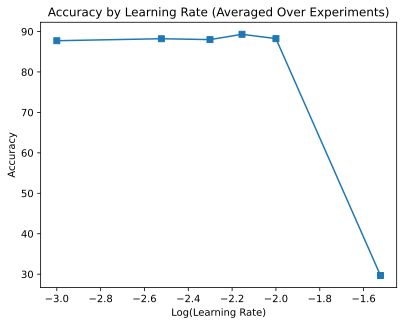

In [26]:
# Plot the averaged accuracies over experiments.
# Compute log with base 10 for the learning rates to make the points on the plot later more evenly distributed
log_10_lrs = np.log(cand_learning_rates)/np.log([10]*(len(cand_learning_rates)))
plt.plot(log_10_lrs, np.mean(exp_accuracies, axis=0), 's-')
plt.xlabel('Log(Learning Rate)')
plt.ylabel('Accuracy')
plt.title('Accuracy by Learning Rate (Averaged Over Experiments)')
plt.show()

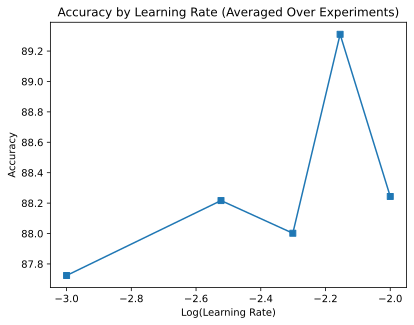

In [27]:
# Have a more detailed look on the validation accuracies for learning rates 0.001, 0.003, 0.005, 0.007, and 0.01
log_10_lrs = np.log(cand_learning_rates[:-1])/np.log([10]*(len(cand_learning_rates)-1))
plt.plot(log_10_lrs, np.mean(exp_accuracies[:,:-1], axis=0), 's-')
plt.xlabel('Log(Learning Rate)')
plt.ylabel('Accuracy')
plt.title('Accuracy by Learning Rate (Averaged Over Experiments)')
plt.show()

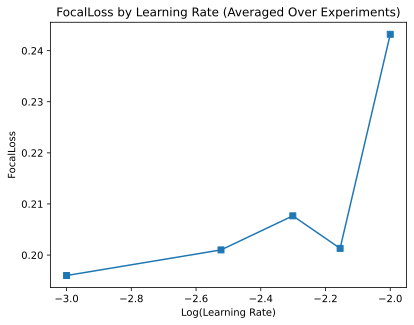

In [14]:
# Plot the averaged losses over experiments.
plt.plot(log_10_lrs, np.mean(exp_losses, axis=0), 's-')
plt.xlabel('Log(Learning Rate)')
plt.ylabel('FocalLoss')
plt.title('FocalLoss by Learning Rate (Averaged Over Experiments)')
plt.show()

### Experiment with convolutional layers' number of output channels value, and combinations of kernel size, stride, and paddings values 

In [11]:
# Candidate numbers of output channels for convolutional layers and combinations of kernel size, stride and padding values
cand_num_out_channels = [[8,16], [16,32], [32,64]]
cand_ksp_values = [{'k_size': [4,2], 'stride':[2,1], 'paddings':[2,1]},
                   {'k_size': [4,2], 'stride':[2,1], 'paddings':[0,0]},
                   {'k_size': [6,3], 'stride':[3,1], 'paddings':[3,2]},
                   {'k_size': [8,4], 'stride':[2,2], 'paddings':[4,2]}]

In [12]:
#brainMRIConvNet([32,64], k_sizes=cand_ksp_values[3]['k_size'], strides=cand_ksp_values[3]['stride'], paddings=cand_ksp_values[3]['paddings'],
#                maxpool_k_sizes=2, fc1_out_unit=512)

In [12]:
# Initialize matrices to store accuracies and total parameters.
accuracies = np.zeros((len(cand_num_out_channels), len(cand_ksp_values)))
losses = np.zeros((len(cand_num_out_channels), len(cand_ksp_values)))
total_params = np.zeros((len(cand_num_out_channels), len(cand_ksp_values)))

# Set the number of training epochs
num_of_epochs = 12
# Set learning rate to 0.007 according to the experiment results above
learning_rate = 0.007
# Set all other hyper-parameters to a specific value
maxpool_k_sizes = 2
fc_nUnit = 512
batch_size = 8
loss_func = customFocalLoss() 
log_every_n_epoch = 2

# Define training and validation data loaders with the batch_size
train_loader = DataLoader(train_Dataset,batch_size=batch_size, shuffle=True, drop_last=True)
valid_loader = DataLoader(valid_Dataset,batch_size=valid_Dataset.tensors[0].shape[0])


In [13]:
# Start the experiment by varying the number of units and layers.
for out_ch_idx in range(len(cand_num_out_channels)):
    print('Training with number of out channels (%d,%d)'% (cand_num_out_channels[out_ch_idx][0],
                                                           cand_num_out_channels[out_ch_idx][1]))
    for ksp_idx in range(len(cand_ksp_values)):
        print('Training with kernel sizes (%d,%d), strides (%d,%d), and paddings (%d,%d)'% (cand_ksp_values[ksp_idx]['k_size'][0],
                                                                                            cand_ksp_values[ksp_idx]['k_size'][1],
                                                                                            cand_ksp_values[ksp_idx]['stride'][0],
                                                                                            cand_ksp_values[ksp_idx]['stride'][1],
                                                                                            cand_ksp_values[ksp_idx]['paddings'][0],
                                                                                            cand_ksp_values[ksp_idx]['paddings'][1],))
        # Create a candidate brainMRIConvNet model object
        cand_brain_MRI_net = brainMRIConvNet(cand_num_out_channels[out_ch_idx], k_sizes=cand_ksp_values[ksp_idx]['k_size'], 
                                             strides=cand_ksp_values[ksp_idx]['stride'], paddings=cand_ksp_values[ksp_idx]['paddings'],
                                             maxpool_k_sizes=maxpool_k_sizes, fc1_out_unit=fc_nUnit)
        
        # Define optimizer according to the result of previous experiment
        optimizer = torch.optim.SGD(cand_brain_MRI_net.parameters(), lr=learning_rate, momentum=0.9)

        # Train the model and store the validation results.
        _, valid_acc, _, valid_losses,_ = trainBrainMRIConvNet(cand_brain_MRI_net, train_loader, valid_loader,
                                                               num_of_epochs, log_every_n_epoch,None,optimizer,loss_func)
        
        # Record avg. accuracy/loss on validation set for the last 3 epochs 
        accuracies[out_ch_idx, ksp_idx] = np.mean(valid_acc[len(valid_acc)-3:])
        losses[out_ch_idx, ksp_idx] = np.mean(list(valid_losses[len(valid_losses)-3:].detach()))

        # Record the total number of parameters in the model.
        num_of_params = sum(p.numel() for p in cand_brain_MRI_net.parameters() if p.requires_grad)
        total_params[out_ch_idx, ksp_idx] = num_of_params

Training with number of out channels (8,16)
Training with kernel sizes (4,2), strides (2,1), and paddings (2,1)
First convolution layer output size: 64
Second convolution layer output size: 32
First FC linear layer input size: 16384


train-1: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:48<00:00,  5.62it/s]


Epoch 1, Avg. Loss 0.243, Valid. Loss 0.217, Valid. Acc 80.000, Train Acc 78.413


train-3: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:50<00:00,  5.40it/s]


Epoch 3, Avg. Loss 0.023, Valid. Loss 0.214, Valid. Acc 85.376, Train Acc 97.878


train-5: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:49<00:00,  5.51it/s]


Epoch 5, Avg. Loss 0.001, Valid. Loss 0.222, Valid. Acc 86.237, Train Acc 99.862


train-7: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:49<00:00,  5.50it/s]


Epoch 7, Avg. Loss 0.000, Valid. Loss 0.218, Valid. Acc 87.097, Train Acc 100.000


train-9: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:46<00:00,  5.77it/s]


Epoch 9, Avg. Loss 0.000, Valid. Loss 0.223, Valid. Acc 87.097, Train Acc 100.000


train-11: 100%|██████████████████████████████████████████████████████████████████████| 271/271 [00:45<00:00,  5.94it/s]


Epoch 11, Avg. Loss 0.000, Valid. Loss 0.228, Valid. Acc 87.097, Train Acc 100.000
Training with kernel sizes (4,2), strides (2,1), and paddings (0,0)
First convolution layer output size: 63
Second convolution layer output size: 31
First FC linear layer input size: 15376


train-1: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:49<00:00,  5.49it/s]


Epoch 1, Avg. Loss 0.168, Valid. Loss 0.236, Valid. Acc 78.280, Train Acc 84.502


train-3: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:47<00:00,  5.71it/s]


Epoch 3, Avg. Loss 0.019, Valid. Loss 0.207, Valid. Acc 88.172, Train Acc 98.109


train-5: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:48<00:00,  5.63it/s]


Epoch 5, Avg. Loss 0.002, Valid. Loss 0.211, Valid. Acc 88.817, Train Acc 99.954


train-7: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:46<00:00,  5.77it/s]


Epoch 7, Avg. Loss 0.000, Valid. Loss 0.219, Valid. Acc 89.247, Train Acc 100.000


train-9: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:47<00:00,  5.70it/s]


Epoch 9, Avg. Loss 0.000, Valid. Loss 0.227, Valid. Acc 88.817, Train Acc 100.000


train-11: 100%|██████████████████████████████████████████████████████████████████████| 271/271 [00:50<00:00,  5.41it/s]


Epoch 11, Avg. Loss 0.000, Valid. Loss 0.228, Valid. Acc 89.462, Train Acc 100.000
Training with kernel sizes (6,3), strides (3,1), and paddings (3,2)
First convolution layer output size: 43
Second convolution layer output size: 22
First FC linear layer input size: 7744


train-1: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:38<00:00,  6.99it/s]


Epoch 1, Avg. Loss 0.222, Valid. Loss 0.222, Valid. Acc 78.710, Train Acc 78.552


train-3: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:42<00:00,  6.35it/s]


Epoch 3, Avg. Loss 0.049, Valid. Loss 0.182, Valid. Acc 87.312, Train Acc 95.018


train-5: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:45<00:00,  6.01it/s]


Epoch 5, Avg. Loss 0.003, Valid. Loss 0.216, Valid. Acc 87.527, Train Acc 99.815


train-7: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:43<00:00,  6.30it/s]


Epoch 7, Avg. Loss 0.000, Valid. Loss 0.209, Valid. Acc 89.462, Train Acc 100.000


train-9: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:44<00:00,  6.06it/s]


Epoch 9, Avg. Loss 0.000, Valid. Loss 0.219, Valid. Acc 89.247, Train Acc 100.000


train-11: 100%|██████████████████████████████████████████████████████████████████████| 271/271 [00:43<00:00,  6.21it/s]


Epoch 11, Avg. Loss 0.000, Valid. Loss 0.220, Valid. Acc 89.677, Train Acc 100.000
Training with kernel sizes (8,4), strides (2,2), and paddings (4,2)
First convolution layer output size: 64
Second convolution layer output size: 16
First FC linear layer input size: 4096


train-1: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:44<00:00,  6.03it/s]


Epoch 1, Avg. Loss 0.219, Valid. Loss 0.221, Valid. Acc 77.634, Train Acc 77.168


train-3: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:47<00:00,  5.72it/s]


Epoch 3, Avg. Loss 0.042, Valid. Loss 0.237, Valid. Acc 86.022, Train Acc 95.157


train-5: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:46<00:00,  5.85it/s]


Epoch 5, Avg. Loss 0.002, Valid. Loss 0.205, Valid. Acc 90.108, Train Acc 99.862


train-7: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:46<00:00,  5.78it/s]


Epoch 7, Avg. Loss 0.000, Valid. Loss 0.219, Valid. Acc 90.108, Train Acc 100.000


train-9: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:46<00:00,  5.78it/s]


Epoch 9, Avg. Loss 0.000, Valid. Loss 0.227, Valid. Acc 90.108, Train Acc 100.000


train-11: 100%|██████████████████████████████████████████████████████████████████████| 271/271 [00:45<00:00,  5.97it/s]


Epoch 11, Avg. Loss 0.000, Valid. Loss 0.240, Valid. Acc 89.892, Train Acc 100.000
Training with number of out channels (16,32)
Training with kernel sizes (4,2), strides (2,1), and paddings (2,1)
First convolution layer output size: 64
Second convolution layer output size: 32
First FC linear layer input size: 32768


train-1: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:58<00:00,  4.61it/s]


Epoch 1, Avg. Loss 0.477, Valid. Loss 0.492, Valid. Acc 64.086, Train Acc 64.622


train-3: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:57<00:00,  4.75it/s]


Epoch 3, Avg. Loss 0.174, Valid. Loss 0.215, Valid. Acc 79.570, Train Acc 82.611


train-5: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:59<00:00,  4.56it/s]


Epoch 5, Avg. Loss 0.031, Valid. Loss 0.180, Valid. Acc 84.946, Train Acc 96.725


train-7: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:57<00:00,  4.70it/s]


Epoch 7, Avg. Loss 0.006, Valid. Loss 0.208, Valid. Acc 87.312, Train Acc 99.077


train-9: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:58<00:00,  4.61it/s]


Epoch 9, Avg. Loss 0.000, Valid. Loss 0.222, Valid. Acc 88.172, Train Acc 100.000


train-11: 100%|██████████████████████████████████████████████████████████████████████| 271/271 [00:58<00:00,  4.64it/s]


Epoch 11, Avg. Loss 0.000, Valid. Loss 0.229, Valid. Acc 88.172, Train Acc 100.000
Training with kernel sizes (4,2), strides (2,1), and paddings (0,0)
First convolution layer output size: 63
Second convolution layer output size: 31
First FC linear layer input size: 30752


train-1: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:58<00:00,  4.64it/s]


Epoch 1, Avg. Loss 0.413, Valid. Loss 0.397, Valid. Acc 60.645, Train Acc 68.173


train-3: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:57<00:00,  4.74it/s]


Epoch 3, Avg. Loss 0.091, Valid. Loss 0.232, Valid. Acc 83.871, Train Acc 91.605


train-5: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:57<00:00,  4.68it/s]


Epoch 5, Avg. Loss 0.016, Valid. Loss 0.238, Valid. Acc 85.376, Train Acc 98.662


train-7: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:57<00:00,  4.72it/s]


Epoch 7, Avg. Loss 0.001, Valid. Loss 0.278, Valid. Acc 87.742, Train Acc 99.954


train-9: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:58<00:00,  4.64it/s]


Epoch 9, Avg. Loss 0.000, Valid. Loss 0.286, Valid. Acc 86.882, Train Acc 99.954


train-11: 100%|██████████████████████████████████████████████████████████████████████| 271/271 [00:56<00:00,  4.78it/s]


Epoch 11, Avg. Loss 0.000, Valid. Loss 0.285, Valid. Acc 87.097, Train Acc 100.000
Training with kernel sizes (6,3), strides (3,1), and paddings (3,2)
First convolution layer output size: 43
Second convolution layer output size: 22
First FC linear layer input size: 15488


train-1: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:48<00:00,  5.62it/s]


Epoch 1, Avg. Loss 0.366, Valid. Loss 0.515, Valid. Acc 66.882, Train Acc 70.941


train-3: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:48<00:00,  5.63it/s]


Epoch 3, Avg. Loss 0.119, Valid. Loss 0.318, Valid. Acc 79.785, Train Acc 91.421


train-5: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:46<00:00,  5.86it/s]


Epoch 5, Avg. Loss 0.008, Valid. Loss 0.162, Valid. Acc 90.968, Train Acc 99.400


train-7: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:48<00:00,  5.55it/s]


Epoch 7, Avg. Loss 0.001, Valid. Loss 0.181, Valid. Acc 90.753, Train Acc 100.000


train-9: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:47<00:00,  5.73it/s]


Epoch 9, Avg. Loss 0.000, Valid. Loss 0.187, Valid. Acc 90.538, Train Acc 99.954


train-11: 100%|██████████████████████████████████████████████████████████████████████| 271/271 [00:48<00:00,  5.55it/s]


Epoch 11, Avg. Loss 0.000, Valid. Loss 0.190, Valid. Acc 90.753, Train Acc 100.000
Training with kernel sizes (8,4), strides (2,2), and paddings (4,2)
First convolution layer output size: 64
Second convolution layer output size: 16
First FC linear layer input size: 8192


train-1: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:49<00:00,  5.44it/s]


Epoch 1, Avg. Loss 0.328, Valid. Loss 0.433, Valid. Acc 64.301, Train Acc 70.526


train-3: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:48<00:00,  5.53it/s]


Epoch 3, Avg. Loss 0.109, Valid. Loss 0.275, Valid. Acc 82.796, Train Acc 88.515


train-5: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:51<00:00,  5.30it/s]


Epoch 5, Avg. Loss 0.012, Valid. Loss 0.242, Valid. Acc 85.591, Train Acc 98.801


train-7: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:49<00:00,  5.42it/s]


Epoch 7, Avg. Loss 0.001, Valid. Loss 0.229, Valid. Acc 87.527, Train Acc 100.000


train-9: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:50<00:00,  5.32it/s]


Epoch 9, Avg. Loss 0.000, Valid. Loss 0.235, Valid. Acc 87.957, Train Acc 100.000


train-11: 100%|██████████████████████████████████████████████████████████████████████| 271/271 [00:49<00:00,  5.52it/s]


Epoch 11, Avg. Loss 0.000, Valid. Loss 0.238, Valid. Acc 87.742, Train Acc 100.000
Training with number of out channels (32,64)
Training with kernel sizes (4,2), strides (2,1), and paddings (2,1)
First convolution layer output size: 64
Second convolution layer output size: 32
First FC linear layer input size: 65536


train-1: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:56<00:00,  4.81it/s]


Epoch 1, Avg. Loss 0.695, Valid. Loss 0.624, Valid. Acc 51.613, Train Acc 45.434


train-3: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:57<00:00,  4.74it/s]


Epoch 3, Avg. Loss 0.649, Valid. Loss 0.504, Valid. Acc 63.656, Train Acc 49.400


train-5: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:56<00:00,  4.78it/s]


Epoch 5, Avg. Loss 0.551, Valid. Loss 0.518, Valid. Acc 58.710, Train Acc 56.089


train-7: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:56<00:00,  4.76it/s]


Epoch 7, Avg. Loss 0.380, Valid. Loss 0.382, Valid. Acc 70.968, Train Acc 70.895


train-9: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:54<00:00,  4.93it/s]


Epoch 9, Avg. Loss 0.135, Valid. Loss 0.269, Valid. Acc 83.226, Train Acc 88.284


train-11: 100%|██████████████████████████████████████████████████████████████████████| 271/271 [00:56<00:00,  4.76it/s]


Epoch 11, Avg. Loss 0.037, Valid. Loss 0.245, Valid. Acc 86.452, Train Acc 96.402
Training with kernel sizes (4,2), strides (2,1), and paddings (0,0)
First convolution layer output size: 63
Second convolution layer output size: 31
First FC linear layer input size: 61504


train-1: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:54<00:00,  4.97it/s]


Epoch 1, Avg. Loss 0.664, Valid. Loss 0.673, Valid. Acc 47.742, Train Acc 53.782


train-3: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:56<00:00,  4.77it/s]


Epoch 3, Avg. Loss 0.490, Valid. Loss 0.440, Valid. Acc 62.151, Train Acc 56.596


train-5: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:54<00:00,  4.93it/s]


Epoch 5, Avg. Loss 0.367, Valid. Loss 0.540, Valid. Acc 69.892, Train Acc 72.648


train-7: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:56<00:00,  4.79it/s]


Epoch 7, Avg. Loss 0.241, Valid. Loss 0.353, Valid. Acc 78.065, Train Acc 80.627


train-9: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:55<00:00,  4.84it/s]


Epoch 9, Avg. Loss 0.103, Valid. Loss 0.336, Valid. Acc 84.516, Train Acc 91.605


train-11: 100%|██████████████████████████████████████████████████████████████████████| 271/271 [00:57<00:00,  4.74it/s]


Epoch 11, Avg. Loss 0.029, Valid. Loss 0.306, Valid. Acc 85.591, Train Acc 97.555
Training with kernel sizes (6,3), strides (3,1), and paddings (3,2)
First convolution layer output size: 43
Second convolution layer output size: 22
First FC linear layer input size: 30976


train-1: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:55<00:00,  4.89it/s]


Epoch 1, Avg. Loss 0.599, Valid. Loss 0.417, Valid. Acc 63.226, Train Acc 51.753


train-3: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:57<00:00,  4.69it/s]


Epoch 3, Avg. Loss 0.488, Valid. Loss 0.568, Valid. Acc 60.645, Train Acc 60.194


train-5: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:56<00:00,  4.83it/s]


Epoch 5, Avg. Loss 0.379, Valid. Loss 0.442, Valid. Acc 56.129, Train Acc 68.127


train-7: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:57<00:00,  4.72it/s]


Epoch 7, Avg. Loss 0.230, Valid. Loss 0.308, Valid. Acc 71.398, Train Acc 80.212


train-9: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:55<00:00,  4.93it/s]


Epoch 9, Avg. Loss 0.143, Valid. Loss 0.235, Valid. Acc 81.290, Train Acc 90.175


train-11: 100%|██████████████████████████████████████████████████████████████████████| 271/271 [00:57<00:00,  4.74it/s]


Epoch 11, Avg. Loss 0.017, Valid. Loss 0.252, Valid. Acc 86.452, Train Acc 98.432
Training with kernel sizes (8,4), strides (2,2), and paddings (4,2)
First convolution layer output size: 64
Second convolution layer output size: 16
First FC linear layer input size: 16384


train-1: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:53<00:00,  5.07it/s]


Epoch 1, Avg. Loss 0.425, Valid. Loss 0.375, Valid. Acc 70.753, Train Acc 63.284


train-3: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:52<00:00,  5.12it/s]


Epoch 3, Avg. Loss 0.218, Valid. Loss 0.356, Valid. Acc 74.409, Train Acc 80.535


train-5: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:54<00:00,  5.00it/s]


Epoch 5, Avg. Loss 0.054, Valid. Loss 0.282, Valid. Acc 84.731, Train Acc 94.603


train-7: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:52<00:00,  5.13it/s]


Epoch 7, Avg. Loss 0.029, Valid. Loss 0.257, Valid. Acc 87.742, Train Acc 97.048


train-9: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:54<00:00,  4.94it/s]


Epoch 9, Avg. Loss 0.008, Valid. Loss 0.315, Valid. Acc 88.172, Train Acc 99.400


train-11: 100%|██████████████████████████████████████████████████████████████████████| 271/271 [00:51<00:00,  5.24it/s]


Epoch 11, Avg. Loss 0.001, Valid. Loss 0.331, Valid. Acc 88.172, Train Acc 99.954


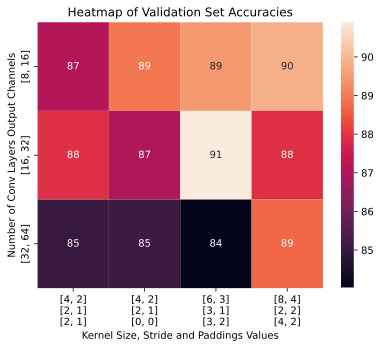

In [36]:
ksp_value_label = ['\n'.join([str(ksp_val['k_size']),str(ksp_val['stride']),str(ksp_val['paddings'])]) for ksp_val in cand_ksp_values]
ax = sns.heatmap(accuracies, xticklabels=ksp_value_label,
                 yticklabels=cand_num_out_channels,annot=True) # create seaborn heatmap

plt.title('Heatmap of Validation Set Accuracies') 
plt.xlabel('Kernel Size, Stride and Paddings Values', fontsize = 10) 
plt.ylabel('Number of Conv Layers Output Channels', fontsize = 10) 

plt.show()

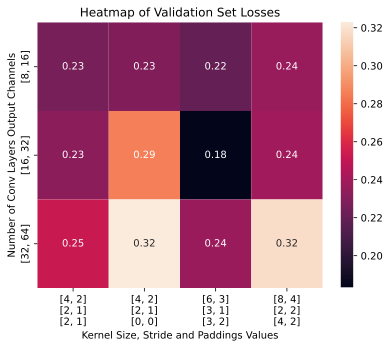

In [35]:
ax = sns.heatmap(losses, xticklabels=ksp_value_label,
                 yticklabels=cand_num_out_channels,annot=True) # create seaborn heatmap

plt.title('Heatmap of Validation Set Losses') 
plt.xlabel('Kernel Size, Stride and Paddings Values', fontsize = 10) 
plt.ylabel('Number of Conv Layers Output Channels', fontsize = 10) 

plt.show()

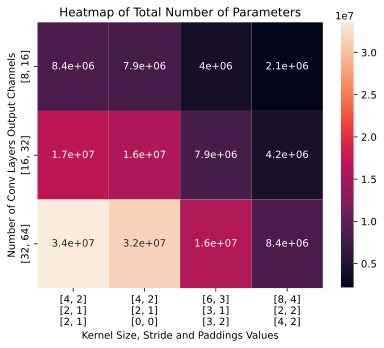

In [34]:
ax = sns.heatmap(total_params, xticklabels=ksp_value_label,
                 yticklabels=cand_num_out_channels,annot=True) # create seaborn heatmap

plt.title('Heatmap of Total Number of Parameters') 
plt.xlabel('Kernel Size, Stride and Paddings Values', fontsize = 10) 
plt.ylabel('Number of Conv Layers Output Channels', fontsize = 10) 

plt.show()

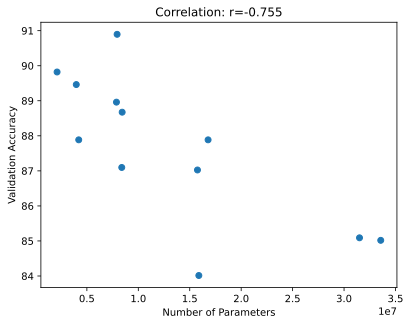

In [38]:
# Analyze the correlation between the number of parameters and accuracy.
x = total_params.flatten()
y = accuracies.flatten()

# Calculate the correlation coefficient.
r = np.corrcoef(x, y)[0, 1]

# Scatter plot of parameters vs. accuracy.
plt.plot(x, y, 'o')
plt.xlabel('Number of Parameters')
plt.ylabel('Validation Accuracy')
plt.title('Correlation: r=' + str(np.round(r, 3)))
plt.show()

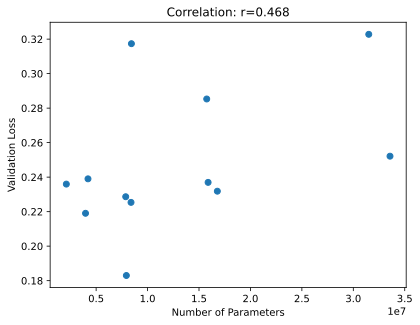

In [37]:
# Analyze the correlation between the number of parameters and validation losses.
x = total_params.flatten()
y = losses.flatten()

# Calculate the correlation coefficient.
r = np.corrcoef(x, y)[0, 1]

# Scatter plot of parameters vs. loss.
plt.plot(x, y, 'o')
plt.xlabel('Number of Parameters')
plt.ylabel('Validation Loss')
plt.title('Correlation: r=' + str(np.round(r, 3)))
plt.show()

### Experiment with different dense layer's hidden dimensions and max pooling layers' kernel size and stride values

In [43]:
# Candidate numbers of output channels for convolutional layers and combinations of kernel size, stride and padding values
cand_MP_ks_values = [[1,2],2,3]
cand_fc_nUnits = [256, 512, 768, 1024]

In [44]:
# Initialize matrices to store accuracies and total parameters.
MP_ks_fc_nUnits_acc = np.zeros((len(cand_MP_ks_values), len(cand_fc_nUnits)))
MP_ks_fc_nUnits_losses = np.zeros((len(cand_MP_ks_values), len(cand_fc_nUnits)))
MP_ks_fc_nUnits_num_params = np.zeros((len(cand_MP_ks_values), len(cand_fc_nUnits)))

# Set the number of training epochs
num_of_epochs = 12
# Set learning rate, conv layer out channel, conv layer kernel size, stride and paddings values
# according to the previous experiments' result above
learning_rate = 0.007
conv_out_channels = [16,32]
kernel_sizes = [6,3]
strides = [3,1]
paddings = [3,2]

# Set other hyer-parameters to fixed values
batch_size = 8
loss_func = customFocalLoss() 
log_every_n_epoch = 2


In [46]:
# Start the experiment by varying the number of units and layers.
for MP_ks_idx in range(len(cand_MP_ks_values)):
    print('Training with kernel size and stride values of MaxPooling layers: %s'% str(cand_MP_ks_values[MP_ks_idx]))
    for fc_nUnits_idx in range(len(cand_fc_nUnits)):
        print('Training with dense layer hidden units: %d'% (cand_fc_nUnits[fc_nUnits_idx]))
              
        # Create a candidate brainMRIConvNet model object
        cand_brain_MRI_net = brainMRIConvNet(conv_out_channels, k_sizes=kernel_sizes, strides=strides, paddings=paddings,
                                             maxpool_k_sizes=cand_MP_ks_values[MP_ks_idx], 
                                             fc1_out_unit=cand_fc_nUnits[fc_nUnits_idx])
        
        # Define optimizer according to the result of previous experiment
        optimizer = torch.optim.SGD(cand_brain_MRI_net.parameters(), lr=learning_rate, momentum=0.9)

        # Train the model and store the validation results.
        _, valid_acc, _, valid_losses,_ = trainBrainMRIConvNet(cand_brain_MRI_net, train_loader, valid_loader,
                                                               num_of_epochs, log_every_n_epoch,None,optimizer,loss_func)
        
        # Record avg. accuracy/loss on validation set for the last 3 epochs 
        MP_ks_fc_nUnits_acc[MP_ks_idx, fc_nUnits_idx] = np.mean(valid_acc[len(valid_acc)-3:])
        MP_ks_fc_nUnits_losses[MP_ks_idx, fc_nUnits_idx] = np.mean(list(valid_losses[len(valid_losses)-3:].detach()))

        # Record the total number of parameters in the model.
        num_of_params = sum(p.numel() for p in cand_brain_MRI_net.parameters() if p.requires_grad)
        MP_ks_fc_nUnits_num_params[MP_ks_idx, fc_nUnits_idx] = num_of_params

Training with kernel size and stride values of MaxPooling layers: [1, 2]
Training with dense layer hidden units: 256
First convolution layer output size: 86
Second convolution layer output size: 44
First FC linear layer input size: 61952


train-1: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [01:02<00:00,  4.34it/s]


Epoch 1, Avg. Loss 0.679, Valid. Loss 0.558, Valid. Acc 46.452, Train Acc 47.325


train-3: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [01:03<00:00,  4.26it/s]


Epoch 3, Avg. Loss 0.424, Valid. Loss 0.333, Valid. Acc 69.247, Train Acc 68.312


train-5: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:59<00:00,  4.55it/s]


Epoch 5, Avg. Loss 0.188, Valid. Loss 0.330, Valid. Acc 78.495, Train Acc 83.441


train-7: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [01:02<00:00,  4.35it/s]


Epoch 7, Avg. Loss 0.043, Valid. Loss 0.239, Valid. Acc 86.237, Train Acc 95.756


train-9: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:54<00:00,  4.94it/s]


Epoch 9, Avg. Loss 0.014, Valid. Loss 0.264, Valid. Acc 86.022, Train Acc 98.708


train-11: 100%|██████████████████████████████████████████████████████████████████████| 271/271 [00:59<00:00,  4.54it/s]


Epoch 11, Avg. Loss 0.004, Valid. Loss 0.282, Valid. Acc 86.452, Train Acc 99.493
Training with dense layer hidden units: 512
First convolution layer output size: 86
Second convolution layer output size: 44
First FC linear layer input size: 61952


train-1: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:50<00:00,  5.40it/s]


Epoch 1, Avg. Loss 0.629, Valid. Loss 0.450, Valid. Acc 64.731, Train Acc 54.889


train-3: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:52<00:00,  5.20it/s]


Epoch 3, Avg. Loss 0.260, Valid. Loss 0.311, Valid. Acc 73.978, Train Acc 76.292


train-5: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:52<00:00,  5.14it/s]


Epoch 5, Avg. Loss 0.071, Valid. Loss 0.284, Valid. Acc 79.140, Train Acc 93.450


train-7: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:48<00:00,  5.60it/s]


Epoch 7, Avg. Loss 0.040, Valid. Loss 0.233, Valid. Acc 85.591, Train Acc 96.679


train-9: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:47<00:00,  5.76it/s]


Epoch 9, Avg. Loss 0.003, Valid. Loss 0.282, Valid. Acc 83.871, Train Acc 99.815


train-11: 100%|██████████████████████████████████████████████████████████████████████| 271/271 [00:46<00:00,  5.88it/s]


Epoch 11, Avg. Loss 0.001, Valid. Loss 0.238, Valid. Acc 87.957, Train Acc 99.954
Training with dense layer hidden units: 768
First convolution layer output size: 86
Second convolution layer output size: 44
First FC linear layer input size: 61952


train-1: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:41<00:00,  6.49it/s]


Epoch 1, Avg. Loss 0.576, Valid. Loss 0.467, Valid. Acc 58.065, Train Acc 57.472


train-3: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:41<00:00,  6.57it/s]


Epoch 3, Avg. Loss 0.275, Valid. Loss 0.265, Valid. Acc 75.484, Train Acc 73.893


train-5: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:41<00:00,  6.55it/s]


Epoch 5, Avg. Loss 0.067, Valid. Loss 0.208, Valid. Acc 85.161, Train Acc 92.435


train-7: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:46<00:00,  5.83it/s]


Epoch 7, Avg. Loss 0.005, Valid. Loss 0.246, Valid. Acc 86.667, Train Acc 99.493


train-9: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:46<00:00,  5.80it/s]


Epoch 9, Avg. Loss 0.000, Valid. Loss 0.242, Valid. Acc 88.172, Train Acc 100.000


train-11: 100%|██████████████████████████████████████████████████████████████████████| 271/271 [00:46<00:00,  5.78it/s]


Epoch 11, Avg. Loss 0.000, Valid. Loss 0.255, Valid. Acc 87.527, Train Acc 100.000
Training with dense layer hidden units: 1024
First convolution layer output size: 86
Second convolution layer output size: 44
First FC linear layer input size: 61952


train-1: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:46<00:00,  5.83it/s]


Epoch 1, Avg. Loss 0.542, Valid. Loss 0.426, Valid. Acc 60.645, Train Acc 58.625


train-3: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:51<00:00,  5.31it/s]


Epoch 3, Avg. Loss 0.170, Valid. Loss 0.248, Valid. Acc 78.495, Train Acc 84.732


train-5: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:55<00:00,  4.89it/s]


Epoch 5, Avg. Loss 0.036, Valid. Loss 0.231, Valid. Acc 84.946, Train Acc 96.910


train-7: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:52<00:00,  5.15it/s]


Epoch 7, Avg. Loss 0.022, Valid. Loss 0.281, Valid. Acc 84.731, Train Acc 98.432


train-9: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:54<00:00,  4.97it/s]


Epoch 9, Avg. Loss 0.001, Valid. Loss 0.250, Valid. Acc 87.957, Train Acc 99.908


train-11: 100%|██████████████████████████████████████████████████████████████████████| 271/271 [00:52<00:00,  5.12it/s]


Epoch 11, Avg. Loss 0.000, Valid. Loss 0.279, Valid. Acc 87.312, Train Acc 100.000
Training with kernel size and stride values of MaxPooling layers: 2
Training with dense layer hidden units: 256
First convolution layer output size: 43
Second convolution layer output size: 22
First FC linear layer input size: 15488


train-1: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:49<00:00,  5.46it/s]


Epoch 1, Avg. Loss 0.327, Valid. Loss 0.286, Valid. Acc 75.699, Train Acc 72.417


train-3: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:50<00:00,  5.38it/s]


Epoch 3, Avg. Loss 0.117, Valid. Loss 0.368, Valid. Acc 80.000, Train Acc 89.022


train-5: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:48<00:00,  5.65it/s]


Epoch 5, Avg. Loss 0.016, Valid. Loss 0.353, Valid. Acc 83.871, Train Acc 98.293


train-7: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:50<00:00,  5.37it/s]


Epoch 7, Avg. Loss 0.002, Valid. Loss 0.250, Valid. Acc 89.892, Train Acc 99.769


train-9: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:49<00:00,  5.43it/s]


Epoch 9, Avg. Loss 0.000, Valid. Loss 0.262, Valid. Acc 88.817, Train Acc 100.000


train-11: 100%|██████████████████████████████████████████████████████████████████████| 271/271 [00:50<00:00,  5.39it/s]


Epoch 11, Avg. Loss 0.000, Valid. Loss 0.260, Valid. Acc 89.247, Train Acc 100.000
Training with dense layer hidden units: 512
First convolution layer output size: 43
Second convolution layer output size: 22
First FC linear layer input size: 15488


train-1: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:52<00:00,  5.16it/s]


Epoch 1, Avg. Loss 0.353, Valid. Loss 0.371, Valid. Acc 68.602, Train Acc 69.834


train-3: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:52<00:00,  5.19it/s]


Epoch 3, Avg. Loss 0.107, Valid. Loss 0.253, Valid. Acc 81.505, Train Acc 89.668


train-5: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:48<00:00,  5.56it/s]


Epoch 5, Avg. Loss 0.020, Valid. Loss 0.185, Valid. Acc 90.323, Train Acc 97.970


train-7: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:51<00:00,  5.26it/s]


Epoch 7, Avg. Loss 0.006, Valid. Loss 0.235, Valid. Acc 88.387, Train Acc 99.677


train-9: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:53<00:00,  5.05it/s]


Epoch 9, Avg. Loss 0.000, Valid. Loss 0.198, Valid. Acc 89.677, Train Acc 100.000


train-11: 100%|██████████████████████████████████████████████████████████████████████| 271/271 [00:50<00:00,  5.39it/s]


Epoch 11, Avg. Loss 0.000, Valid. Loss 0.200, Valid. Acc 90.323, Train Acc 100.000
Training with dense layer hidden units: 768
First convolution layer output size: 43
Second convolution layer output size: 22
First FC linear layer input size: 15488


train-1: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:56<00:00,  4.77it/s]


Epoch 1, Avg. Loss 0.396, Valid. Loss 0.486, Valid. Acc 61.720, Train Acc 67.712


train-3: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:55<00:00,  4.86it/s]


Epoch 3, Avg. Loss 0.218, Valid. Loss 0.235, Valid. Acc 77.634, Train Acc 79.751


train-5: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:56<00:00,  4.81it/s]


Epoch 5, Avg. Loss 0.070, Valid. Loss 0.220, Valid. Acc 84.301, Train Acc 92.943


train-7: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:56<00:00,  4.81it/s]


Epoch 7, Avg. Loss 0.011, Valid. Loss 0.209, Valid. Acc 89.032, Train Acc 99.031


train-9: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:57<00:00,  4.72it/s]


Epoch 9, Avg. Loss 0.002, Valid. Loss 0.207, Valid. Acc 90.108, Train Acc 99.908


train-11: 100%|██████████████████████████████████████████████████████████████████████| 271/271 [00:56<00:00,  4.83it/s]


Epoch 11, Avg. Loss 0.000, Valid. Loss 0.204, Valid. Acc 90.323, Train Acc 99.954
Training with dense layer hidden units: 1024
First convolution layer output size: 43
Second convolution layer output size: 22
First FC linear layer input size: 15488


train-1: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [01:00<00:00,  4.45it/s]


Epoch 1, Avg. Loss 0.373, Valid. Loss 0.359, Valid. Acc 64.086, Train Acc 70.572


train-3: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:59<00:00,  4.57it/s]


Epoch 3, Avg. Loss 0.102, Valid. Loss 0.224, Valid. Acc 83.871, Train Acc 89.114


train-5: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [01:00<00:00,  4.47it/s]


Epoch 5, Avg. Loss 0.011, Valid. Loss 0.231, Valid. Acc 89.032, Train Acc 98.755


train-7: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:59<00:00,  4.54it/s]


Epoch 7, Avg. Loss 0.001, Valid. Loss 0.201, Valid. Acc 90.538, Train Acc 100.000


train-9: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [01:00<00:00,  4.50it/s]


Epoch 9, Avg. Loss 0.000, Valid. Loss 0.204, Valid. Acc 90.538, Train Acc 100.000


train-11: 100%|██████████████████████████████████████████████████████████████████████| 271/271 [00:58<00:00,  4.60it/s]


Epoch 11, Avg. Loss 0.000, Valid. Loss 0.202, Valid. Acc 90.538, Train Acc 100.000
Training with kernel size and stride values of MaxPooling layers: 3
Training with dense layer hidden units: 256
First convolution layer output size: 28
Second convolution layer output size: 10
First FC linear layer input size: 3200


train-1: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:46<00:00,  5.77it/s]


Epoch 1, Avg. Loss 0.267, Valid. Loss 0.316, Valid. Acc 69.462, Train Acc 72.970


train-3: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:47<00:00,  5.74it/s]


Epoch 3, Avg. Loss 0.102, Valid. Loss 0.183, Valid. Acc 82.796, Train Acc 89.299


train-5: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:46<00:00,  5.86it/s]


Epoch 5, Avg. Loss 0.040, Valid. Loss 0.209, Valid. Acc 85.806, Train Acc 95.434


train-7: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:47<00:00,  5.66it/s]


Epoch 7, Avg. Loss 0.012, Valid. Loss 0.183, Valid. Acc 89.032, Train Acc 99.077


train-9: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:46<00:00,  5.85it/s]


Epoch 9, Avg. Loss 0.001, Valid. Loss 0.206, Valid. Acc 89.892, Train Acc 99.862


train-11: 100%|██████████████████████████████████████████████████████████████████████| 271/271 [00:46<00:00,  5.79it/s]


Epoch 11, Avg. Loss 0.000, Valid. Loss 0.210, Valid. Acc 89.677, Train Acc 100.000
Training with dense layer hidden units: 512
First convolution layer output size: 28
Second convolution layer output size: 10
First FC linear layer input size: 3200


train-1: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:48<00:00,  5.61it/s]


Epoch 1, Avg. Loss 0.226, Valid. Loss 0.278, Valid. Acc 71.828, Train Acc 78.044


train-3: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:46<00:00,  5.82it/s]


Epoch 3, Avg. Loss 0.072, Valid. Loss 0.226, Valid. Acc 83.226, Train Acc 92.574


train-5: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:48<00:00,  5.53it/s]


Epoch 5, Avg. Loss 0.013, Valid. Loss 0.243, Valid. Acc 86.022, Train Acc 98.570


train-7: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:47<00:00,  5.74it/s]


Epoch 7, Avg. Loss 0.003, Valid. Loss 0.221, Valid. Acc 88.387, Train Acc 99.769


train-9: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:47<00:00,  5.70it/s]


Epoch 9, Avg. Loss 0.000, Valid. Loss 0.229, Valid. Acc 87.957, Train Acc 100.000


train-11: 100%|██████████████████████████████████████████████████████████████████████| 271/271 [00:48<00:00,  5.60it/s]


Epoch 11, Avg. Loss 0.000, Valid. Loss 0.239, Valid. Acc 88.172, Train Acc 100.000
Training with dense layer hidden units: 768
First convolution layer output size: 28
Second convolution layer output size: 10
First FC linear layer input size: 3200


train-1: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:47<00:00,  5.70it/s]


Epoch 1, Avg. Loss 0.220, Valid. Loss 0.204, Valid. Acc 80.430, Train Acc 76.983


train-3: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:48<00:00,  5.57it/s]


Epoch 3, Avg. Loss 0.055, Valid. Loss 0.237, Valid. Acc 84.301, Train Acc 94.280


train-5: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:47<00:00,  5.68it/s]


Epoch 5, Avg. Loss 0.014, Valid. Loss 0.162, Valid. Acc 89.462, Train Acc 98.570


train-7: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:47<00:00,  5.65it/s]


Epoch 7, Avg. Loss 0.000, Valid. Loss 0.190, Valid. Acc 89.462, Train Acc 100.000


train-9: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:46<00:00,  5.77it/s]


Epoch 9, Avg. Loss 0.000, Valid. Loss 0.196, Valid. Acc 89.247, Train Acc 100.000


train-11: 100%|██████████████████████████████████████████████████████████████████████| 271/271 [00:46<00:00,  5.82it/s]


Epoch 11, Avg. Loss 0.000, Valid. Loss 0.198, Valid. Acc 89.247, Train Acc 100.000
Training with dense layer hidden units: 1024
First convolution layer output size: 28
Second convolution layer output size: 10
First FC linear layer input size: 3200


train-1: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:50<00:00,  5.38it/s]


Epoch 1, Avg. Loss 0.214, Valid. Loss 0.214, Valid. Acc 76.129, Train Acc 78.921


train-3: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:48<00:00,  5.60it/s]


Epoch 3, Avg. Loss 0.068, Valid. Loss 0.211, Valid. Acc 85.161, Train Acc 92.159


train-5: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:48<00:00,  5.60it/s]


Epoch 5, Avg. Loss 0.010, Valid. Loss 0.201, Valid. Acc 88.817, Train Acc 98.662


train-7: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:48<00:00,  5.61it/s]


Epoch 7, Avg. Loss 0.005, Valid. Loss 0.254, Valid. Acc 88.172, Train Acc 99.400


train-9: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [00:42<00:00,  6.33it/s]


Epoch 9, Avg. Loss 0.000, Valid. Loss 0.231, Valid. Acc 89.462, Train Acc 100.000


train-11: 100%|██████████████████████████████████████████████████████████████████████| 271/271 [00:49<00:00,  5.49it/s]


Epoch 11, Avg. Loss 0.000, Valid. Loss 0.230, Valid. Acc 90.108, Train Acc 100.000


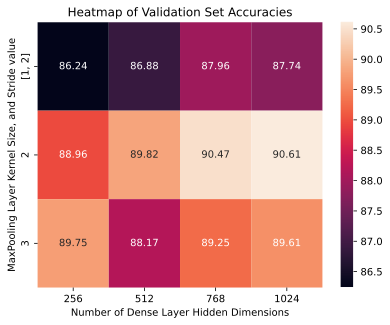

In [53]:
ax = sns.heatmap(MP_ks_fc_nUnits_acc, xticklabels=cand_fc_nUnits,
                 yticklabels=cand_MP_ks_values,annot=True,fmt='.2f') # create seaborn heatmap

plt.title('Heatmap of Validation Set Accuracies') 
plt.xlabel('Number of Dense Layer Hidden Dimensions', fontsize = 10) 
plt.ylabel('MaxPooling Layer Kernel Size, and Stride value', fontsize = 10) 

plt.show()

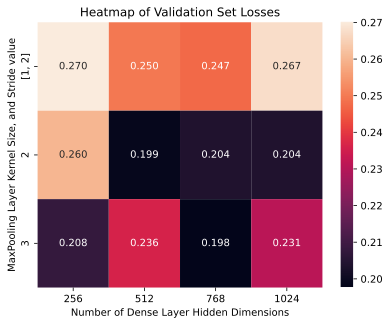

In [51]:
ax = sns.heatmap(MP_ks_fc_nUnits_losses, xticklabels=cand_fc_nUnits,
                 yticklabels=cand_MP_ks_values,annot=True,fmt=".3f") # create seaborn heatmap

plt.title('Heatmap of Validation Set Losses') 
plt.xlabel('Number of Dense Layer Hidden Dimensions', fontsize = 10) 
plt.ylabel('MaxPooling Layer Kernel Size, and Stride value', fontsize = 10) 

plt.show()

In [59]:
MP_ks_fc_nUnits_num_params

array([[15867476., 31728468., 47589460., 63450452.],
       [ 3972692.,  7938900., 11905108., 15871316.],
       [  826964.,  1647444.,  2467924.,  3288404.]])

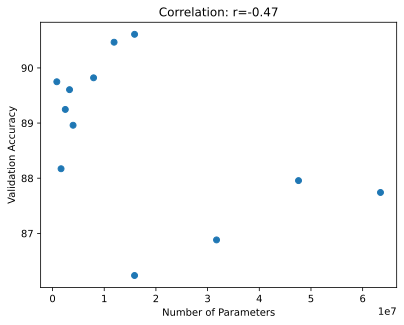

In [54]:
# Analyze the correlation between the number of parameters and accuracy.
x = MP_ks_fc_nUnits_num_params.flatten()
y = MP_ks_fc_nUnits_acc.flatten()

# Calculate the correlation coefficient.
r = np.corrcoef(x, y)[0, 1]

# Scatter plot of parameters vs. accuracy.
plt.plot(x, y, 'o')
plt.xlabel('Number of Parameters')
plt.ylabel('Validation Accuracy')
plt.title('Correlation: r=' + str(np.round(r, 3)))
plt.show()

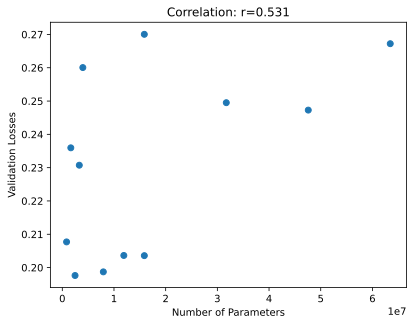

In [55]:
# Analyze the correlation between the number of parameters and validation losses.
x = MP_ks_fc_nUnits_num_params.flatten()
y = MP_ks_fc_nUnits_losses.flatten()

# Calculate the correlation coefficient.
r = np.corrcoef(x, y)[0, 1]

# Scatter plot of parameters vs. accuracy.
plt.plot(x, y, 'o')
plt.xlabel('Number of Parameters')
plt.ylabel('Validation Losses')
plt.title('Correlation: r=' + str(np.round(r, 3)))
plt.show()

### Experiment with different batch sizes

In [67]:
# Define array for candidate batch sizes (2,4,8,16,32)
cand_batch_sizes = 2 ** np.arange(1, 6, 1)

# set number of epochs 
num_of_epochs = 12
# set values of hyper-parameters that have been experimented 
# according to the experiment results above
learning_rate = 0.007
conv_out_channels = [16,32]
kernel_sizes = [6,3]
strides = [3,1]
paddings = [3,2]
maxpool_k_sizes = 2
fc_nUnit = 768
# set all other hyper-parameters to a fixed value
loss_func = customFocalLoss() 
log_every_n_epoch = 2

# Initialize output results ndarrays to
# record training accuracies
train_bs_acc = np.zeros((num_of_epochs, len(cand_batch_sizes)))
# record validation accuracies
valid_bs_acc = np.zeros((num_of_epochs, len(cand_batch_sizes)))
# record computation time of training
train_time = np.zeros(len(cand_batch_sizes))


# Validation data loader doesn't change by training batch size
valid_loader = DataLoader(valid_Dataset, batch_size=valid_Dataset.tensors[0].shape[0])


In [68]:
# Loop over different batch sizes
for ith_bs in range(len(cand_batch_sizes)):
    print('Training with batch size %d'% int(cand_batch_sizes[ith_bs]))
    # Start the timer to measure computation time
    starttime = time.process_time()

    # Create DataLoader object for training data with the current batch size
    train_loader = DataLoader(train_Dataset,batch_size=int(cand_batch_sizes[ith_bs]), shuffle=True, drop_last=True)

    # Create a candidate brainMRIConvNet model object
    cand_brain_MRI_net = brainMRIConvNet(conv_out_channels, k_sizes=kernel_sizes, strides=strides, paddings=paddings,
                                         maxpool_k_sizes=maxpool_k_sizes, fc1_out_unit=fc_nUnit)
    
    # Define optimizer according to the result of previous experiment
    optimizer = torch.optim.SGD(cand_brain_MRI_net.parameters(), lr=learning_rate, momentum=0.9)

    # Train the model and store the training and validation accuracies.
    train_acc, valid_acc, _,_,_ = trainBrainMRIConvNet(cand_brain_MRI_net, train_loader, valid_loader,
                                                     num_of_epochs, log_every_n_epoch,None,optimizer,loss_func)

    # Store training and testing accuracy results
    train_bs_acc[:, ith_bs] = train_acc
    valid_bs_acc[:, ith_bs] = valid_acc

    # Record the computation time
    train_time[ith_bs] = time.process_time() - starttime
    print('Computation time with batch size %d is %.2f seconds'% (int(cand_batch_sizes[ith_bs]),train_time[ith_bs]))

Training with batch size 2
First convolution layer output size: 43
Second convolution layer output size: 22
First FC linear layer input size: 15488


train-1: 100%|█████████████████████████████████████████████████████████████████████| 1085/1085 [04:24<00:00,  4.11it/s]


Epoch 1, Avg. Loss 0.712, Valid. Loss 0.760, Valid. Acc 31.828, Train Acc 38.618


train-3: 100%|█████████████████████████████████████████████████████████████████████| 1085/1085 [04:24<00:00,  4.10it/s]


Epoch 3, Avg. Loss 0.743, Valid. Loss 0.718, Valid. Acc 32.473, Train Acc 33.318


train-5: 100%|█████████████████████████████████████████████████████████████████████| 1085/1085 [04:26<00:00,  4.08it/s]


Epoch 5, Avg. Loss 0.757, Valid. Loss 0.753, Valid. Acc 31.183, Train Acc 28.157


train-7: 100%|█████████████████████████████████████████████████████████████████████| 1085/1085 [04:24<00:00,  4.11it/s]


Epoch 7, Avg. Loss 0.758, Valid. Loss 0.755, Valid. Acc 27.097, Train Acc 27.005


train-9: 100%|█████████████████████████████████████████████████████████████████████| 1085/1085 [04:13<00:00,  4.27it/s]


Epoch 9, Avg. Loss 0.757, Valid. Loss 0.758, Valid. Acc 27.312, Train Acc 27.327


train-11: 100%|████████████████████████████████████████████████████████████████████| 1085/1085 [04:17<00:00,  4.21it/s]


Epoch 11, Avg. Loss 0.756, Valid. Loss 0.761, Valid. Acc 31.183, Train Acc 29.493
Computation time with batch size 2 is 1269.27 seconds
Training with batch size 4
First convolution layer output size: 43
Second convolution layer output size: 22
First FC linear layer input size: 15488


train-1: 100%|███████████████████████████████████████████████████████████████████████| 542/542 [02:17<00:00,  3.95it/s]


Epoch 1, Avg. Loss 0.447, Valid. Loss 0.351, Valid. Acc 74.194, Train Acc 60.101


train-3: 100%|███████████████████████████████████████████████████████████████████████| 542/542 [02:10<00:00,  4.15it/s]


Epoch 3, Avg. Loss 0.131, Valid. Loss 0.192, Valid. Acc 81.290, Train Acc 85.839


train-5: 100%|███████████████████████████████████████████████████████████████████████| 542/542 [02:08<00:00,  4.21it/s]


Epoch 5, Avg. Loss 0.030, Valid. Loss 0.201, Valid. Acc 88.172, Train Acc 96.910


train-7: 100%|███████████████████████████████████████████████████████████████████████| 542/542 [02:15<00:00,  3.99it/s]


Epoch 7, Avg. Loss 0.050, Valid. Loss 0.198, Valid. Acc 86.882, Train Acc 95.618


train-9: 100%|███████████████████████████████████████████████████████████████████████| 542/542 [02:14<00:00,  4.02it/s]


Epoch 9, Avg. Loss 0.007, Valid. Loss 0.195, Valid. Acc 89.892, Train Acc 99.262


train-11: 100%|██████████████████████████████████████████████████████████████████████| 542/542 [02:15<00:00,  3.99it/s]


Epoch 11, Avg. Loss 0.000, Valid. Loss 0.228, Valid. Acc 90.753, Train Acc 100.000
Computation time with batch size 4 is 636.45 seconds
Training with batch size 8
First convolution layer output size: 43
Second convolution layer output size: 22
First FC linear layer input size: 15488


train-1: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [01:11<00:00,  3.80it/s]


Epoch 1, Avg. Loss 0.368, Valid. Loss 0.298, Valid. Acc 74.194, Train Acc 69.188


train-3: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [01:12<00:00,  3.72it/s]


Epoch 3, Avg. Loss 0.183, Valid. Loss 0.191, Valid. Acc 82.796, Train Acc 82.657


train-5: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [01:10<00:00,  3.86it/s]


Epoch 5, Avg. Loss 0.039, Valid. Loss 0.194, Valid. Acc 86.882, Train Acc 95.941


train-7: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [01:13<00:00,  3.71it/s]


Epoch 7, Avg. Loss 0.014, Valid. Loss 0.216, Valid. Acc 89.247, Train Acc 98.755


train-9: 100%|███████████████████████████████████████████████████████████████████████| 271/271 [01:10<00:00,  3.83it/s]


Epoch 9, Avg. Loss 0.002, Valid. Loss 0.223, Valid. Acc 87.957, Train Acc 99.815


train-11: 100%|██████████████████████████████████████████████████████████████████████| 271/271 [01:09<00:00,  3.88it/s]


Epoch 11, Avg. Loss 0.000, Valid. Loss 0.222, Valid. Acc 89.677, Train Acc 100.000
Computation time with batch size 8 is 328.38 seconds
Training with batch size 16
First convolution layer output size: 43
Second convolution layer output size: 22
First FC linear layer input size: 15488


train-1: 100%|███████████████████████████████████████████████████████████████████████| 135/135 [00:36<00:00,  3.71it/s]


Epoch 1, Avg. Loss 0.147, Valid. Loss 0.220, Valid. Acc 80.000, Train Acc 84.306


train-3: 100%|███████████████████████████████████████████████████████████████████████| 135/135 [00:37<00:00,  3.63it/s]


Epoch 3, Avg. Loss 0.020, Valid. Loss 0.192, Valid. Acc 86.667, Train Acc 97.593


train-5: 100%|███████████████████████████████████████████████████████████████████████| 135/135 [00:36<00:00,  3.74it/s]


Epoch 5, Avg. Loss 0.001, Valid. Loss 0.173, Valid. Acc 88.387, Train Acc 100.000


train-7: 100%|███████████████████████████████████████████████████████████████████████| 135/135 [00:35<00:00,  3.77it/s]


Epoch 7, Avg. Loss 0.000, Valid. Loss 0.171, Valid. Acc 89.032, Train Acc 100.000


train-9: 100%|███████████████████████████████████████████████████████████████████████| 135/135 [00:37<00:00,  3.61it/s]


Epoch 9, Avg. Loss 0.000, Valid. Loss 0.176, Valid. Acc 89.892, Train Acc 100.000


train-11: 100%|██████████████████████████████████████████████████████████████████████| 135/135 [00:36<00:00,  3.73it/s]


Epoch 11, Avg. Loss 0.000, Valid. Loss 0.177, Valid. Acc 90.323, Train Acc 100.000
Computation time with batch size 16 is 184.95 seconds
Training with batch size 32
First convolution layer output size: 43
Second convolution layer output size: 22
First FC linear layer input size: 15488


train-1: 100%|█████████████████████████████████████████████████████████████████████████| 67/67 [00:18<00:00,  3.56it/s]


Epoch 1, Avg. Loss 0.113, Valid. Loss 0.244, Valid. Acc 76.774, Train Acc 88.153


train-3: 100%|█████████████████████████████████████████████████████████████████████████| 67/67 [00:18<00:00,  3.71it/s]


Epoch 3, Avg. Loss 0.007, Valid. Loss 0.192, Valid. Acc 86.022, Train Acc 99.767


train-5: 100%|█████████████████████████████████████████████████████████████████████████| 67/67 [00:19<00:00,  3.42it/s]


Epoch 5, Avg. Loss 0.001, Valid. Loss 0.206, Valid. Acc 87.527, Train Acc 100.000


train-7: 100%|█████████████████████████████████████████████████████████████████████████| 67/67 [00:19<00:00,  3.41it/s]


Epoch 7, Avg. Loss 0.000, Valid. Loss 0.208, Valid. Acc 87.957, Train Acc 100.000


train-9: 100%|█████████████████████████████████████████████████████████████████████████| 67/67 [00:19<00:00,  3.40it/s]


Epoch 9, Avg. Loss 0.000, Valid. Loss 0.210, Valid. Acc 88.172, Train Acc 100.000


train-11: 100%|████████████████████████████████████████████████████████████████████████| 67/67 [00:17<00:00,  3.82it/s]


Epoch 11, Avg. Loss 0.000, Valid. Loss 0.214, Valid. Acc 88.602, Train Acc 100.000
Computation time with batch size 32 is 115.83 seconds


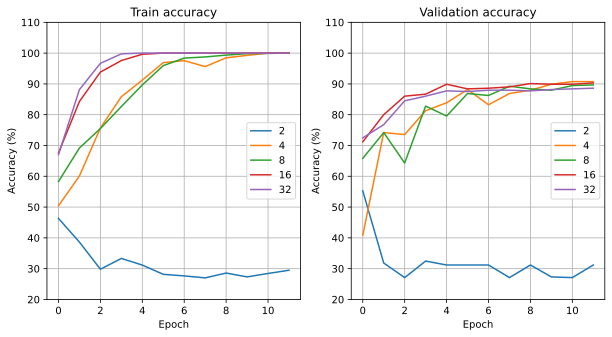

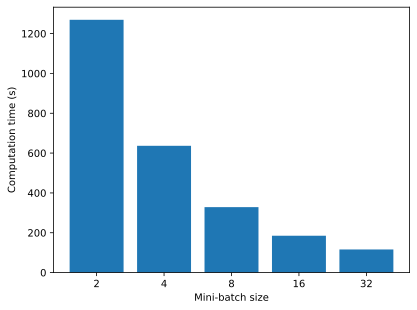

In [70]:
# plot the accuracies against the number of epochs for different batch sizes
fig,ax = plt.subplots(1,2,figsize=(10,5))

ax[0].plot(train_bs_acc)
ax[0].set_title('Train accuracy')
ax[1].plot(valid_bs_acc)
ax[1].set_title('Validation accuracy')

# common features
for i in range(2):
    ax[i].legend(cand_batch_sizes)
    ax[i].set_xlabel('Epoch')
    ax[i].set_ylabel('Accuracy (%)')
    ax[i].set_ylim([20,110])
    ax[i].grid()

plt.show()

# bar plot of computation time
plt.bar(range(len(train_time)),train_time,tick_label=cand_batch_sizes)
plt.xlabel('Mini-batch size')
plt.ylabel('Computation time (s)')
plt.show()

### Experiment with different loss functions

In [75]:
# Use a number of experimens to find the optimal value for learning rate
# For each experiment and each unique value of learning rate, 
# a new model will be created and trained 
num_experiments = 12

# Candidate loss functions (Cross-entropy without/with balanced weights, Cross-entropy with imbalanced weights, custom Focal Loss)
CELoss_weights = torch.FloatTensor(train_data_class_inv_ratio)
# If CUDA is available, put the weights on CUDA
if torch.cuda.is_available():
    CELoss_weights = CELoss_weights.to(torch.device("cuda"))
cand_loss_func = [nn.CrossEntropyLoss(), nn.CrossEntropyLoss(weight=CELoss_weights), customFocalLoss()]
# Create an ndarray to store the validation accuracies and confusion matrices.
loss_func_exp_accuracies = np.zeros((num_experiments, len(cand_loss_func)))
loss_func_exp_conf_mat = {'CELoss':[], 'Weighted_CELoss':[], 'FocalLoss':[]}

# set number of epochs 
num_of_epochs = 12
# set values of hyper-parameters that have been experimented 
# according to the experiment results above
learning_rate = 0.007
conv_out_channels = [16,32]
kernel_sizes = [6,3]
strides = [3,1]
paddings = [3,2]
maxpool_k_sizes = 2
fc_nUnit = 768
batch_size = 16
log_every_n_epoch = 2

# Define train and validation data loaders
train_loader = DataLoader(train_Dataset,batch_size=batch_size, shuffle=True, drop_last=True)
valid_loader = DataLoader(valid_Dataset, batch_size=valid_Dataset.tensors[0].shape[0])

In [76]:
# Perform the experiments.
for exp_i in range(num_experiments):
    print('Experiment %d'% exp_i)
    for j, loss_func in enumerate(cand_loss_func):
        if j == 0:
            print('Training with loss Cross-Entropy Loss')
        elif j == 1:
            print('Training with loss weighted Cross-Entropy Loss')
        elif j == 2:
            print('Training with loss Focal Loss')
        # Create a candidate brainMRIConvNet model object
        cand_brain_MRI_net = brainMRIConvNet(conv_out_channels, k_sizes=kernel_sizes, strides=strides, paddings=paddings,
                                             maxpool_k_sizes=maxpool_k_sizes, fc1_out_unit=fc_nUnit)
        
        # Define optimizer according to the result of previous experiment, with the current candidate learning rate 
        optimizer = torch.optim.SGD(cand_brain_MRI_net.parameters(), lr=learning_rate,momentum=0.9)
        
        # Train the candidate brainMRIConvNet model using the training function.
        _, valid_acc, _, _, val_conf_mat = trainBrainMRIConvNet(cand_brain_MRI_net, train_loader, valid_loader,
                                                                num_of_epochs, log_every_n_epoch,None,optimizer,loss_func)

        # Record the average validation accuracy for the last 3 epochs
        loss_func_exp_accuracies[exp_i, j] = np.mean(valid_acc[len(valid_acc)-3:])
        # Record the confusion matrix on the validation set for the last epoch
        if j == 0:
            loss_func_exp_conf_mat['CELoss'].append(val_conf_mat)
        elif j == 1:
            loss_func_exp_conf_mat['Weighted_CELoss'].append(val_conf_mat)
        elif j == 2:
            loss_func_exp_conf_mat['FocalLoss'].append(val_conf_mat)

Experiment 0
Training with loss Cross-Entropy Loss
First convolution layer output size: 43
Second convolution layer output size: 22
First FC linear layer input size: 15488


train-1: 100%|███████████████████████████████████████████████████████████████████████| 135/135 [00:41<00:00,  3.28it/s]


Epoch 1, Avg. Loss 0.358, Valid. Loss 0.468, Valid. Acc 84.301, Train Acc 86.620


train-3: 100%|███████████████████████████████████████████████████████████████████████| 135/135 [00:39<00:00,  3.40it/s]


Epoch 3, Avg. Loss 0.044, Valid. Loss 0.519, Valid. Acc 86.882, Train Acc 98.796


train-5: 100%|███████████████████████████████████████████████████████████████████████| 135/135 [00:38<00:00,  3.47it/s]


Epoch 5, Avg. Loss 0.002, Valid. Loss 0.513, Valid. Acc 87.742, Train Acc 100.000


train-7: 100%|███████████████████████████████████████████████████████████████████████| 135/135 [00:41<00:00,  3.26it/s]


Epoch 7, Avg. Loss 0.000, Valid. Loss 0.523, Valid. Acc 87.527, Train Acc 100.000


train-9: 100%|███████████████████████████████████████████████████████████████████████| 135/135 [00:40<00:00,  3.36it/s]


Epoch 9, Avg. Loss 0.000, Valid. Loss 0.514, Valid. Acc 88.387, Train Acc 100.000


train-11: 100%|██████████████████████████████████████████████████████████████████████| 135/135 [00:39<00:00,  3.40it/s]


Epoch 11, Avg. Loss 0.000, Valid. Loss 0.523, Valid. Acc 87.742, Train Acc 100.000
Training with loss weighted Cross-Entropy Loss
First convolution layer output size: 43
Second convolution layer output size: 22
First FC linear layer input size: 15488


train-1: 100%|███████████████████████████████████████████████████████████████████████| 135/135 [00:41<00:00,  3.25it/s]


Epoch 1, Avg. Loss 0.488, Valid. Loss 0.576, Valid. Acc 77.419, Train Acc 80.463


train-3: 100%|███████████████████████████████████████████████████████████████████████| 135/135 [00:40<00:00,  3.35it/s]


Epoch 3, Avg. Loss 0.090, Valid. Loss 0.465, Valid. Acc 89.032, Train Acc 96.991


train-5: 100%|███████████████████████████████████████████████████████████████████████| 135/135 [00:39<00:00,  3.44it/s]


Epoch 5, Avg. Loss 0.010, Valid. Loss 0.476, Valid. Acc 90.538, Train Acc 99.722


train-7: 100%|███████████████████████████████████████████████████████████████████████| 135/135 [00:41<00:00,  3.25it/s]


Epoch 7, Avg. Loss 0.001, Valid. Loss 0.504, Valid. Acc 89.462, Train Acc 100.000


train-9: 100%|███████████████████████████████████████████████████████████████████████| 135/135 [00:40<00:00,  3.31it/s]


Epoch 9, Avg. Loss 0.000, Valid. Loss 0.493, Valid. Acc 89.677, Train Acc 100.000


train-11: 100%|██████████████████████████████████████████████████████████████████████| 135/135 [00:39<00:00,  3.41it/s]


Epoch 11, Avg. Loss 0.000, Valid. Loss 0.508, Valid. Acc 89.892, Train Acc 100.000
Training with loss Focal Loss
First convolution layer output size: 43
Second convolution layer output size: 22
First FC linear layer input size: 15488


train-1: 100%|███████████████████████████████████████████████████████████████████████| 135/135 [00:41<00:00,  3.28it/s]


Epoch 1, Avg. Loss 0.163, Valid. Loss 0.293, Valid. Acc 75.054, Train Acc 82.593


train-3: 100%|███████████████████████████████████████████████████████████████████████| 135/135 [00:41<00:00,  3.28it/s]


Epoch 3, Avg. Loss 0.020, Valid. Loss 0.204, Valid. Acc 85.376, Train Acc 98.287


train-5: 100%|███████████████████████████████████████████████████████████████████████| 135/135 [00:40<00:00,  3.31it/s]


Epoch 5, Avg. Loss 0.000, Valid. Loss 0.178, Valid. Acc 90.323, Train Acc 100.000


train-7: 100%|███████████████████████████████████████████████████████████████████████| 135/135 [00:41<00:00,  3.24it/s]


Epoch 7, Avg. Loss 0.000, Valid. Loss 0.181, Valid. Acc 90.108, Train Acc 100.000


train-9: 100%|███████████████████████████████████████████████████████████████████████| 135/135 [00:41<00:00,  3.27it/s]


Epoch 9, Avg. Loss 0.000, Valid. Loss 0.183, Valid. Acc 89.892, Train Acc 100.000


train-11: 100%|██████████████████████████████████████████████████████████████████████| 135/135 [00:41<00:00,  3.29it/s]


Epoch 11, Avg. Loss 0.000, Valid. Loss 0.184, Valid. Acc 90.108, Train Acc 100.000
Experiment 1
Training with loss Cross-Entropy Loss
First convolution layer output size: 43
Second convolution layer output size: 22
First FC linear layer input size: 15488


train-1: 100%|███████████████████████████████████████████████████████████████████████| 135/135 [00:41<00:00,  3.28it/s]


Epoch 1, Avg. Loss 0.394, Valid. Loss 0.637, Valid. Acc 75.054, Train Acc 85.787


train-3: 100%|███████████████████████████████████████████████████████████████████████| 135/135 [00:40<00:00,  3.35it/s]


Epoch 3, Avg. Loss 0.052, Valid. Loss 0.488, Valid. Acc 87.097, Train Acc 98.287


train-5: 100%|███████████████████████████████████████████████████████████████████████| 135/135 [00:40<00:00,  3.33it/s]


Epoch 5, Avg. Loss 0.013, Valid. Loss 0.725, Valid. Acc 81.075, Train Acc 99.630


train-7: 100%|███████████████████████████████████████████████████████████████████████| 135/135 [00:41<00:00,  3.24it/s]


Epoch 7, Avg. Loss 0.000, Valid. Loss 0.475, Valid. Acc 88.817, Train Acc 100.000


train-9: 100%|███████████████████████████████████████████████████████████████████████| 135/135 [00:40<00:00,  3.34it/s]


Epoch 9, Avg. Loss 0.000, Valid. Loss 0.488, Valid. Acc 89.247, Train Acc 100.000


train-11: 100%|██████████████████████████████████████████████████████████████████████| 135/135 [00:41<00:00,  3.27it/s]


Epoch 11, Avg. Loss 0.000, Valid. Loss 0.490, Valid. Acc 89.677, Train Acc 100.000
Training with loss weighted Cross-Entropy Loss
First convolution layer output size: 43
Second convolution layer output size: 22
First FC linear layer input size: 15488


train-1: 100%|███████████████████████████████████████████████████████████████████████| 135/135 [00:40<00:00,  3.34it/s]


Epoch 1, Avg. Loss 0.452, Valid. Loss 0.570, Valid. Acc 80.000, Train Acc 83.056


train-3: 100%|███████████████████████████████████████████████████████████████████████| 135/135 [00:39<00:00,  3.38it/s]


Epoch 3, Avg. Loss 0.140, Valid. Loss 0.503, Valid. Acc 85.161, Train Acc 94.630


train-5: 100%|███████████████████████████████████████████████████████████████████████| 135/135 [00:40<00:00,  3.30it/s]


Epoch 5, Avg. Loss 0.017, Valid. Loss 0.558, Valid. Acc 88.602, Train Acc 99.306


train-7: 100%|███████████████████████████████████████████████████████████████████████| 135/135 [00:40<00:00,  3.32it/s]


Epoch 7, Avg. Loss 0.001, Valid. Loss 0.516, Valid. Acc 90.108, Train Acc 100.000


train-9: 100%|███████████████████████████████████████████████████████████████████████| 135/135 [00:40<00:00,  3.35it/s]


Epoch 9, Avg. Loss 0.000, Valid. Loss 0.513, Valid. Acc 89.892, Train Acc 100.000


train-11: 100%|██████████████████████████████████████████████████████████████████████| 135/135 [00:40<00:00,  3.32it/s]


Epoch 11, Avg. Loss 0.000, Valid. Loss 0.531, Valid. Acc 89.892, Train Acc 100.000
Training with loss Focal Loss
First convolution layer output size: 43
Second convolution layer output size: 22
First FC linear layer input size: 15488


train-1: 100%|███████████████████████████████████████████████████████████████████████| 135/135 [00:40<00:00,  3.37it/s]


Epoch 1, Avg. Loss 0.155, Valid. Loss 0.249, Valid. Acc 79.570, Train Acc 84.398


train-3: 100%|███████████████████████████████████████████████████████████████████████| 135/135 [00:39<00:00,  3.43it/s]


Epoch 3, Avg. Loss 0.016, Valid. Loss 0.332, Valid. Acc 80.000, Train Acc 98.519


train-5: 100%|███████████████████████████████████████████████████████████████████████| 135/135 [00:41<00:00,  3.23it/s]


Epoch 5, Avg. Loss 0.000, Valid. Loss 0.195, Valid. Acc 90.753, Train Acc 100.000


train-7: 100%|███████████████████████████████████████████████████████████████████████| 135/135 [00:40<00:00,  3.32it/s]


Epoch 7, Avg. Loss 0.000, Valid. Loss 0.197, Valid. Acc 90.323, Train Acc 100.000


train-9: 100%|███████████████████████████████████████████████████████████████████████| 135/135 [00:35<00:00,  3.78it/s]


Epoch 9, Avg. Loss 0.000, Valid. Loss 0.202, Valid. Acc 90.538, Train Acc 100.000


train-11: 100%|██████████████████████████████████████████████████████████████████████| 135/135 [00:41<00:00,  3.21it/s]


Epoch 11, Avg. Loss 0.000, Valid. Loss 0.202, Valid. Acc 90.753, Train Acc 100.000
Experiment 2
Training with loss Cross-Entropy Loss
First convolution layer output size: 43
Second convolution layer output size: 22
First FC linear layer input size: 15488


train-1: 100%|███████████████████████████████████████████████████████████████████████| 135/135 [00:40<00:00,  3.36it/s]


Epoch 1, Avg. Loss 0.391, Valid. Loss 0.533, Valid. Acc 83.656, Train Acc 84.398


train-3: 100%|███████████████████████████████████████████████████████████████████████| 135/135 [00:38<00:00,  3.48it/s]


Epoch 3, Avg. Loss 0.046, Valid. Loss 0.499, Valid. Acc 87.742, Train Acc 98.333


train-5: 100%|███████████████████████████████████████████████████████████████████████| 135/135 [00:41<00:00,  3.29it/s]


Epoch 5, Avg. Loss 0.008, Valid. Loss 0.491, Valid. Acc 88.817, Train Acc 99.769


train-7: 100%|███████████████████████████████████████████████████████████████████████| 135/135 [00:40<00:00,  3.33it/s]


Epoch 7, Avg. Loss 0.000, Valid. Loss 0.518, Valid. Acc 88.602, Train Acc 100.000


train-9: 100%|███████████████████████████████████████████████████████████████████████| 135/135 [00:39<00:00,  3.38it/s]


Epoch 9, Avg. Loss 0.000, Valid. Loss 0.531, Valid. Acc 88.602, Train Acc 100.000


train-11: 100%|██████████████████████████████████████████████████████████████████████| 135/135 [00:41<00:00,  3.25it/s]


Epoch 11, Avg. Loss 0.000, Valid. Loss 0.541, Valid. Acc 89.462, Train Acc 100.000
Training with loss weighted Cross-Entropy Loss
First convolution layer output size: 43
Second convolution layer output size: 22
First FC linear layer input size: 15488


train-1: 100%|███████████████████████████████████████████████████████████████████████| 135/135 [00:35<00:00,  3.79it/s]


Epoch 1, Avg. Loss 0.448, Valid. Loss 0.536, Valid. Acc 83.226, Train Acc 81.157


train-3: 100%|███████████████████████████████████████████████████████████████████████| 135/135 [00:39<00:00,  3.44it/s]


Epoch 3, Avg. Loss 0.085, Valid. Loss 0.516, Valid. Acc 85.161, Train Acc 96.944


train-5: 100%|███████████████████████████████████████████████████████████████████████| 135/135 [00:41<00:00,  3.25it/s]


Epoch 5, Avg. Loss 0.006, Valid. Loss 0.403, Valid. Acc 90.323, Train Acc 99.907


train-7: 100%|███████████████████████████████████████████████████████████████████████| 135/135 [00:40<00:00,  3.33it/s]


Epoch 7, Avg. Loss 0.000, Valid. Loss 0.429, Valid. Acc 90.538, Train Acc 100.000


train-9: 100%|███████████████████████████████████████████████████████████████████████| 135/135 [00:40<00:00,  3.35it/s]


Epoch 9, Avg. Loss 0.000, Valid. Loss 0.441, Valid. Acc 90.753, Train Acc 100.000


train-11: 100%|██████████████████████████████████████████████████████████████████████| 135/135 [00:40<00:00,  3.30it/s]


Epoch 11, Avg. Loss 0.000, Valid. Loss 0.445, Valid. Acc 90.968, Train Acc 100.000
Training with loss Focal Loss
First convolution layer output size: 43
Second convolution layer output size: 22
First FC linear layer input size: 15488


train-1: 100%|███████████████████████████████████████████████████████████████████████| 135/135 [00:40<00:00,  3.35it/s]


Epoch 1, Avg. Loss 0.142, Valid. Loss 0.228, Valid. Acc 81.505, Train Acc 85.648


train-3: 100%|███████████████████████████████████████████████████████████████████████| 135/135 [00:40<00:00,  3.35it/s]


Epoch 3, Avg. Loss 0.016, Valid. Loss 0.222, Valid. Acc 87.742, Train Acc 98.241


train-5: 100%|███████████████████████████████████████████████████████████████████████| 135/135 [00:41<00:00,  3.26it/s]


Epoch 5, Avg. Loss 0.000, Valid. Loss 0.209, Valid. Acc 89.892, Train Acc 100.000


train-7: 100%|███████████████████████████████████████████████████████████████████████| 135/135 [00:40<00:00,  3.30it/s]


Epoch 7, Avg. Loss 0.000, Valid. Loss 0.219, Valid. Acc 89.462, Train Acc 100.000


train-9: 100%|███████████████████████████████████████████████████████████████████████| 135/135 [00:40<00:00,  3.33it/s]


Epoch 9, Avg. Loss 0.000, Valid. Loss 0.221, Valid. Acc 89.247, Train Acc 100.000


train-11: 100%|██████████████████████████████████████████████████████████████████████| 135/135 [00:40<00:00,  3.33it/s]


Epoch 11, Avg. Loss 0.000, Valid. Loss 0.225, Valid. Acc 88.817, Train Acc 100.000
Experiment 3
Training with loss Cross-Entropy Loss
First convolution layer output size: 43
Second convolution layer output size: 22
First FC linear layer input size: 15488


train-1: 100%|███████████████████████████████████████████████████████████████████████| 135/135 [00:40<00:00,  3.30it/s]


Epoch 1, Avg. Loss 0.415, Valid. Loss 0.516, Valid. Acc 79.355, Train Acc 84.398


train-3: 100%|███████████████████████████████████████████████████████████████████████| 135/135 [00:40<00:00,  3.32it/s]


Epoch 3, Avg. Loss 0.115, Valid. Loss 0.611, Valid. Acc 83.871, Train Acc 95.694


train-5: 100%|███████████████████████████████████████████████████████████████████████| 135/135 [00:41<00:00,  3.28it/s]


Epoch 5, Avg. Loss 0.023, Valid. Loss 0.527, Valid. Acc 87.742, Train Acc 99.306


train-7: 100%|███████████████████████████████████████████████████████████████████████| 135/135 [00:40<00:00,  3.33it/s]


Epoch 7, Avg. Loss 0.001, Valid. Loss 0.548, Valid. Acc 88.387, Train Acc 100.000


train-9: 100%|███████████████████████████████████████████████████████████████████████| 135/135 [00:41<00:00,  3.29it/s]


Epoch 9, Avg. Loss 0.000, Valid. Loss 0.553, Valid. Acc 88.387, Train Acc 100.000


train-11: 100%|██████████████████████████████████████████████████████████████████████| 135/135 [00:40<00:00,  3.36it/s]


Epoch 11, Avg. Loss 0.000, Valid. Loss 0.567, Valid. Acc 88.387, Train Acc 100.000
Training with loss weighted Cross-Entropy Loss
First convolution layer output size: 43
Second convolution layer output size: 22
First FC linear layer input size: 15488


train-1: 100%|███████████████████████████████████████████████████████████████████████| 135/135 [00:39<00:00,  3.39it/s]


Epoch 1, Avg. Loss 0.469, Valid. Loss 0.521, Valid. Acc 79.355, Train Acc 80.741


train-3: 100%|███████████████████████████████████████████████████████████████████████| 135/135 [00:40<00:00,  3.34it/s]


Epoch 3, Avg. Loss 0.057, Valid. Loss 0.506, Valid. Acc 86.667, Train Acc 97.824


train-5: 100%|███████████████████████████████████████████████████████████████████████| 135/135 [00:40<00:00,  3.30it/s]


Epoch 5, Avg. Loss 0.005, Valid. Loss 0.494, Valid. Acc 90.538, Train Acc 99.954


train-7: 100%|███████████████████████████████████████████████████████████████████████| 135/135 [00:39<00:00,  3.42it/s]


Epoch 7, Avg. Loss 0.000, Valid. Loss 0.501, Valid. Acc 90.108, Train Acc 100.000


train-9: 100%|███████████████████████████████████████████████████████████████████████| 135/135 [00:41<00:00,  3.28it/s]


Epoch 9, Avg. Loss 0.000, Valid. Loss 0.516, Valid. Acc 90.108, Train Acc 100.000


train-11: 100%|██████████████████████████████████████████████████████████████████████| 135/135 [00:40<00:00,  3.34it/s]


Epoch 11, Avg. Loss 0.000, Valid. Loss 0.518, Valid. Acc 90.538, Train Acc 100.000
Training with loss Focal Loss
First convolution layer output size: 43
Second convolution layer output size: 22
First FC linear layer input size: 15488


train-1: 100%|███████████████████████████████████████████████████████████████████████| 135/135 [00:39<00:00,  3.43it/s]


Epoch 1, Avg. Loss 0.125, Valid. Loss 0.168, Valid. Acc 84.946, Train Acc 86.759


train-3: 100%|███████████████████████████████████████████████████████████████████████| 135/135 [00:40<00:00,  3.30it/s]


Epoch 3, Avg. Loss 0.014, Valid. Loss 0.206, Valid. Acc 87.312, Train Acc 98.194


train-5: 100%|███████████████████████████████████████████████████████████████████████| 135/135 [00:40<00:00,  3.35it/s]


Epoch 5, Avg. Loss 0.001, Valid. Loss 0.189, Valid. Acc 89.247, Train Acc 99.954


train-7: 100%|███████████████████████████████████████████████████████████████████████| 135/135 [00:39<00:00,  3.42it/s]


Epoch 7, Avg. Loss 0.000, Valid. Loss 0.199, Valid. Acc 89.247, Train Acc 100.000


train-9: 100%|███████████████████████████████████████████████████████████████████████| 135/135 [00:40<00:00,  3.33it/s]


Epoch 9, Avg. Loss 0.000, Valid. Loss 0.202, Valid. Acc 89.462, Train Acc 100.000


train-11: 100%|██████████████████████████████████████████████████████████████████████| 135/135 [00:40<00:00,  3.32it/s]


Epoch 11, Avg. Loss 0.000, Valid. Loss 0.204, Valid. Acc 89.462, Train Acc 100.000
Experiment 4
Training with loss Cross-Entropy Loss
First convolution layer output size: 43
Second convolution layer output size: 22
First FC linear layer input size: 15488


train-1: 100%|███████████████████████████████████████████████████████████████████████| 135/135 [00:39<00:00,  3.42it/s]


Epoch 1, Avg. Loss 0.436, Valid. Loss 0.514, Valid. Acc 81.075, Train Acc 82.917


train-3: 100%|███████████████████████████████████████████████████████████████████████| 135/135 [00:41<00:00,  3.26it/s]


Epoch 3, Avg. Loss 0.075, Valid. Loss 0.497, Valid. Acc 86.022, Train Acc 97.639


train-5: 100%|███████████████████████████████████████████████████████████████████████| 135/135 [00:40<00:00,  3.35it/s]


Epoch 5, Avg. Loss 0.031, Valid. Loss 0.509, Valid. Acc 88.172, Train Acc 98.981


train-7: 100%|███████████████████████████████████████████████████████████████████████| 135/135 [00:39<00:00,  3.41it/s]


Epoch 7, Avg. Loss 0.004, Valid. Loss 0.516, Valid. Acc 88.387, Train Acc 99.907


train-9: 100%|███████████████████████████████████████████████████████████████████████| 135/135 [00:41<00:00,  3.24it/s]


Epoch 9, Avg. Loss 0.000, Valid. Loss 0.494, Valid. Acc 89.247, Train Acc 100.000


train-11: 100%|██████████████████████████████████████████████████████████████████████| 135/135 [00:40<00:00,  3.31it/s]


Epoch 11, Avg. Loss 0.000, Valid. Loss 0.500, Valid. Acc 89.247, Train Acc 100.000
Training with loss weighted Cross-Entropy Loss
First convolution layer output size: 43
Second convolution layer output size: 22
First FC linear layer input size: 15488


train-1: 100%|███████████████████████████████████████████████████████████████████████| 135/135 [00:39<00:00,  3.42it/s]


Epoch 1, Avg. Loss 0.489, Valid. Loss 0.647, Valid. Acc 74.194, Train Acc 81.296


train-3: 100%|███████████████████████████████████████████████████████████████████████| 135/135 [00:41<00:00,  3.29it/s]


Epoch 3, Avg. Loss 0.103, Valid. Loss 0.624, Valid. Acc 80.860, Train Acc 96.481


train-5: 100%|███████████████████████████████████████████████████████████████████████| 135/135 [00:39<00:00,  3.40it/s]


Epoch 5, Avg. Loss 0.013, Valid. Loss 0.522, Valid. Acc 89.032, Train Acc 99.491


train-7: 100%|███████████████████████████████████████████████████████████████████████| 135/135 [00:40<00:00,  3.36it/s]


Epoch 7, Avg. Loss 0.013, Valid. Loss 0.522, Valid. Acc 89.462, Train Acc 99.491


train-9: 100%|███████████████████████████████████████████████████████████████████████| 135/135 [00:41<00:00,  3.29it/s]


Epoch 9, Avg. Loss 0.001, Valid. Loss 0.516, Valid. Acc 89.247, Train Acc 100.000


train-11: 100%|██████████████████████████████████████████████████████████████████████| 135/135 [00:40<00:00,  3.32it/s]


Epoch 11, Avg. Loss 0.000, Valid. Loss 0.525, Valid. Acc 88.817, Train Acc 100.000
Training with loss Focal Loss
First convolution layer output size: 43
Second convolution layer output size: 22
First FC linear layer input size: 15488


train-1: 100%|███████████████████████████████████████████████████████████████████████| 135/135 [00:41<00:00,  3.26it/s]


Epoch 1, Avg. Loss 0.113, Valid. Loss 0.221, Valid. Acc 81.935, Train Acc 88.241


train-3: 100%|███████████████████████████████████████████████████████████████████████| 135/135 [00:41<00:00,  3.25it/s]


Epoch 3, Avg. Loss 0.009, Valid. Loss 0.216, Valid. Acc 87.527, Train Acc 98.750


train-5: 100%|███████████████████████████████████████████████████████████████████████| 135/135 [00:40<00:00,  3.33it/s]


Epoch 5, Avg. Loss 0.000, Valid. Loss 0.181, Valid. Acc 89.247, Train Acc 100.000


train-7: 100%|███████████████████████████████████████████████████████████████████████| 135/135 [00:41<00:00,  3.27it/s]


Epoch 7, Avg. Loss 0.000, Valid. Loss 0.186, Valid. Acc 89.462, Train Acc 100.000


train-9: 100%|███████████████████████████████████████████████████████████████████████| 135/135 [00:41<00:00,  3.26it/s]


Epoch 9, Avg. Loss 0.000, Valid. Loss 0.185, Valid. Acc 89.247, Train Acc 100.000


train-11: 100%|██████████████████████████████████████████████████████████████████████| 135/135 [00:40<00:00,  3.32it/s]


Epoch 11, Avg. Loss 0.000, Valid. Loss 0.188, Valid. Acc 89.247, Train Acc 100.000
Experiment 5
Training with loss Cross-Entropy Loss
First convolution layer output size: 43
Second convolution layer output size: 22
First FC linear layer input size: 15488


train-1: 100%|███████████████████████████████████████████████████████████████████████| 135/135 [00:41<00:00,  3.27it/s]


Epoch 1, Avg. Loss 0.524, Valid. Loss 0.466, Valid. Acc 80.645, Train Acc 79.722


train-3: 100%|███████████████████████████████████████████████████████████████████████| 135/135 [00:40<00:00,  3.31it/s]


Epoch 3, Avg. Loss 0.098, Valid. Loss 0.509, Valid. Acc 86.237, Train Acc 96.481


train-5: 100%|███████████████████████████████████████████████████████████████████████| 135/135 [00:39<00:00,  3.40it/s]


Epoch 5, Avg. Loss 0.021, Valid. Loss 0.626, Valid. Acc 86.452, Train Acc 99.352


train-7: 100%|███████████████████████████████████████████████████████████████████████| 135/135 [00:41<00:00,  3.29it/s]


Epoch 7, Avg. Loss 0.003, Valid. Loss 0.470, Valid. Acc 89.892, Train Acc 99.954


train-9: 100%|███████████████████████████████████████████████████████████████████████| 135/135 [00:41<00:00,  3.29it/s]


Epoch 9, Avg. Loss 0.000, Valid. Loss 0.487, Valid. Acc 89.677, Train Acc 100.000


train-11: 100%|██████████████████████████████████████████████████████████████████████| 135/135 [00:40<00:00,  3.35it/s]


Epoch 11, Avg. Loss 0.000, Valid. Loss 0.498, Valid. Acc 89.892, Train Acc 100.000
Training with loss weighted Cross-Entropy Loss
First convolution layer output size: 43
Second convolution layer output size: 22
First FC linear layer input size: 15488


train-1: 100%|███████████████████████████████████████████████████████████████████████| 135/135 [00:41<00:00,  3.24it/s]


Epoch 1, Avg. Loss 0.423, Valid. Loss 0.498, Valid. Acc 77.634, Train Acc 82.963


train-3: 100%|███████████████████████████████████████████████████████████████████████| 135/135 [00:40<00:00,  3.32it/s]


Epoch 3, Avg. Loss 0.072, Valid. Loss 0.468, Valid. Acc 86.022, Train Acc 97.407


train-5: 100%|███████████████████████████████████████████████████████████████████████| 135/135 [00:39<00:00,  3.41it/s]


Epoch 5, Avg. Loss 0.005, Valid. Loss 0.437, Valid. Acc 88.602, Train Acc 100.000


train-7: 100%|███████████████████████████████████████████████████████████████████████| 135/135 [00:41<00:00,  3.29it/s]


Epoch 7, Avg. Loss 0.000, Valid. Loss 0.466, Valid. Acc 88.817, Train Acc 100.000


train-9: 100%|███████████████████████████████████████████████████████████████████████| 135/135 [00:40<00:00,  3.37it/s]


Epoch 9, Avg. Loss 0.000, Valid. Loss 0.474, Valid. Acc 88.817, Train Acc 100.000


train-11: 100%|██████████████████████████████████████████████████████████████████████| 135/135 [00:39<00:00,  3.44it/s]


Epoch 11, Avg. Loss 0.000, Valid. Loss 0.483, Valid. Acc 89.032, Train Acc 100.000
Training with loss Focal Loss
First convolution layer output size: 43
Second convolution layer output size: 22
First FC linear layer input size: 15488


train-1: 100%|███████████████████████████████████████████████████████████████████████| 135/135 [00:41<00:00,  3.25it/s]


Epoch 1, Avg. Loss 0.155, Valid. Loss 0.225, Valid. Acc 80.645, Train Acc 83.056


train-3: 100%|███████████████████████████████████████████████████████████████████████| 135/135 [00:40<00:00,  3.34it/s]


Epoch 3, Avg. Loss 0.011, Valid. Loss 0.210, Valid. Acc 86.882, Train Acc 98.796


train-5: 100%|███████████████████████████████████████████████████████████████████████| 135/135 [00:39<00:00,  3.46it/s]


Epoch 5, Avg. Loss 0.002, Valid. Loss 0.181, Valid. Acc 89.892, Train Acc 99.722


train-7: 100%|███████████████████████████████████████████████████████████████████████| 135/135 [00:41<00:00,  3.24it/s]


Epoch 7, Avg. Loss 0.000, Valid. Loss 0.189, Valid. Acc 88.387, Train Acc 100.000


train-9: 100%|███████████████████████████████████████████████████████████████████████| 135/135 [00:41<00:00,  3.25it/s]


Epoch 9, Avg. Loss 0.000, Valid. Loss 0.195, Valid. Acc 88.817, Train Acc 100.000


train-11: 100%|██████████████████████████████████████████████████████████████████████| 135/135 [00:40<00:00,  3.33it/s]


Epoch 11, Avg. Loss 0.000, Valid. Loss 0.196, Valid. Acc 88.817, Train Acc 100.000
Experiment 6
Training with loss Cross-Entropy Loss
First convolution layer output size: 43
Second convolution layer output size: 22
First FC linear layer input size: 15488


train-1: 100%|███████████████████████████████████████████████████████████████████████| 135/135 [00:41<00:00,  3.25it/s]


Epoch 1, Avg. Loss 0.422, Valid. Loss 0.489, Valid. Acc 80.430, Train Acc 83.981


train-3: 100%|███████████████████████████████████████████████████████████████████████| 135/135 [00:39<00:00,  3.39it/s]


Epoch 3, Avg. Loss 0.057, Valid. Loss 0.532, Valid. Acc 87.097, Train Acc 97.778


train-5: 100%|███████████████████████████████████████████████████████████████████████| 135/135 [00:40<00:00,  3.30it/s]


Epoch 5, Avg. Loss 0.002, Valid. Loss 0.461, Valid. Acc 89.032, Train Acc 100.000


train-7: 100%|███████████████████████████████████████████████████████████████████████| 135/135 [00:41<00:00,  3.28it/s]


Epoch 7, Avg. Loss 0.000, Valid. Loss 0.488, Valid. Acc 89.032, Train Acc 100.000


train-9: 100%|███████████████████████████████████████████████████████████████████████| 135/135 [00:40<00:00,  3.32it/s]


Epoch 9, Avg. Loss 0.000, Valid. Loss 0.495, Valid. Acc 89.032, Train Acc 100.000


train-11: 100%|██████████████████████████████████████████████████████████████████████| 135/135 [00:40<00:00,  3.33it/s]


Epoch 11, Avg. Loss 0.000, Valid. Loss 0.503, Valid. Acc 88.817, Train Acc 100.000
Training with loss weighted Cross-Entropy Loss
First convolution layer output size: 43
Second convolution layer output size: 22
First FC linear layer input size: 15488


train-1: 100%|███████████████████████████████████████████████████████████████████████| 135/135 [00:41<00:00,  3.29it/s]


Epoch 1, Avg. Loss 0.536, Valid. Loss 0.689, Valid. Acc 72.903, Train Acc 79.491


train-3: 100%|███████████████████████████████████████████████████████████████████████| 135/135 [00:40<00:00,  3.34it/s]


Epoch 3, Avg. Loss 0.179, Valid. Loss 0.469, Valid. Acc 86.667, Train Acc 93.333


train-5: 100%|███████████████████████████████████████████████████████████████████████| 135/135 [00:41<00:00,  3.25it/s]


Epoch 5, Avg. Loss 0.013, Valid. Loss 0.416, Valid. Acc 90.323, Train Acc 99.630


train-7: 100%|███████████████████████████████████████████████████████████████████████| 135/135 [00:41<00:00,  3.27it/s]


Epoch 7, Avg. Loss 0.001, Valid. Loss 0.449, Valid. Acc 90.968, Train Acc 100.000


train-9: 100%|███████████████████████████████████████████████████████████████████████| 135/135 [00:40<00:00,  3.35it/s]


Epoch 9, Avg. Loss 0.000, Valid. Loss 0.468, Valid. Acc 90.538, Train Acc 100.000


train-11: 100%|██████████████████████████████████████████████████████████████████████| 135/135 [00:40<00:00,  3.31it/s]


Epoch 11, Avg. Loss 0.000, Valid. Loss 0.476, Valid. Acc 90.538, Train Acc 100.000
Training with loss Focal Loss
First convolution layer output size: 43
Second convolution layer output size: 22
First FC linear layer input size: 15488


train-1: 100%|███████████████████████████████████████████████████████████████████████| 135/135 [00:41<00:00,  3.29it/s]


Epoch 1, Avg. Loss 0.123, Valid. Loss 0.213, Valid. Acc 81.720, Train Acc 87.222


train-3: 100%|███████████████████████████████████████████████████████████████████████| 135/135 [00:37<00:00,  3.59it/s]


Epoch 3, Avg. Loss 0.010, Valid. Loss 0.181, Valid. Acc 88.387, Train Acc 98.657


train-5: 100%|███████████████████████████████████████████████████████████████████████| 135/135 [00:41<00:00,  3.29it/s]


Epoch 5, Avg. Loss 0.000, Valid. Loss 0.176, Valid. Acc 89.677, Train Acc 100.000


train-7: 100%|███████████████████████████████████████████████████████████████████████| 135/135 [00:41<00:00,  3.27it/s]


Epoch 7, Avg. Loss 0.000, Valid. Loss 0.182, Valid. Acc 90.323, Train Acc 100.000


train-9: 100%|███████████████████████████████████████████████████████████████████████| 135/135 [00:39<00:00,  3.39it/s]


Epoch 9, Avg. Loss 0.000, Valid. Loss 0.183, Valid. Acc 89.892, Train Acc 100.000


train-11: 100%|██████████████████████████████████████████████████████████████████████| 135/135 [00:40<00:00,  3.31it/s]


Epoch 11, Avg. Loss 0.000, Valid. Loss 0.185, Valid. Acc 90.323, Train Acc 100.000
Experiment 7
Training with loss Cross-Entropy Loss
First convolution layer output size: 43
Second convolution layer output size: 22
First FC linear layer input size: 15488


train-1: 100%|███████████████████████████████████████████████████████████████████████| 135/135 [00:40<00:00,  3.32it/s]


Epoch 1, Avg. Loss 0.357, Valid. Loss 0.511, Valid. Acc 83.871, Train Acc 86.157


train-3: 100%|███████████████████████████████████████████████████████████████████████| 135/135 [00:39<00:00,  3.42it/s]


Epoch 3, Avg. Loss 0.051, Valid. Loss 0.570, Valid. Acc 86.022, Train Acc 98.287


train-5: 100%|███████████████████████████████████████████████████████████████████████| 135/135 [00:40<00:00,  3.32it/s]


Epoch 5, Avg. Loss 0.003, Valid. Loss 0.513, Valid. Acc 89.677, Train Acc 99.907


train-7: 100%|███████████████████████████████████████████████████████████████████████| 135/135 [00:40<00:00,  3.30it/s]


Epoch 7, Avg. Loss 0.000, Valid. Loss 0.533, Valid. Acc 89.677, Train Acc 100.000


train-9: 100%|███████████████████████████████████████████████████████████████████████| 135/135 [00:39<00:00,  3.43it/s]


Epoch 9, Avg. Loss 0.000, Valid. Loss 0.559, Valid. Acc 89.462, Train Acc 100.000


train-11: 100%|██████████████████████████████████████████████████████████████████████| 135/135 [00:41<00:00,  3.25it/s]


Epoch 11, Avg. Loss 0.000, Valid. Loss 0.550, Valid. Acc 89.677, Train Acc 100.000
Training with loss weighted Cross-Entropy Loss
First convolution layer output size: 43
Second convolution layer output size: 22
First FC linear layer input size: 15488


train-1: 100%|███████████████████████████████████████████████████████████████████████| 135/135 [00:40<00:00,  3.37it/s]


Epoch 1, Avg. Loss 0.433, Valid. Loss 0.517, Valid. Acc 81.505, Train Acc 82.037


train-3: 100%|███████████████████████████████████████████████████████████████████████| 135/135 [00:39<00:00,  3.45it/s]


Epoch 3, Avg. Loss 0.119, Valid. Loss 0.505, Valid. Acc 86.022, Train Acc 95.231


train-5: 100%|███████████████████████████████████████████████████████████████████████| 135/135 [00:40<00:00,  3.31it/s]


Epoch 5, Avg. Loss 0.011, Valid. Loss 0.445, Valid. Acc 89.247, Train Acc 99.769


train-7: 100%|███████████████████████████████████████████████████████████████████████| 135/135 [00:40<00:00,  3.33it/s]


Epoch 7, Avg. Loss 0.016, Valid. Loss 0.496, Valid. Acc 88.817, Train Acc 99.352


train-9: 100%|███████████████████████████████████████████████████████████████████████| 135/135 [00:39<00:00,  3.38it/s]


Epoch 9, Avg. Loss 0.001, Valid. Loss 0.511, Valid. Acc 88.602, Train Acc 100.000


train-11: 100%|██████████████████████████████████████████████████████████████████████| 135/135 [00:41<00:00,  3.24it/s]


Epoch 11, Avg. Loss 0.000, Valid. Loss 0.530, Valid. Acc 89.677, Train Acc 100.000
Training with loss Focal Loss
First convolution layer output size: 43
Second convolution layer output size: 22
First FC linear layer input size: 15488


train-1: 100%|███████████████████████████████████████████████████████████████████████| 135/135 [00:40<00:00,  3.35it/s]


Epoch 1, Avg. Loss 0.168, Valid. Loss 0.251, Valid. Acc 78.710, Train Acc 81.991


train-3: 100%|███████████████████████████████████████████████████████████████████████| 135/135 [00:40<00:00,  3.36it/s]


Epoch 3, Avg. Loss 0.016, Valid. Loss 0.206, Valid. Acc 88.817, Train Acc 98.287


train-5: 100%|███████████████████████████████████████████████████████████████████████| 135/135 [00:41<00:00,  3.27it/s]


Epoch 5, Avg. Loss 0.003, Valid. Loss 0.274, Valid. Acc 88.387, Train Acc 99.907


train-7: 100%|███████████████████████████████████████████████████████████████████████| 135/135 [00:40<00:00,  3.32it/s]


Epoch 7, Avg. Loss 0.000, Valid. Loss 0.244, Valid. Acc 89.892, Train Acc 100.000


train-9: 100%|███████████████████████████████████████████████████████████████████████| 135/135 [00:41<00:00,  3.25it/s]


Epoch 9, Avg. Loss 0.000, Valid. Loss 0.245, Valid. Acc 89.247, Train Acc 100.000


train-11: 100%|██████████████████████████████████████████████████████████████████████| 135/135 [00:41<00:00,  3.28it/s]


Epoch 11, Avg. Loss 0.000, Valid. Loss 0.251, Valid. Acc 90.323, Train Acc 100.000
Experiment 8
Training with loss Cross-Entropy Loss
First convolution layer output size: 43
Second convolution layer output size: 22
First FC linear layer input size: 15488


train-1: 100%|███████████████████████████████████████████████████████████████████████| 135/135 [00:40<00:00,  3.30it/s]


Epoch 1, Avg. Loss 0.451, Valid. Loss 0.452, Valid. Acc 85.591, Train Acc 82.963


train-3: 100%|███████████████████████████████████████████████████████████████████████| 135/135 [00:41<00:00,  3.27it/s]


Epoch 3, Avg. Loss 0.092, Valid. Loss 0.565, Valid. Acc 85.161, Train Acc 97.083


train-5: 100%|███████████████████████████████████████████████████████████████████████| 135/135 [00:41<00:00,  3.23it/s]


Epoch 5, Avg. Loss 0.008, Valid. Loss 0.554, Valid. Acc 88.817, Train Acc 99.861


train-7: 100%|███████████████████████████████████████████████████████████████████████| 135/135 [00:40<00:00,  3.31it/s]


Epoch 7, Avg. Loss 0.003, Valid. Loss 0.503, Valid. Acc 89.677, Train Acc 99.907


train-9: 100%|███████████████████████████████████████████████████████████████████████| 135/135 [00:41<00:00,  3.24it/s]


Epoch 9, Avg. Loss 0.000, Valid. Loss 0.501, Valid. Acc 90.538, Train Acc 100.000


train-11: 100%|██████████████████████████████████████████████████████████████████████| 135/135 [00:41<00:00,  3.28it/s]


Epoch 11, Avg. Loss 0.000, Valid. Loss 0.511, Valid. Acc 90.968, Train Acc 100.000
Training with loss weighted Cross-Entropy Loss
First convolution layer output size: 43
Second convolution layer output size: 22
First FC linear layer input size: 15488


train-1: 100%|███████████████████████████████████████████████████████████████████████| 135/135 [00:39<00:00,  3.42it/s]


Epoch 1, Avg. Loss 0.396, Valid. Loss 0.519, Valid. Acc 81.290, Train Acc 85.370


train-3: 100%|███████████████████████████████████████████████████████████████████████| 135/135 [00:40<00:00,  3.34it/s]


Epoch 3, Avg. Loss 0.082, Valid. Loss 0.449, Valid. Acc 89.247, Train Acc 97.176


train-5: 100%|███████████████████████████████████████████████████████████████████████| 135/135 [00:41<00:00,  3.27it/s]


Epoch 5, Avg. Loss 0.011, Valid. Loss 0.435, Valid. Acc 90.538, Train Acc 99.907


train-7: 100%|███████████████████████████████████████████████████████████████████████| 135/135 [00:39<00:00,  3.39it/s]


Epoch 7, Avg. Loss 0.000, Valid. Loss 0.430, Valid. Acc 90.753, Train Acc 100.000


train-9: 100%|███████████████████████████████████████████████████████████████████████| 135/135 [00:41<00:00,  3.22it/s]


Epoch 9, Avg. Loss 0.000, Valid. Loss 0.442, Valid. Acc 90.753, Train Acc 100.000


train-11: 100%|██████████████████████████████████████████████████████████████████████| 135/135 [00:40<00:00,  3.34it/s]


Epoch 11, Avg. Loss 0.000, Valid. Loss 0.451, Valid. Acc 90.968, Train Acc 100.000
Training with loss Focal Loss
First convolution layer output size: 43
Second convolution layer output size: 22
First FC linear layer input size: 15488


train-1: 100%|███████████████████████████████████████████████████████████████████████| 135/135 [00:39<00:00,  3.42it/s]


Epoch 1, Avg. Loss 0.141, Valid. Loss 0.262, Valid. Acc 78.495, Train Acc 85.602


train-3: 100%|███████████████████████████████████████████████████████████████████████| 135/135 [00:41<00:00,  3.26it/s]


Epoch 3, Avg. Loss 0.019, Valid. Loss 0.205, Valid. Acc 85.376, Train Acc 97.963


train-5: 100%|███████████████████████████████████████████████████████████████████████| 135/135 [00:40<00:00,  3.36it/s]


Epoch 5, Avg. Loss 0.001, Valid. Loss 0.196, Valid. Acc 89.032, Train Acc 100.000


train-7: 100%|███████████████████████████████████████████████████████████████████████| 135/135 [00:39<00:00,  3.38it/s]


Epoch 7, Avg. Loss 0.000, Valid. Loss 0.202, Valid. Acc 89.462, Train Acc 100.000


train-9: 100%|███████████████████████████████████████████████████████████████████████| 135/135 [00:41<00:00,  3.27it/s]


Epoch 9, Avg. Loss 0.000, Valid. Loss 0.212, Valid. Acc 89.032, Train Acc 100.000


train-11: 100%|██████████████████████████████████████████████████████████████████████| 135/135 [00:40<00:00,  3.31it/s]


Epoch 11, Avg. Loss 0.000, Valid. Loss 0.211, Valid. Acc 89.247, Train Acc 100.000
Experiment 9
Training with loss Cross-Entropy Loss
First convolution layer output size: 43
Second convolution layer output size: 22
First FC linear layer input size: 15488


train-1: 100%|███████████████████████████████████████████████████████████████████████| 135/135 [00:39<00:00,  3.43it/s]


Epoch 1, Avg. Loss 0.367, Valid. Loss 0.522, Valid. Acc 82.581, Train Acc 84.676


train-3: 100%|███████████████████████████████████████████████████████████████████████| 135/135 [00:41<00:00,  3.25it/s]


Epoch 3, Avg. Loss 0.086, Valid. Loss 0.499, Valid. Acc 87.527, Train Acc 96.991


train-5: 100%|███████████████████████████████████████████████████████████████████████| 135/135 [00:40<00:00,  3.34it/s]


Epoch 5, Avg. Loss 0.002, Valid. Loss 0.425, Valid. Acc 89.462, Train Acc 100.000


train-7: 100%|███████████████████████████████████████████████████████████████████████| 135/135 [00:39<00:00,  3.41it/s]


Epoch 7, Avg. Loss 0.002, Valid. Loss 0.448, Valid. Acc 89.677, Train Acc 99.954


train-9: 100%|███████████████████████████████████████████████████████████████████████| 135/135 [00:41<00:00,  3.28it/s]


Epoch 9, Avg. Loss 0.000, Valid. Loss 0.427, Valid. Acc 89.892, Train Acc 100.000


train-11: 100%|██████████████████████████████████████████████████████████████████████| 135/135 [00:40<00:00,  3.33it/s]


Epoch 11, Avg. Loss 0.000, Valid. Loss 0.432, Valid. Acc 89.892, Train Acc 100.000
Training with loss weighted Cross-Entropy Loss
First convolution layer output size: 43
Second convolution layer output size: 22
First FC linear layer input size: 15488


train-1: 100%|███████████████████████████████████████████████████████████████████████| 135/135 [00:39<00:00,  3.39it/s]


Epoch 1, Avg. Loss 0.455, Valid. Loss 0.669, Valid. Acc 71.828, Train Acc 82.037


train-3: 100%|███████████████████████████████████████████████████████████████████████| 135/135 [00:41<00:00,  3.26it/s]


Epoch 3, Avg. Loss 0.122, Valid. Loss 0.390, Valid. Acc 89.247, Train Acc 95.602


train-5: 100%|███████████████████████████████████████████████████████████████████████| 135/135 [00:40<00:00,  3.32it/s]


Epoch 5, Avg. Loss 0.028, Valid. Loss 1.478, Valid. Acc 73.763, Train Acc 99.491


train-7: 100%|███████████████████████████████████████████████████████████████████████| 135/135 [00:41<00:00,  3.27it/s]


Epoch 7, Avg. Loss 0.004, Valid. Loss 0.421, Valid. Acc 90.108, Train Acc 99.907


train-9: 100%|███████████████████████████████████████████████████████████████████████| 135/135 [00:41<00:00,  3.29it/s]


Epoch 9, Avg. Loss 0.000, Valid. Loss 0.470, Valid. Acc 89.462, Train Acc 100.000


train-11: 100%|██████████████████████████████████████████████████████████████████████| 135/135 [00:40<00:00,  3.33it/s]


Epoch 11, Avg. Loss 0.000, Valid. Loss 0.478, Valid. Acc 89.892, Train Acc 100.000
Training with loss Focal Loss
First convolution layer output size: 43
Second convolution layer output size: 22
First FC linear layer input size: 15488


train-1: 100%|███████████████████████████████████████████████████████████████████████| 135/135 [00:41<00:00,  3.27it/s]


Epoch 1, Avg. Loss 0.134, Valid. Loss 0.195, Valid. Acc 83.226, Train Acc 86.620


train-3: 100%|███████████████████████████████████████████████████████████████████████| 135/135 [00:41<00:00,  3.29it/s]


Epoch 3, Avg. Loss 0.007, Valid. Loss 0.192, Valid. Acc 86.882, Train Acc 99.398


train-5: 100%|███████████████████████████████████████████████████████████████████████| 135/135 [00:40<00:00,  3.31it/s]


Epoch 5, Avg. Loss 0.002, Valid. Loss 0.199, Valid. Acc 87.527, Train Acc 99.815


train-7: 100%|███████████████████████████████████████████████████████████████████████| 135/135 [00:40<00:00,  3.31it/s]


Epoch 7, Avg. Loss 0.000, Valid. Loss 0.201, Valid. Acc 88.172, Train Acc 100.000


train-9: 100%|███████████████████████████████████████████████████████████████████████| 135/135 [00:40<00:00,  3.34it/s]


Epoch 9, Avg. Loss 0.000, Valid. Loss 0.206, Valid. Acc 88.387, Train Acc 100.000


train-11: 100%|██████████████████████████████████████████████████████████████████████| 135/135 [00:40<00:00,  3.36it/s]


Epoch 11, Avg. Loss 0.000, Valid. Loss 0.207, Valid. Acc 87.742, Train Acc 100.000
Experiment 10
Training with loss Cross-Entropy Loss
First convolution layer output size: 43
Second convolution layer output size: 22
First FC linear layer input size: 15488


train-1: 100%|███████████████████████████████████████████████████████████████████████| 135/135 [00:41<00:00,  3.25it/s]


Epoch 1, Avg. Loss 0.409, Valid. Loss 0.599, Valid. Acc 80.645, Train Acc 84.120


train-3: 100%|███████████████████████████████████████████████████████████████████████| 135/135 [00:41<00:00,  3.29it/s]


Epoch 3, Avg. Loss 0.058, Valid. Loss 0.443, Valid. Acc 87.527, Train Acc 98.148


train-5: 100%|███████████████████████████████████████████████████████████████████████| 135/135 [00:39<00:00,  3.44it/s]


Epoch 5, Avg. Loss 0.007, Valid. Loss 0.468, Valid. Acc 89.247, Train Acc 99.861


train-7: 100%|███████████████████████████████████████████████████████████████████████| 135/135 [00:41<00:00,  3.27it/s]


Epoch 7, Avg. Loss 0.000, Valid. Loss 0.473, Valid. Acc 90.323, Train Acc 100.000


train-9: 100%|███████████████████████████████████████████████████████████████████████| 135/135 [00:39<00:00,  3.39it/s]


Epoch 9, Avg. Loss 0.000, Valid. Loss 0.476, Valid. Acc 90.323, Train Acc 100.000


train-11: 100%|██████████████████████████████████████████████████████████████████████| 135/135 [00:39<00:00,  3.40it/s]


Epoch 11, Avg. Loss 0.000, Valid. Loss 0.483, Valid. Acc 89.247, Train Acc 100.000
Training with loss weighted Cross-Entropy Loss
First convolution layer output size: 43
Second convolution layer output size: 22
First FC linear layer input size: 15488


train-1: 100%|███████████████████████████████████████████████████████████████████████| 135/135 [00:41<00:00,  3.26it/s]


Epoch 1, Avg. Loss 0.469, Valid. Loss 0.859, Valid. Acc 68.172, Train Acc 81.620


train-3: 100%|███████████████████████████████████████████████████████████████████████| 135/135 [00:40<00:00,  3.37it/s]


Epoch 3, Avg. Loss 0.085, Valid. Loss 0.435, Valid. Acc 88.387, Train Acc 97.546


train-5: 100%|███████████████████████████████████████████████████████████████████████| 135/135 [00:39<00:00,  3.40it/s]


Epoch 5, Avg. Loss 0.004, Valid. Loss 0.550, Valid. Acc 88.387, Train Acc 100.000


train-7: 100%|███████████████████████████████████████████████████████████████████████| 135/135 [00:41<00:00,  3.24it/s]


Epoch 7, Avg. Loss 0.001, Valid. Loss 0.532, Valid. Acc 89.032, Train Acc 100.000


train-9: 100%|███████████████████████████████████████████████████████████████████████| 135/135 [00:39<00:00,  3.40it/s]


Epoch 9, Avg. Loss 0.000, Valid. Loss 0.539, Valid. Acc 89.462, Train Acc 100.000


train-11: 100%|██████████████████████████████████████████████████████████████████████| 135/135 [00:39<00:00,  3.44it/s]


Epoch 11, Avg. Loss 0.000, Valid. Loss 0.548, Valid. Acc 89.462, Train Acc 100.000
Training with loss Focal Loss
First convolution layer output size: 43
Second convolution layer output size: 22
First FC linear layer input size: 15488


train-1: 100%|███████████████████████████████████████████████████████████████████████| 135/135 [00:41<00:00,  3.26it/s]


Epoch 1, Avg. Loss 0.137, Valid. Loss 0.223, Valid. Acc 80.430, Train Acc 85.417


train-3: 100%|███████████████████████████████████████████████████████████████████████| 135/135 [00:40<00:00,  3.37it/s]


Epoch 3, Avg. Loss 0.007, Valid. Loss 0.195, Valid. Acc 87.742, Train Acc 99.352


train-5: 100%|███████████████████████████████████████████████████████████████████████| 135/135 [00:40<00:00,  3.37it/s]


Epoch 5, Avg. Loss 0.001, Valid. Loss 0.209, Valid. Acc 88.602, Train Acc 99.954


train-7: 100%|███████████████████████████████████████████████████████████████████████| 135/135 [00:41<00:00,  3.28it/s]


Epoch 7, Avg. Loss 0.000, Valid. Loss 0.217, Valid. Acc 88.817, Train Acc 100.000


train-9: 100%|███████████████████████████████████████████████████████████████████████| 135/135 [00:40<00:00,  3.33it/s]


Epoch 9, Avg. Loss 0.000, Valid. Loss 0.220, Valid. Acc 89.247, Train Acc 100.000


train-11: 100%|██████████████████████████████████████████████████████████████████████| 135/135 [00:39<00:00,  3.39it/s]


Epoch 11, Avg. Loss 0.000, Valid. Loss 0.223, Valid. Acc 88.817, Train Acc 100.000
Experiment 11
Training with loss Cross-Entropy Loss
First convolution layer output size: 43
Second convolution layer output size: 22
First FC linear layer input size: 15488


train-1: 100%|███████████████████████████████████████████████████████████████████████| 135/135 [00:41<00:00,  3.28it/s]


Epoch 1, Avg. Loss 0.509, Valid. Loss 0.570, Valid. Acc 80.645, Train Acc 80.324


train-3: 100%|███████████████████████████████████████████████████████████████████████| 135/135 [00:40<00:00,  3.33it/s]


Epoch 3, Avg. Loss 0.089, Valid. Loss 0.593, Valid. Acc 86.022, Train Acc 97.130


train-5: 100%|███████████████████████████████████████████████████████████████████████| 135/135 [00:41<00:00,  3.26it/s]


Epoch 5, Avg. Loss 0.006, Valid. Loss 0.513, Valid. Acc 87.312, Train Acc 99.954


train-7: 100%|███████████████████████████████████████████████████████████████████████| 135/135 [00:41<00:00,  3.26it/s]


Epoch 7, Avg. Loss 0.001, Valid. Loss 0.533, Valid. Acc 88.817, Train Acc 100.000


train-9: 100%|███████████████████████████████████████████████████████████████████████| 135/135 [00:40<00:00,  3.37it/s]


Epoch 9, Avg. Loss 0.000, Valid. Loss 0.542, Valid. Acc 88.602, Train Acc 100.000


train-11: 100%|██████████████████████████████████████████████████████████████████████| 135/135 [00:41<00:00,  3.26it/s]


Epoch 11, Avg. Loss 0.000, Valid. Loss 0.563, Valid. Acc 88.817, Train Acc 100.000
Training with loss weighted Cross-Entropy Loss
First convolution layer output size: 43
Second convolution layer output size: 22
First FC linear layer input size: 15488


train-1: 100%|███████████████████████████████████████████████████████████████████████| 135/135 [00:40<00:00,  3.31it/s]


Epoch 1, Avg. Loss 0.394, Valid. Loss 0.386, Valid. Acc 82.796, Train Acc 84.213


train-3: 100%|███████████████████████████████████████████████████████████████████████| 135/135 [00:40<00:00,  3.35it/s]


Epoch 3, Avg. Loss 0.061, Valid. Loss 0.506, Valid. Acc 88.172, Train Acc 98.009


train-5: 100%|███████████████████████████████████████████████████████████████████████| 135/135 [00:41<00:00,  3.29it/s]


Epoch 5, Avg. Loss 0.010, Valid. Loss 0.402, Valid. Acc 90.108, Train Acc 99.815


train-7: 100%|███████████████████████████████████████████████████████████████████████| 135/135 [00:40<00:00,  3.30it/s]


Epoch 7, Avg. Loss 0.001, Valid. Loss 0.433, Valid. Acc 90.108, Train Acc 100.000


train-9: 100%|███████████████████████████████████████████████████████████████████████| 135/135 [00:37<00:00,  3.57it/s]


Epoch 9, Avg. Loss 0.000, Valid. Loss 0.441, Valid. Acc 90.538, Train Acc 100.000


train-11: 100%|██████████████████████████████████████████████████████████████████████| 135/135 [00:41<00:00,  3.29it/s]


Epoch 11, Avg. Loss 0.000, Valid. Loss 0.449, Valid. Acc 90.323, Train Acc 100.000
Training with loss Focal Loss
First convolution layer output size: 43
Second convolution layer output size: 22
First FC linear layer input size: 15488


train-1: 100%|███████████████████████████████████████████████████████████████████████| 135/135 [00:40<00:00,  3.32it/s]


Epoch 1, Avg. Loss 0.128, Valid. Loss 0.233, Valid. Acc 74.409, Train Acc 86.574


train-3: 100%|███████████████████████████████████████████████████████████████████████| 135/135 [00:39<00:00,  3.38it/s]


Epoch 3, Avg. Loss 0.016, Valid. Loss 0.184, Valid. Acc 88.172, Train Acc 98.426


train-5: 100%|███████████████████████████████████████████████████████████████████████| 135/135 [00:40<00:00,  3.34it/s]


Epoch 5, Avg. Loss 0.000, Valid. Loss 0.196, Valid. Acc 89.032, Train Acc 100.000


train-7: 100%|███████████████████████████████████████████████████████████████████████| 135/135 [00:40<00:00,  3.30it/s]


Epoch 7, Avg. Loss 0.000, Valid. Loss 0.199, Valid. Acc 89.462, Train Acc 100.000


train-9: 100%|███████████████████████████████████████████████████████████████████████| 135/135 [00:40<00:00,  3.35it/s]


Epoch 9, Avg. Loss 0.000, Valid. Loss 0.205, Valid. Acc 89.032, Train Acc 100.000


train-11: 100%|██████████████████████████████████████████████████████████████████████| 135/135 [00:40<00:00,  3.32it/s]


Epoch 11, Avg. Loss 0.000, Valid. Loss 0.210, Valid. Acc 89.032, Train Acc 100.000


In [77]:
np.mean(loss_func_exp_accuracies, axis=0)

array([89.27121035, 89.91637166, 89.33692169])

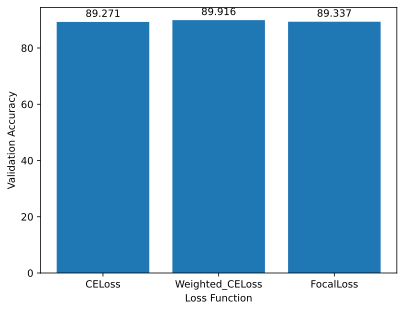

In [82]:
fig, ax = plt.subplots()

loss_func_types = ['CELoss', 'Weighted_CELoss', 'FocalLoss']

bars = ax.bar(loss_func_types, np.mean(loss_func_exp_accuracies, axis=0))
# Loop through the bars and add annotations
for bar in bars:
    height = bar.get_height()
    ax.annotate(f'%.3f'%height, xy=(bar.get_x() + bar.get_width() / 2, height), xytext=(0, 3),
                textcoords="offset points", ha='center', va='bottom')
ax.set_ylabel('Validation Accuracy')
ax.set_xlabel('Loss Function')

plt.show()

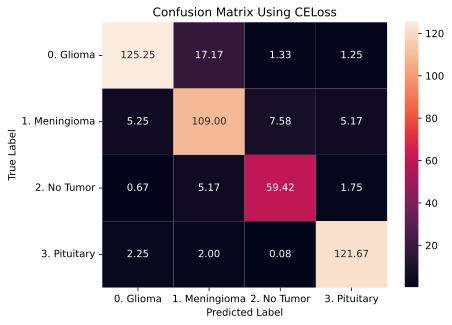

In [97]:
mean_valid_conf_mat = np.array(loss_func_exp_conf_mat['CELoss']).mean(axis=0)
ax = sns.heatmap(mean_valid_conf_mat, xticklabels=tumor_types,
                 yticklabels=tumor_types,annot=True,fmt='.2f') # create seaborn heatmap

plt.title('Confusion Matrix Using CELoss') 
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.show()

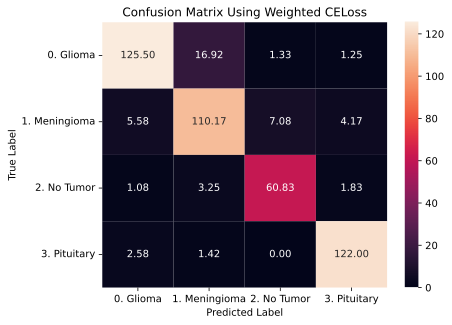

In [96]:
mean_valid_conf_mat = np.array(loss_func_exp_conf_mat['Weighted_CELoss']).mean(axis=0)
ax = sns.heatmap(mean_valid_conf_mat, xticklabels=tumor_types,
                 yticklabels=tumor_types,annot=True,fmt='.2f') # create seaborn heatmap

plt.title('Confusion Matrix Using Weighted CELoss') 
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.show()

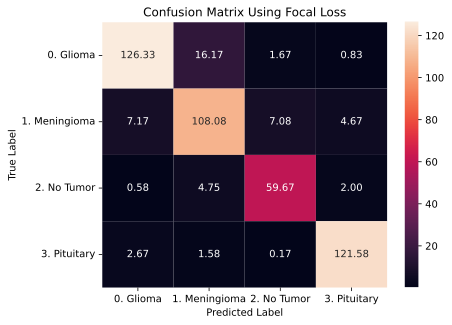

In [95]:
mean_valid_conf_mat = np.array(loss_func_exp_conf_mat['FocalLoss']).mean(axis=0)
ax = sns.heatmap(mean_valid_conf_mat, xticklabels=tumor_types,
                 yticklabels=tumor_types,annot=True,fmt='.2f') # create seaborn heatmap

plt.title('Confusion Matrix Using Focal Loss') 
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## Final Model Training and Testing
Train a brainMRIConvNet model with all the selected hyper-parameters' values above.

In [98]:
# Final selected hyper-parameters' values
learning_rate = 0.007
conv_out_channels = [16,32]
kernel_sizes = [6,3]
strides = [3,1]
paddings = [3,2]
maxpool_k_sizes = 2
fc_nUnit = 768
batch_size = 16
num_of_epochs = 10

CELoss_weights = torch.FloatTensor(train_data_class_inv_ratio)
# If CUDA is available, put the weights on CUDA
if torch.cuda.is_available():
    CELoss_weights = CELoss_weights.to(torch.device("cuda"))
loss_func = nn.CrossEntropyLoss(weight=CELoss_weights)

log_every_n_epoch = 2

# Define train and validation data loaders
train_loader = DataLoader(train_Dataset,batch_size=batch_size, shuffle=True, drop_last=True)
valid_loader = DataLoader(valid_Dataset, batch_size=valid_Dataset.tensors[0].shape[0])


In [99]:
# Create a final brainMRIConvNet model object
final_brain_MRI_net = brainMRIConvNet(conv_out_channels, k_sizes=kernel_sizes, strides=strides, paddings=paddings,
                                      maxpool_k_sizes=maxpool_k_sizes, fc1_out_unit=fc_nUnit)

# Define optimizer according to the result of previous experiment
optimizer = torch.optim.SGD(final_brain_MRI_net.parameters(), lr=learning_rate,momentum=0.9)

# Train the model and store the validation results.
_, valid_acc, _, _, val_conf_mat = trainBrainMRIConvNet(final_brain_MRI_net, train_loader, valid_loader,
                                                        num_of_epochs, log_every_n_epoch,None,optimizer,loss_func)

First convolution layer output size: 43
Second convolution layer output size: 22
First FC linear layer input size: 15488


train-1: 100%|███████████████████████████████████████████████████████████████████████| 135/135 [00:54<00:00,  2.47it/s]


Epoch 1, Avg. Loss 0.366, Valid. Loss 0.660, Valid. Acc 78.065, Train Acc 85.231


train-3: 100%|███████████████████████████████████████████████████████████████████████| 135/135 [00:55<00:00,  2.43it/s]


Epoch 3, Avg. Loss 0.076, Valid. Loss 0.532, Valid. Acc 87.527, Train Acc 97.222


train-5: 100%|███████████████████████████████████████████████████████████████████████| 135/135 [00:54<00:00,  2.49it/s]


Epoch 5, Avg. Loss 0.006, Valid. Loss 0.703, Valid. Acc 87.312, Train Acc 99.861


train-7: 100%|███████████████████████████████████████████████████████████████████████| 135/135 [00:56<00:00,  2.39it/s]


Epoch 7, Avg. Loss 0.001, Valid. Loss 0.567, Valid. Acc 88.602, Train Acc 100.000


train-9: 100%|███████████████████████████████████████████████████████████████████████| 135/135 [00:54<00:00,  2.49it/s]


Epoch 9, Avg. Loss 0.000, Valid. Loss 0.605, Valid. Acc 89.032, Train Acc 100.000


Test the trained brainMRIConvNet model with test dataset

In [102]:
# create dataloader for testing
test_loader = DataLoader(test_Dataset, batch_size=test_Dataset.tensors[0].shape[0])
# Define loss function
#test_loss_func = nn.BCEWithLogitsLoss()

# Turn model to evaluation mode
final_brain_MRI_net.eval()
# get the next batch of validation features and labels for evaluation.
test_X, test_y = next(iter(test_loader))
        
# Use 'torch.no_grad()' to prevent gradient flow back to update model parameters during evaluation.
with torch.no_grad():
    # Forward pass the model to get predictions for the validation data 
    # using the trained model of current epoch
    test_net_out = final_brain_MRI_net(test_X)
        
# compute loss (BCE-with-logits) on test set
#test_loss = test_loss_func(test_net_out, test_y)
#test_loss = test_loss.item()

# compute the accuracy and confusion matrix on test set
y_hat = torch.argmax(test_net_out,axis=1)
test_acc = ( 100*torch.mean((y_hat==test_y).float()).cpu() )
test_conf_mat = confusion_matrix(test_y.cpu(),y_hat.cpu())

In [103]:
print("The trained brainMRIConvNet model has achieved an Accuracy of %.2f percent on test set"%test_acc)

The trained brainMRIConvNet model has achieved an Accuracy of 89.70 percent on test set


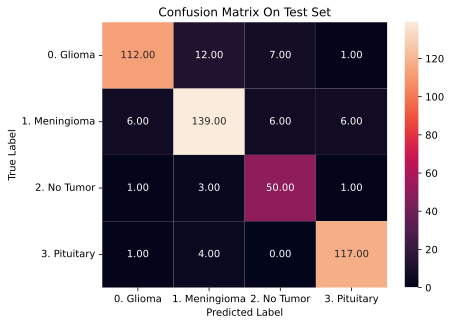

In [104]:
ax = sns.heatmap(test_conf_mat, xticklabels=tumor_types,
                 yticklabels=tumor_types,annot=True,fmt='.2f') # create seaborn heatmap

plt.title('Confusion Matrix On Test Set') 
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()